In [32]:
import random

def get_rewards(a1, a2):
    """
    给定玩家1、2在战场1的分配 a1, a2,
    玩家1在战场2的分配 = 10 - a1
    玩家2在战场2的分配 = 10 - a2
    返回 (r1, r2)
    """
    # 战场1比较
    if a1 > a2:
        r1_1, r2_1 = 1.0, 0.0
    elif a1 < a2:
        r1_1, r2_1 = 0.0, 1.0
    else:
        r1_1, r2_1 = 0.5, 0.5  # 平分

    # 战场2比较
    b1 = 10 - a1  # 玩家1在战场2的分配
    b2 = 10 - a2  # 玩家2在战场2的分配
    if b1 > b2:
        r1_2, r2_2 = 1.0, 0.0
    elif b1 < b2:
        r1_2, r2_2 = 0.0, 1.0
    else:
        r1_2, r2_2 = 0.5, 0.5

    r1 = r1_1 + r1_2
    r2 = r2_1 + r2_2
    return (r1, r2)


def epsilon_greedy(Q, epsilon):
    """
    给定Q表(长度11)和 epsilon，返回一个动作(0..10)。
    以 epsilon 的概率随机选动作，
    以 (1-epsilon) 的概率选 Q值最高的动作(若有并列，随机选其中之一)。
    """
    if random.random() < epsilon:
        return random.randint(0, 10)
    else:
        # 找到最大 Q 值
        maxQ = max(Q)
        # 所有 Q值等于 maxQ 的动作索引
        candidates = [i for i, qv in enumerate(Q) if qv == maxQ]
        return random.choice(candidates)

def check_NE(A, B, p, q, epsilon=1e-5):
    """
    检查( p, q )是否为(近似)混合纳什均衡：
    对 A: U_A(p, q) >= U_A(i, q), 对所有纯策略 i
          并对于 i in support(p), U_A(i,q) ~ U_A(p,q)
    对 B: 同理
    A[i][j], B[i][j]: payoff matrices, shape n x n
    p, q: length n
    """
    n = len(A)
    # 先算 UA(p,q), UB(p,q)
    UA_pq = 0.0
    UB_pq = 0.0
    for i in range(n):
        for j in range(n):
            UA_pq += p[i]*q[j]*A[i][j]
            UB_pq += p[i]*q[j]*B[i][j]

    # 对A: check pure strategy i
    for i in range(n):
        # U_A(i,q) = sum_j q[j]*A[i][j]
        U_iq = sum(q[j]*A[i][j] for j in range(n))
        if U_iq>UA_pq+epsilon:
            print(f"[A can deviate]: pure {i} => payoff={U_iq:.3f} > UA_pq={UA_pq:.3f}")
            return False
        # 若 p[i]>0 => check ~equal
        if p[i]>epsilon:
            if abs(U_iq - UA_pq)>5e-3:
                print(f"[A support mismatch]: i={i}, payoff(i,q)={U_iq:.3f}, UA_pq={UA_pq:.3f}")
                return False

    # 对B
    for j in range(n):
        # U_B(p,j) = sum_i p[i]*B[i][j]
        U_pj = sum(p[i]*B[i][j] for i in range(n))
        if U_pj>UB_pq+epsilon:
            print(f"[B can deviate]: pure {j} => payoff={U_pj:.3f} > UB_pq={UB_pq:.3f}")
            return False
        if q[j]>epsilon:
            if abs(U_pj - UB_pq)>5e-3:
                print(f"[B support mismatch]: j={j}, payoff(p,j)={U_pj:.3f}, UB_pq={UB_pq:.3f}")
                return False

    # 如果都没找到可偏离 => 近似NE
    print("=> (p,q) is a near Nash Equilibrium.")
    return True

def main():
    # 超参数
    alpha = 0.1      # 学习率
    epsilon = 0.1    # epsilon-贪心
    episodes = 5000000    # 迭代轮数(可根据需要加大)

    # 两个玩家的Q表初始化: 11 个动作(0..10)
    Q1 = [0.0]*11
    Q2 = [0.0]*11

    for episode in range(1, episodes+1):
        # 1. 各自根据 epsilon-greedy 选动作
        a1 = epsilon_greedy(Q1, epsilon)
        a2 = epsilon_greedy(Q2, epsilon)

        # 2. 计算即时回报
        r1, r2 = get_rewards(a1, a2)

        # 3. 更新Q
        old_q1 = Q1[a1]
        old_q2 = Q2[a2]
        Q1[a1] = old_q1 + alpha*(r1 - old_q1)
        Q2[a2] = old_q2 + alpha*(r2 - old_q2)

        # 4. 打印本轮信息
        if(episode%5000==0):
            print(f"Episode {episode:2d}: P1_action={a1}, P2_action={a2}, "
                  f"Reward1={r1:.1f}, Reward2={r2:.1f}, "
                  f"Q1[{a1}] from {old_q1:.2f} to {Q1[a1]:.2f}, "
                  f"Q2[{a2}] from {old_q2:.2f} to {Q2[a2]:.2f}")

    # 最终结果
    print("\n=== 最终 Q 值表 ===")
    print("P1: ", [round(q, 2) for q in Q1])
    print("P2: ", [round(q, 2) for q in Q2])

    # 找到各自最优动作(贪心)
    best_a1 = max(range(11), key=lambda i: Q1[i])
    best_a2 = max(range(11), key=lambda i: Q2[i])
    print(f"\nP1最优动作 = {best_a1}, 对应Q值 = {Q1[best_a1]:.2f}")
    print(f"P2最优动作 = {best_a2}, 对应Q值 = {Q2[best_a2]:.2f}")

if __name__ == "__main__":
    main()


Episode 5000: P1_action=9, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[9] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 10000: P1_action=6, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[6] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 15000: P1_action=9, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[9] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 20000: P1_action=9, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[9] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 25000: P1_action=9, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[9] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 30000: P1_action=9, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[9] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 35000: P1_action=1, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[1] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 40000: P1_action=5, P2_action=8, Reward1=1.0, Reward2=1.0, Q1[5] from 1.00 to 1.00, Q2[8] from 1.00 to 1.00
Episode 45000: P1_action=0, P2_action=1, Reward1=1.0, Reward2=1.0, Q1[0] 

Episode 365000: P1_action=4, P2_action=0, Reward1=1.0, Reward2=1.0, Q1[4] from 1.00 to 1.00, Q2[0] from 1.00 to 1.00
Episode 370000: P1_action=0, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 375000: P1_action=9, P2_action=1, Reward1=1.0, Reward2=1.0, Q1[9] from 1.00 to 1.00, Q2[1] from 1.00 to 1.00
Episode 380000: P1_action=0, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 385000: P1_action=4, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[4] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 390000: P1_action=0, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 395000: P1_action=8, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[8] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 400000: P1_action=5, P2_action=5, Reward1=1.0, Reward2=1.0, Q1[5] from 1.00 to 1.00, Q2[5] from 1.00 to 1.00
Episode 405000: P1_action=5, P2_action=10, Reward1=1.0, Rewa

Episode 740000: P1_action=6, P2_action=1, Reward1=1.0, Reward2=1.0, Q1[6] from 1.00 to 1.00, Q2[1] from 1.00 to 1.00
Episode 745000: P1_action=3, P2_action=7, Reward1=1.0, Reward2=1.0, Q1[3] from 1.00 to 1.00, Q2[7] from 1.00 to 1.00
Episode 750000: P1_action=3, P2_action=2, Reward1=1.0, Reward2=1.0, Q1[3] from 1.00 to 1.00, Q2[2] from 1.00 to 1.00
Episode 755000: P1_action=5, P2_action=2, Reward1=1.0, Reward2=1.0, Q1[5] from 1.00 to 1.00, Q2[2] from 1.00 to 1.00
Episode 760000: P1_action=8, P2_action=8, Reward1=1.0, Reward2=1.0, Q1[8] from 1.00 to 1.00, Q2[8] from 1.00 to 1.00
Episode 765000: P1_action=3, P2_action=6, Reward1=1.0, Reward2=1.0, Q1[3] from 1.00 to 1.00, Q2[6] from 1.00 to 1.00
Episode 770000: P1_action=2, P2_action=8, Reward1=1.0, Reward2=1.0, Q1[2] from 1.00 to 1.00, Q2[8] from 1.00 to 1.00
Episode 775000: P1_action=1, P2_action=5, Reward1=1.0, Reward2=1.0, Q1[1] from 1.00 to 1.00, Q2[5] from 1.00 to 1.00
Episode 780000: P1_action=6, P2_action=7, Reward1=1.0, Reward2=1

Episode 1130000: P1_action=10, P2_action=0, Reward1=1.0, Reward2=1.0, Q1[10] from 1.00 to 1.00, Q2[0] from 1.00 to 1.00
Episode 1135000: P1_action=2, P2_action=0, Reward1=1.0, Reward2=1.0, Q1[2] from 1.00 to 1.00, Q2[0] from 1.00 to 1.00
Episode 1140000: P1_action=5, P2_action=8, Reward1=1.0, Reward2=1.0, Q1[5] from 1.00 to 1.00, Q2[8] from 1.00 to 1.00
Episode 1145000: P1_action=0, P2_action=1, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[1] from 1.00 to 1.00
Episode 1150000: P1_action=2, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[2] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 1155000: P1_action=8, P2_action=0, Reward1=1.0, Reward2=1.0, Q1[8] from 1.00 to 1.00, Q2[0] from 1.00 to 1.00
Episode 1160000: P1_action=6, P2_action=9, Reward1=1.0, Reward2=1.0, Q1[6] from 1.00 to 1.00, Q2[9] from 1.00 to 1.00
Episode 1165000: P1_action=8, P2_action=7, Reward1=1.0, Reward2=1.0, Q1[8] from 1.00 to 1.00, Q2[7] from 1.00 to 1.00
Episode 1170000: P1_action=2, P2_action=9, Reward1=1

Episode 1520000: P1_action=7, P2_action=9, Reward1=1.0, Reward2=1.0, Q1[7] from 1.00 to 1.00, Q2[9] from 1.00 to 1.00
Episode 1525000: P1_action=7, P2_action=0, Reward1=1.0, Reward2=1.0, Q1[7] from 1.00 to 1.00, Q2[0] from 1.00 to 1.00
Episode 1530000: P1_action=2, P2_action=6, Reward1=1.0, Reward2=1.0, Q1[2] from 1.00 to 1.00, Q2[6] from 1.00 to 1.00
Episode 1535000: P1_action=5, P2_action=0, Reward1=1.0, Reward2=1.0, Q1[5] from 1.00 to 1.00, Q2[0] from 1.00 to 1.00
Episode 1540000: P1_action=0, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 1545000: P1_action=9, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[9] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 1550000: P1_action=8, P2_action=6, Reward1=1.0, Reward2=1.0, Q1[8] from 1.00 to 1.00, Q2[6] from 1.00 to 1.00
Episode 1555000: P1_action=8, P2_action=8, Reward1=1.0, Reward2=1.0, Q1[8] from 1.00 to 1.00, Q2[8] from 1.00 to 1.00
Episode 1560000: P1_action=3, P2_action=4, Reward1=1.0

Episode 1900000: P1_action=1, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[1] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 1905000: P1_action=1, P2_action=7, Reward1=1.0, Reward2=1.0, Q1[1] from 1.00 to 1.00, Q2[7] from 1.00 to 1.00
Episode 1910000: P1_action=7, P2_action=8, Reward1=1.0, Reward2=1.0, Q1[7] from 1.00 to 1.00, Q2[8] from 1.00 to 1.00
Episode 1915000: P1_action=2, P2_action=2, Reward1=1.0, Reward2=1.0, Q1[2] from 1.00 to 1.00, Q2[2] from 1.00 to 1.00
Episode 1920000: P1_action=1, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[1] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 1925000: P1_action=8, P2_action=0, Reward1=1.0, Reward2=1.0, Q1[8] from 1.00 to 1.00, Q2[0] from 1.00 to 1.00
Episode 1930000: P1_action=2, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[2] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 1935000: P1_action=9, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[9] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 1940000: P1_action=5, P2_action=3, Reward1

Episode 2280000: P1_action=3, P2_action=6, Reward1=1.0, Reward2=1.0, Q1[3] from 1.00 to 1.00, Q2[6] from 1.00 to 1.00
Episode 2285000: P1_action=4, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[4] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 2290000: P1_action=3, P2_action=5, Reward1=1.0, Reward2=1.0, Q1[3] from 1.00 to 1.00, Q2[5] from 1.00 to 1.00
Episode 2295000: P1_action=7, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[7] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 2300000: P1_action=6, P2_action=7, Reward1=1.0, Reward2=1.0, Q1[6] from 1.00 to 1.00, Q2[7] from 1.00 to 1.00
Episode 2305000: P1_action=5, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[5] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 2310000: P1_action=10, P2_action=7, Reward1=1.0, Reward2=1.0, Q1[10] from 1.00 to 1.00, Q2[7] from 1.00 to 1.00
Episode 2315000: P1_action=3, P2_action=1, Reward1=1.0, Reward2=1.0, Q1[3] from 1.00 to 1.00, Q2[1] from 1.00 to 1.00
Episode 2320000: P1_action=3, P2_action=1, Reward1=1

Episode 2650000: P1_action=3, P2_action=7, Reward1=1.0, Reward2=1.0, Q1[3] from 1.00 to 1.00, Q2[7] from 1.00 to 1.00
Episode 2655000: P1_action=9, P2_action=2, Reward1=1.0, Reward2=1.0, Q1[9] from 1.00 to 1.00, Q2[2] from 1.00 to 1.00
Episode 2660000: P1_action=0, P2_action=8, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[8] from 1.00 to 1.00
Episode 2665000: P1_action=10, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[10] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 2670000: P1_action=4, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[4] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 2675000: P1_action=6, P2_action=8, Reward1=1.0, Reward2=1.0, Q1[6] from 1.00 to 1.00, Q2[8] from 1.00 to 1.00
Episode 2680000: P1_action=10, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[10] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 2685000: P1_action=4, P2_action=5, Reward1=1.0, Reward2=1.0, Q1[4] from 1.00 to 1.00, Q2[5] from 1.00 to 1.00
Episode 2690000: P1_action=6, P2_action=1, Reward1=1

Episode 3040000: P1_action=0, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 3045000: P1_action=8, P2_action=6, Reward1=1.0, Reward2=1.0, Q1[8] from 1.00 to 1.00, Q2[6] from 1.00 to 1.00
Episode 3050000: P1_action=4, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[4] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 3055000: P1_action=3, P2_action=6, Reward1=1.0, Reward2=1.0, Q1[3] from 1.00 to 1.00, Q2[6] from 1.00 to 1.00
Episode 3060000: P1_action=6, P2_action=9, Reward1=1.0, Reward2=1.0, Q1[6] from 1.00 to 1.00, Q2[9] from 1.00 to 1.00
Episode 3065000: P1_action=1, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[1] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 3070000: P1_action=7, P2_action=2, Reward1=1.0, Reward2=1.0, Q1[7] from 1.00 to 1.00, Q2[2] from 1.00 to 1.00
Episode 3075000: P1_action=5, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[5] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 3080000: P1_action=1, P2_action=5, Reward1=1.0

Episode 3415000: P1_action=2, P2_action=2, Reward1=1.0, Reward2=1.0, Q1[2] from 1.00 to 1.00, Q2[2] from 1.00 to 1.00
Episode 3420000: P1_action=0, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 3425000: P1_action=4, P2_action=8, Reward1=1.0, Reward2=1.0, Q1[4] from 1.00 to 1.00, Q2[8] from 1.00 to 1.00
Episode 3430000: P1_action=1, P2_action=9, Reward1=1.0, Reward2=1.0, Q1[1] from 1.00 to 1.00, Q2[9] from 1.00 to 1.00
Episode 3435000: P1_action=6, P2_action=5, Reward1=1.0, Reward2=1.0, Q1[6] from 1.00 to 1.00, Q2[5] from 1.00 to 1.00
Episode 3440000: P1_action=5, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[5] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 3445000: P1_action=4, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[4] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 3450000: P1_action=0, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 3455000: P1_action=4, P2_action=5, Reward1=1.0, 

Episode 3765000: P1_action=0, P2_action=6, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[6] from 1.00 to 1.00
Episode 3770000: P1_action=4, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[4] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 3775000: P1_action=10, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[10] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 3780000: P1_action=1, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[1] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 3785000: P1_action=3, P2_action=1, Reward1=1.0, Reward2=1.0, Q1[3] from 1.00 to 1.00, Q2[1] from 1.00 to 1.00
Episode 3790000: P1_action=0, P2_action=5, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[5] from 1.00 to 1.00
Episode 3795000: P1_action=8, P2_action=2, Reward1=1.0, Reward2=1.0, Q1[8] from 1.00 to 1.00, Q2[2] from 1.00 to 1.00
Episode 3800000: P1_action=10, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[10] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 3805000: P1_action=3, P2_action=6, Rewar

Episode 4135000: P1_action=4, P2_action=0, Reward1=1.0, Reward2=1.0, Q1[4] from 1.00 to 1.00, Q2[0] from 1.00 to 1.00
Episode 4140000: P1_action=6, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[6] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 4145000: P1_action=7, P2_action=6, Reward1=1.0, Reward2=1.0, Q1[7] from 1.00 to 1.00, Q2[6] from 1.00 to 1.00
Episode 4150000: P1_action=0, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 4155000: P1_action=0, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 4160000: P1_action=6, P2_action=8, Reward1=1.0, Reward2=1.0, Q1[6] from 1.00 to 1.00, Q2[8] from 1.00 to 1.00
Episode 4165000: P1_action=1, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[1] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 4170000: P1_action=0, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 4175000: P1_action=3, P2_action=1, Reward1=1.0

Episode 4495000: P1_action=8, P2_action=2, Reward1=1.0, Reward2=1.0, Q1[8] from 1.00 to 1.00, Q2[2] from 1.00 to 1.00
Episode 4500000: P1_action=3, P2_action=6, Reward1=1.0, Reward2=1.0, Q1[3] from 1.00 to 1.00, Q2[6] from 1.00 to 1.00
Episode 4505000: P1_action=0, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 4510000: P1_action=9, P2_action=4, Reward1=1.0, Reward2=1.0, Q1[9] from 1.00 to 1.00, Q2[4] from 1.00 to 1.00
Episode 4515000: P1_action=6, P2_action=1, Reward1=1.0, Reward2=1.0, Q1[6] from 1.00 to 1.00, Q2[1] from 1.00 to 1.00
Episode 4520000: P1_action=2, P2_action=7, Reward1=1.0, Reward2=1.0, Q1[2] from 1.00 to 1.00, Q2[7] from 1.00 to 1.00
Episode 4525000: P1_action=5, P2_action=6, Reward1=1.0, Reward2=1.0, Q1[5] from 1.00 to 1.00, Q2[6] from 1.00 to 1.00
Episode 4530000: P1_action=0, P2_action=2, Reward1=1.0, Reward2=1.0, Q1[0] from 1.00 to 1.00, Q2[2] from 1.00 to 1.00
Episode 4535000: P1_action=5, P2_action=4, Reward1=1.0, 

Episode 4880000: P1_action=4, P2_action=2, Reward1=1.0, Reward2=1.0, Q1[4] from 1.00 to 1.00, Q2[2] from 1.00 to 1.00
Episode 4885000: P1_action=9, P2_action=5, Reward1=1.0, Reward2=1.0, Q1[9] from 1.00 to 1.00, Q2[5] from 1.00 to 1.00
Episode 4890000: P1_action=3, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[3] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 4895000: P1_action=2, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[2] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 4900000: P1_action=6, P2_action=10, Reward1=1.0, Reward2=1.0, Q1[6] from 1.00 to 1.00, Q2[10] from 1.00 to 1.00
Episode 4905000: P1_action=10, P2_action=7, Reward1=1.0, Reward2=1.0, Q1[10] from 1.00 to 1.00, Q2[7] from 1.00 to 1.00
Episode 4910000: P1_action=7, P2_action=9, Reward1=1.0, Reward2=1.0, Q1[7] from 1.00 to 1.00, Q2[9] from 1.00 to 1.00
Episode 4915000: P1_action=8, P2_action=3, Reward1=1.0, Reward2=1.0, Q1[8] from 1.00 to 1.00, Q2[3] from 1.00 to 1.00
Episode 4920000: P1_action=1, P2_action=0, Reward1

In [2]:
import random

# ---------- 1. 建立 payoff 矩阵 ----------

def compute_payoff(i, j):
    """
    计算玩家1在动作 i, 玩家2在动作 j 时的得分 payoff1。
    i, j 分别表示在战场1投入的兵力(0~10)。
    总资源=10, 战场2 投入则分别是(10 - i) 和(10 - j)。
    """
    # 战场1
    if i > j:
        s1_1, s2_1 = 1.0, 0.0
    elif i < j:
        s1_1, s2_1 = 0.0, 1.0
    else:
        s1_1, s2_1 = 0.5, 0.5
    
    # 战场2
    i2 = 10 - i
    j2 = 10 - j
    if i2 > j2:
        s1_2, s2_2 = 1.0, 0.0
    elif i2 < j2:
        s1_2, s2_2 = 0.0, 1.0
    else:
        s1_2, s2_2 = 0.5, 0.5
    
    return s1_1 + s1_2  # 玩家1总分

# 构建 payoff1 矩阵：11x11
payoff1 = [[0.0]*11 for _ in range(11)]
for i in range(11):
    for j in range(11):
        payoff1[i][j] = compute_payoff(i, j)


# ---------- 2. 后悔匹配循环 ----------

def sample_action(strategy):
    """
    根据给定策略(长度11的概率分布) 采样一个动作(0..10)。
    """
    r = random.random()
    cum = 0.0
    for i, p in enumerate(strategy):
        cum += p
        if r <= cum:
            return i
    # 万一出现浮点误差导致没返回，则返回最后一个
    return 10

def normalize_regret(regretSum):
    """
    根据 regretSum 计算新的策略:
    strategy[i] = max(0, regretSum[i]) / sum_of_positive_regrets
    如分母=0则返回均匀分布
    """
    positives = [max(0.0, r) for r in regretSum]
    s = sum(positives)
    if s > 1e-12:
        return [x/s for x in positives]
    else:
        return [1.0/11]*11


def regret_matching(num_iterations=50, print_each_round=True):
    # 初始化
    regretSum1 = [0.0]*11
    regretSum2 = [0.0]*11
    strategy1 = [1.0/11]*11  # 均匀初始
    strategy2 = [1.0/11]*11

    for t in range(1, num_iterations+1):
        # 1) 从各自混合策略中抽取一个纯动作
        i = sample_action(strategy1)
        j = sample_action(strategy2)

        # 2) 获取即时收益
        r1 = payoff1[i][j]
        r2 = 2.0 - r1  # 零和
        
        # 3) 对玩家1：更新后悔
        for i_prime in range(11):
            alt_r1 = payoff1[i_prime][j]
            regretSum1[i_prime] += (alt_r1 - r1)
        
        # 4) 对玩家2：更新后悔 (需先定义 payoff2 矩阵，或直接用 r2 = 2-r1)
        # 但要模拟 "若玩家2动作换成 j_prime" 时的收益:
        #   alt_r2 = payoff2(i, j_prime).
        # 这里 payoff2(i,j) = 2 - payoff1(i,j)
        # 所以 alt_r2 = 2 - payoff1(i, j_prime)
        for j_prime in range(11):
            alt_r2 = 2.0 - payoff1[i][j_prime]
            regretSum2[j_prime] += (alt_r2 - r2)
        
        # 5) 根据 regretSum 计算新的策略
        strategy1 = normalize_regret(regretSum1)
        strategy2 = normalize_regret(regretSum2)

        # 打印每轮信息
        if print_each_round:
            print(f"Iter={t:2d} | P1 action={i}, P2 action={j}, "
                  f"Payoff1={r1:.2f}, Payoff2={r2:.2f}")
            print(f"    P1 strategy~{[round(x,3) for x in strategy1]}")
            print(f"    P2 strategy~{[round(x,3) for x in strategy2]}")

    return strategy1, strategy2, regretSum1, regretSum2


if __name__ == "__main__":
    final_s1, final_s2, rSum1, rSum2 = regret_matching(
        num_iterations=50,
        print_each_round=True
    )

    print("\n=== 最终混合策略(approx) ===")
    print("P1 strategy:", [round(x,3) for x in final_s1])
    print("P2 strategy:", [round(x,3) for x in final_s2])

    # 找各自最常被分配概率高的动作:
    best_i = max(range(11), key=lambda i: final_s1[i])
    best_j = max(range(11), key=lambda j: final_s2[j])
    print(f"\nP1最高概率动作: {best_i}, 概率={final_s1[best_i]:.3f}")
    print(f"P2最高概率动作: {best_j}, 概率={final_s2[best_j]:.3f}")


Iter= 1 | P1 action=7, P2 action=9, Payoff1=1.00, Payoff2=1.00
    P1 strategy~[0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091]
    P2 strategy~[0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091]
Iter= 2 | P1 action=7, P2 action=9, Payoff1=1.00, Payoff2=1.00
    P1 strategy~[0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091]
    P2 strategy~[0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091]
Iter= 3 | P1 action=10, P2 action=0, Payoff1=1.00, Payoff2=1.00
    P1 strategy~[0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091]
    P2 strategy~[0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091]
Iter= 4 | P1 action=3, P2 action=5, Payoff1=1.00, Payoff2=1.00
    P1 strategy~[0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091]
    P2 strategy~[0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.091, 0.

In [1]:
import math

def payoff_for_player1(x, y):
    """
    x: 玩家1在战场1投入的兵力
    y: 玩家2在战场1投入的兵力
    返回玩家1的总得分 (0~2 之间, 可能是0.5,1,1.5等)
    """
    # 战场1
    if x > y:
        score1_1 = 1.0
    elif x < y:
        score1_1 = 0.0
    else:
        score1_1 = 0.5

    # 战场2
    x2 = 10 - x  # 玩家1在战场2投入的兵力
    y2 = 10 - y  # 玩家2在战场2投入的兵力
    if x2 > y2:
        score1_2 = 1.0
    elif x2 < y2:
        score1_2 = 0.0
    else:
        score1_2 = 0.5

    return score1_1 + score1_2


def alpha_beta(step, x1, alpha, beta, maximizingPlayer):
    """
    step: 0或1，用于区分谁行动:
        0 -> 玩家1(极大化)，他要选x1(0~10)
        1 -> 玩家2(极小化)，他要选y (0~10) 后直接得出最终分值
    x1:   当 step=0 时还未确定玩家1的分配；当 step=1 时已经记录了玩家1选的分配
    alpha, beta: Alpha-Beta 剪枝参数
    maximizingPlayer: 布尔值，True 表示当前节点是极大化节点，False 表示极小化节点
    返回 (best_value, best_move)
    """
    if step == 1 and maximizingPlayer is False:
        # 表示轮到玩家2选动作，一旦玩家2选择y后，我们就能计算最终得分
        # 因此此时我们要遍历y=0..10，选一个使得玩家1得分最小
        best_value = math.inf
        best_move = None
        for y in range(11):
            score = payoff_for_player1(x1, y)  # 这里直接计算玩家1最后得分
            # 由于玩家2是极小化玩家1的得分, 所以我们要取最小
            if score < best_value:
                best_value = score
                best_move = y
            # alpha-beta 剪枝检查
            beta = min(beta, best_value)
            if beta <= alpha:
                break
        return best_value, best_move

    elif step == 0 and maximizingPlayer is True:
        # 表示轮到玩家1决策 x1
        best_value = -math.inf
        best_move = None
        for x in range(11):
            # 递归调用: 下一步 step=1, maximizingPlayer=False
            value, _ = alpha_beta(step=1, x1=x,
                                  alpha=alpha, beta=beta,
                                  maximizingPlayer=False)
            if value > best_value:
                best_value = value
                best_move = x

            alpha = max(alpha, best_value)
            if beta <= alpha:
                break
        return best_value, best_move

    else:
        # 不应该出现的状态(因为只有两层)
        return 0, None


def main():
    # 我们只做两层搜索:
    # 第0层: 玩家1 选 x1
    # 第1层: 玩家2 选 y
    # 最终得到 payoff_for_player1(x1,y)

    alpha = -math.inf
    beta  =  math.inf

    # 玩家1是极大化节点:
    best_score, best_alloc = alpha_beta(step=0, x1=None,
                                        alpha=alpha, beta=beta,
                                        maximizingPlayer=True)

    print(f"玩家1在战场1的最优分配是 {best_alloc} (共10点资源)")
    print(f"若玩家1这样分配, 在玩家2最优应对下, 玩家1能得到的期望得分 = {best_score:.2f}")

    # 为了直观，我们再算算玩家2对这个 best_alloc 的对应动作
    # 也可以直接调用 alpha_beta，或者自己在 range(11) 里找令玩家1得分最小的 y
    best_y = None
    min_score = math.inf
    for y in range(11):
        score = payoff_for_player1(best_alloc, y)
        if score < min_score:
            min_score = score
            best_y = y

    print(f"玩家2在战场1的应对是 {best_y}，这样玩家1最终得分是 {min_score:.2f}")


if __name__ == "__main__":
    main()


玩家1在战场1的最优分配是 0 (共10点资源)
若玩家1这样分配, 在玩家2最优应对下, 玩家1能得到的期望得分 = 1.00
玩家2在战场1的应对是 0，这样玩家1最终得分是 1.00


In [5]:
import random
import math

N = 5       # 战场数量
TOTAL = 10  # 每方资源总数
MAX_MOVE = 2  # 每轮最多可移动的资源点数
SEARCH_DEPTH = 2  # Alpha-Beta 搜索深度 (2层为演示)

def random_distribution(n, total):
    """
    返回一个长度 n、和为 total 的随机整数分配列表，如 [2,0,3,5,0]。
    简单做法：先生成 random 的 n-1 个切分点，然后排序切分。
    """
    cuts = sorted(random.sample(range(total + n - 1), n - 1))
    dist = []
    prev = 0
    for c in cuts:
        dist.append(c - prev)
        prev = c
    dist.append((total + n - 1) - prev)
    # 这样每个数都有可能 > total，需稍微处理一下:
    # 这里做法比较trick，不一定完全均匀，但演示够了
    # 其实可以用stars and bars正确采样，但这里为了简单。
    
    # dist 里每个数还包含了 n-1 的计数，需要减去 (n-1) 才是真正资源
    # 不过为了不复杂化，这里重新洗一下
    # 更简单做法：直接循环10次，每次随机给某战场+1
    d = [0]*n
    for _ in range(total):
        idx = random.randint(0, n-1)
        d[idx] += 1
    return d

def score(A, B):
    """
    比较分配 A vs B 在 5 个战场上的胜负
    返回 (winsA, winsB), 例如 (3,2) 表示A赢3场，B赢2场。
    如相等则各得0.5
    """
    winsA = 0.0
    winsB = 0.0
    for i in range(N):
        if A[i] > B[i]:
            winsA += 1
        elif A[i] < B[i]:
            winsB += 1
        else:
            winsA += 0.5
            winsB += 0.5
    return (winsA, winsB)

def evaluate(A, B):
    """
    用于Alpha-Beta节点评估: 返回 A得分 - B得分
    """
    wA, wB = score(A,B)
    return wA - wB

def possible_moves(dist):
    """
    给定一个分配 dist(长度N,和=10)，
    枚举所有一次可移动 <= MAX_MOVE(2)资源的动作 (i->j, k)。
    返回形如 [(newDist1, (i,j,k)), (newDist2, (i,j,k)), ...]
    """
    moves = []
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            # k是要移动的资源数(1~MAX_MOVE)
            for k in range(1, MAX_MOVE+1):
                if dist[i] >= k:
                    newD = list(dist)
                    newD[i] -= k
                    newD[j] += k
                    # 要保证仍然满足sum=10
                    # 其实这种移动不会破坏总和，但可以加个检查
                    if sum(newD) == TOTAL:
                        moves.append((tuple(newD), (i,j,k)))
    return moves

def alpha_beta(A_dist, B_dist, depth, alpha, beta, maximizingPlayer):
    """
    A_dist, B_dist: 当前A,B的分配
    depth: 当前搜索剩余深度
    alpha, beta: alpha-beta剪枝参数
    maximizingPlayer: True表示该层轮到A行动(极大化)，False表示B行动(极小化)
    
    返回 (best_value, best_distA, best_distB, best_move)
      其中 best_move 可以是 (i,j,k) 表示此次行动如何移动
    """
    if depth == 0:
        # 用评估函数 evaluate(A_dist, B_dist)
        return (evaluate(A_dist, B_dist), A_dist, B_dist, None)
    
    if maximizingPlayer:
        # 轮到A走: 遍历A所有可能移动
        best_value = -math.inf
        best_move = None
        best_A = A_dist
        best_B = B_dist
        all_moves = possible_moves(A_dist)
        if not all_moves:  # 没有可动(例如所有战场都是0 except one)
            return (evaluate(A_dist, B_dist), A_dist, B_dist, None)
        
        for (newA, move) in all_moves:
            val, tmpA, tmpB, mv = alpha_beta(newA, B_dist,
                                             depth-1, alpha, beta,
                                             maximizingPlayer=False)
            if val > best_value:
                best_value = val
                best_move = move
                best_A = newA
                best_B = B_dist
            
            alpha = max(alpha, best_value)
            if beta <= alpha:
                break
        
        return (best_value, best_A, best_B, best_move)
    else:
        # 轮到B走: 遍历B的可能移动(最小化A的评估值)
        best_value = math.inf
        best_move = None
        best_A = A_dist
        best_B = B_dist
        all_moves = possible_moves(B_dist)
        if not all_moves:
            return (evaluate(A_dist, B_dist), A_dist, B_dist, None)
        
        for (newB, move) in all_moves:
            val, tmpA, tmpB, mv = alpha_beta(A_dist, newB,
                                             depth-1, alpha, beta,
                                             maximizingPlayer=True)
            if val < best_value:
                best_value = val
                best_move = move
                best_B = newB
                best_A = A_dist

            beta = min(beta, best_value)
            if beta <= alpha:
                break
        
        return (best_value, best_A, best_B, best_move)

def main():
    # 1. 初始化
    A_dist = tuple(random_distribution(N, TOTAL))
    B_dist = tuple(random_distribution(N, TOTAL))
    
    print("初始:")
    print("A =", A_dist)
    print("B =", B_dist)
    wA, wB = score(A_dist, B_dist)
    print(f"  A赢{wA}场, B赢{wB}场\n")
    
    # 迭代若干轮
    rounds = 10  # 你可自行调整
    for r in range(1, rounds+1):
        print(f"=== 第 {r} 轮 ===")
        # A 行动
        valA, newA, newB, moveA = alpha_beta(A_dist, B_dist,
                                             depth=SEARCH_DEPTH,
                                             alpha=-math.inf,
                                             beta=math.inf,
                                             maximizingPlayer=True)
        A_dist = newA  # 应用A的移动结果
        print(f"A行动 -> move={moveA}, new A={A_dist}")
        
        # B 行动
        valB, newA2, newB2, moveB = alpha_beta(A_dist, B_dist,
                                               depth=SEARCH_DEPTH,
                                               alpha=-math.inf,
                                               beta=math.inf,
                                               maximizingPlayer=False)
        B_dist = newB2
        print(f"B行动 -> move={moveB}, new B={B_dist}")
        
        # 结果
        wA, wB = score(A_dist, B_dist)
        print(f"  A分配={A_dist}\n  B分配={B_dist}")
        print(f"  A赢{wA}场, B赢{wB}场\n")

if __name__ == "__main__":
    main()


初始:
A = (2, 3, 1, 0, 4)
B = (2, 2, 4, 0, 2)
  A赢3.0场, B赢2.0场

=== 第 1 轮 ===
A行动 -> move=(2, 0, 1), new A=(3, 3, 0, 0, 4)
B行动 -> move=(2, 0, 2), new B=(4, 2, 2, 0, 2)
  A分配=(3, 3, 0, 0, 4)
  B分配=(4, 2, 2, 0, 2)
  A赢2.5场, B赢2.5场

=== 第 2 轮 ===
A行动 -> move=(0, 1, 1), new A=(2, 4, 0, 0, 4)
B行动 -> move=(1, 3, 2), new B=(4, 0, 2, 2, 2)
  A分配=(2, 4, 0, 0, 4)
  B分配=(4, 0, 2, 2, 2)
  A赢2.0场, B赢3.0场

=== 第 3 轮 ===
A行动 -> move=(0, 2, 2), new A=(0, 4, 2, 0, 4)
B行动 -> move=(0, 2, 2), new B=(2, 0, 4, 2, 2)
  A分配=(0, 4, 2, 0, 4)
  B分配=(2, 0, 4, 2, 2)
  A赢2.0场, B赢3.0场

=== 第 4 轮 ===
A行动 -> move=(1, 0, 1), new A=(1, 3, 2, 0, 4)
B行动 -> move=(4, 0, 1), new B=(3, 0, 4, 2, 1)
  A分配=(1, 3, 2, 0, 4)
  B分配=(3, 0, 4, 2, 1)
  A赢2.0场, B赢3.0场

=== 第 5 轮 ===
A行动 -> move=(0, 1, 1), new A=(0, 4, 2, 0, 4)
B行动 -> move=(0, 1, 1), new B=(2, 1, 4, 2, 1)
  A分配=(0, 4, 2, 0, 4)
  B分配=(2, 1, 4, 2, 1)
  A赢2.0场, B赢3.0场

=== 第 6 轮 ===
A行动 -> move=(1, 0, 1), new A=(1, 3, 2, 0, 4)
B行动 -> move=(1, 0, 1), new B=(3, 0, 4, 2, 1)
  A分

In [8]:
import math
import random

N = 5            # 战场数
TOTAL = 20       # 每方资源总数
MAX_SHIFT = 5    # 一次最多可移动的资源点数
SEARCH_DEPTH = 4 # Alpha-Beta 搜索深度
ROUNDS = 100       # 迭代轮数，可自行调大

def random_distribution(n, total):
    """
    随机生成一个长度为 n、和为 total 的整数分配。
    这里用一个简单的做法：循环 total 次，每次随机给某战场 +1。
    """
    dist = [0]*n
    for _ in range(total):
        idx = random.randint(0, n-1)
        dist[idx] += 1
    return tuple(dist)

def score(A_dist, B_dist):
    """
    返回 (A_win, B_win): 在 N 个战场上比较 A_dist[i] vs B_dist[i]。
    A_dist[i] > B_dist[i] => A 在第 i 个战场得 1 分；
    相等 => 各得 0.5；B_dist[i] > A_dist[i] => B 得 1 分。
    """
    A_win = 0.0
    B_win = 0.0
    for i in range(N):
        if A_dist[i] > B_dist[i]:
            A_win += 1
        elif A_dist[i] < B_dist[i]:
            B_win += 1
        else:
            A_win += 0.5
            B_win += 0.5
    return (A_win, B_win)

def evaluate(A_dist, B_dist):
    """
    用于 Alpha-Beta 搜索的叶节点评估：返回 A得分 - B得分
    """
    A_win, B_win = score(A_dist, B_dist)
    return A_win - B_win

def possible_moves(dist):
    """
    给定一个分配 dist(长度 N, 和=TOTAL)，生成所有“一次移动 <= MAX_SHIFT 点资源”的新分配。
    返回列表 [(newDist, (i,j,k)) ... ]，其中 (i,j,k) 表示从战场 i -> j 移动 k 点。
    """
    moves = []
    n = len(dist)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            for k in range(1, MAX_SHIFT+1):
                if dist[i] >= k:
                    newD = list(dist)
                    newD[i] -= k
                    newD[j] += k
                    # 总和应依然是 TOTAL，这里不会被破坏，所以不用再检验 sum(newD) == TOTAL
                    moves.append((tuple(newD), (i,j,k)))
    return moves

def alpha_beta(A_dist, B_dist, depth, alpha, beta, isAturn):
    """
    在 (A_dist, B_dist) 状态下做深度为 depth 的 Alpha-Beta 搜索。
    - isAturn=True 表示这一步由 A 来移动资源(极大化)；
    - isAturn=False 表示这一步由 B 来移动资源(极小化)。
    返回 (best_val, best_A, best_B, best_move)
      best_val : 评估值 (A得分-B得分)
      best_A   : 搜索得到的下层最优A分配
      best_B   : 搜索得到的下层最优B分配
      best_move: 本步选用的 (i,j,k) 移动(可能为None,若无可动)
    """
    # 如果达到最大深度或无法继续，则评估
    if depth == 0:
        return (evaluate(A_dist, B_dist), A_dist, B_dist, None)
    
    if isAturn:
        # A 的回合(极大化)
        best_val = -math.inf
        best_move = None
        best_A_final = A_dist
        best_B_final = B_dist

        movesA = possible_moves(A_dist)
        if not movesA:  # 没有可用移动
            # 直接评估
            val = evaluate(A_dist, B_dist)
            return (val, A_dist, B_dist, None)

        for (newA, move) in movesA:
            val_next, a_next, b_next, _ = alpha_beta(
                newA, B_dist, depth-1,
                alpha, beta, isAturn=False)
            if val_next > best_val:
                best_val = val_next
                best_move = move
                best_A_final = a_next
                best_B_final = b_next

            alpha = max(alpha, best_val)
            if beta <= alpha:
                break

        return (best_val, best_A_final, best_B_final, best_move)

    else:
        # B 的回合(极小化)
        best_val = math.inf
        best_move = None
        best_A_final = A_dist
        best_B_final = B_dist

        movesB = possible_moves(B_dist)
        if not movesB:
            # 无移动，直接评估
            val = evaluate(A_dist, B_dist)
            return (val, A_dist, B_dist, None)

        for (newB, move) in movesB:
            val_next, a_next, b_next, _ = alpha_beta(
                A_dist, newB, depth-1,
                alpha, beta, isAturn=True)
            if val_next < best_val:
                best_val = val_next
                best_move = move
                best_A_final = a_next
                best_B_final = b_next

            beta = min(beta, best_val)
            if beta <= alpha:
                break

        return (best_val, best_A_final, best_B_final, best_move)


def best_move_for_A(A_dist, B_dist):
    """
    在当前 (A_dist, B_dist) 下，以 A 为极大化玩家做 Alpha-Beta 搜索，
    并返回 A 想要执行的“下一步移动过后的分配”。
    """
    val, a_opt, b_opt, move = alpha_beta(A_dist, B_dist,
                                         depth=SEARCH_DEPTH,
                                         alpha=-math.inf,
                                         beta=math.inf,
                                         isAturn=True)
    if move is not None:
        (i,j,k) = move
        newA = list(A_dist)
        newA[i] -= k
        newA[j] += k
        return tuple(newA)
    else:
        return A_dist  # 无移动

def best_move_for_B(A_dist, B_dist):
    """
    在当前 (A_dist, B_dist) 下，以 B 为极小化玩家做 Alpha-Beta 搜索，
    返回 B 想要执行的“下一步移动过后的分配”。
    """
    val, a_opt, b_opt, move = alpha_beta(A_dist, B_dist,
                                         depth=SEARCH_DEPTH,
                                         alpha=-math.inf,
                                         beta=math.inf,
                                         isAturn=False)
    if move is not None:
        (i,j,k) = move
        newB = list(B_dist)
        newB[i] -= k
        newB[j] += k
        return tuple(newB)
    else:
        return B_dist


def main():
    # 随机初始化 A、B 的分配
    A_dist = random_distribution(N, TOTAL)
    B_dist = random_distribution(N, TOTAL)

    print("初始分配：")
    print("A =", A_dist)
    print("B =", B_dist)
    A_win, B_win = score(A_dist, B_dist)
    print(f"  => A赢 {A_win} 场, B赢 {B_win} 场, (A-B={A_win - B_win:.1f})\n")

    # 多轮迭代
    for r in range(1, ROUNDS+1):
        print(f"----- 第 {r} 轮 -----")

        # A 回去“想”自己的最优移动 (Alpha-Beta 深度3)
        newA = best_move_for_A(A_dist, B_dist)

        # B 回去“想”自己的最优移动 (Alpha-Beta 深度3)
        newB = best_move_for_B(A_dist, B_dist)

        # 之后同时更新
        A_dist = newA
        B_dist = newB

        # 输出结果
        A_win, B_win = score(A_dist, B_dist)
        print("A =", A_dist)
        print("B =", B_dist)
        print(f"  => A赢 {A_win} 场, B赢 {B_win} 场, (A-B={A_win - B_win:.1f})\n")


if __name__ == "__main__":
    main()


初始分配：
A = (2, 5, 5, 3, 5)
B = (3, 1, 8, 7, 1)
  => A赢 2.0 场, B赢 3.0 场, (A-B=-1.0)

----- 第 1 轮 -----
A = (1, 6, 5, 3, 5)
B = (2, 2, 8, 7, 1)
  => A赢 2.0 场, B赢 3.0 场, (A-B=-1.0)

----- 第 2 轮 -----
A = (0, 7, 5, 3, 5)
B = (1, 3, 8, 7, 1)
  => A赢 2.0 场, B赢 3.0 场, (A-B=-1.0)

----- 第 3 轮 -----
A = (1, 6, 5, 3, 5)
B = (0, 4, 8, 7, 1)
  => A赢 3.0 场, B赢 2.0 场, (A-B=1.0)

----- 第 4 轮 -----
A = (1, 6, 0, 8, 5)
B = (1, 3, 8, 7, 1)
  => A赢 3.5 场, B赢 1.5 场, (A-B=2.0)

----- 第 5 轮 -----
A = (2, 5, 0, 8, 5)
B = (1, 2, 8, 8, 1)
  => A赢 3.5 场, B赢 1.5 场, (A-B=2.0)

----- 第 6 轮 -----
A = (2, 3, 2, 8, 5)
B = (2, 1, 8, 8, 1)
  => A赢 3.0 场, B赢 2.0 场, (A-B=1.0)

----- 第 7 轮 -----
A = (3, 2, 2, 8, 5)
B = (2, 0, 8, 8, 2)
  => A赢 3.5 场, B赢 1.5 场, (A-B=2.0)

----- 第 8 轮 -----
A = (3, 1, 3, 8, 5)
B = (0, 2, 8, 8, 2)
  => A赢 2.5 场, B赢 2.5 场, (A-B=0.0)

----- 第 9 轮 -----
A = (1, 3, 3, 8, 5)
B = (4, 2, 4, 8, 2)
  => A赢 2.5 场, B赢 2.5 场, (A-B=0.0)

----- 第 10 轮 -----
A = (1, 3, 5, 8, 3)
B = (2, 4, 4, 8, 2)
  => A赢 2.

A = (3, 5, 3, 8, 1)
B = (6, 4, 0, 8, 2)
  => A赢 2.5 场, B赢 2.5 场, (A-B=0.0)

----- 第 88 轮 -----
A = (1, 5, 3, 8, 3)
B = (4, 6, 0, 8, 2)
  => A赢 2.5 场, B赢 2.5 场, (A-B=0.0)

----- 第 89 轮 -----
A = (5, 1, 3, 8, 3)
B = (2, 6, 0, 8, 4)
  => A赢 2.5 场, B赢 2.5 场, (A-B=0.0)

----- 第 90 轮 -----
A = (3, 1, 3, 8, 5)
B = (6, 2, 0, 8, 4)
  => A赢 2.5 场, B赢 2.5 场, (A-B=0.0)

----- 第 91 轮 -----
A = (1, 3, 3, 8, 5)
B = (4, 2, 0, 8, 6)
  => A赢 2.5 场, B赢 2.5 场, (A-B=0.0)

----- 第 92 轮 -----
A = (5, 3, 3, 8, 1)
B = (2, 4, 0, 8, 6)
  => A赢 2.5 场, B赢 2.5 场, (A-B=0.0)

----- 第 93 轮 -----
A = (3, 5, 3, 8, 1)
B = (6, 4, 0, 8, 2)
  => A赢 2.5 场, B赢 2.5 场, (A-B=0.0)

----- 第 94 轮 -----
A = (1, 5, 3, 8, 3)
B = (4, 6, 0, 8, 2)
  => A赢 2.5 场, B赢 2.5 场, (A-B=0.0)

----- 第 95 轮 -----
A = (5, 1, 3, 8, 3)
B = (2, 6, 0, 8, 4)
  => A赢 2.5 场, B赢 2.5 场, (A-B=0.0)

----- 第 96 轮 -----
A = (3, 1, 3, 8, 5)
B = (6, 2, 0, 8, 4)
  => A赢 2.5 场, B赢 2.5 场, (A-B=0.0)

----- 第 97 轮 -----
A = (1, 3, 3, 8, 5)
B = (4, 2, 0, 8, 6)
  => A赢 2.

In [26]:
import random

#get all can do strategies
def get_all_strategies(S, N):
    """
    get a list from S to N area
    every strategy is (x1, x2, ..., xN)，xi >= 0, sum(xi) = S。
    """
    # stars-and-bars 
    # we use recurrent, it is very long time
    results = []
    def back(nowSourceList, leftSource, slots):
        if slots == 1:
            # recurrent
            results.append(tuple(nowSourceList + [leftSource]))
            return
        for i in range(leftSource+1):
            back(nowSourceList + [i], leftSource - i, slots - 1)

    back([], S, N)
    return results

def payoff_A_vs_B(strategyA, strategyB):
    scoreA = 0
    scoreB = 0
    for (a, b) in zip(strategyA, strategyB):
        if a > b:
            scoreA += 1
        elif a < b:
            scoreB += 1
        else:
            #if a==b, in this case, we set A and B get the same result is 0.5
            scoreA += 0.5
            scoreB += 0.5
    return scoreA, scoreB


def regret_matching_update(regretSum, strategies, chosenIndex, oppStrategy):
    """ 
    this is in time t, we get all the regard of strategy j* to j and add it to the regretSum, from time t in [0,T], we get the regard of every strategy in t, and sum of them, to get the result
    use this time stratagy, we use chosen_index to define the this time strategy
    this is the time t of regard cdf of strategy strategies[chosenIndex]
    oppStrategy is other people stratagy, we use tuple to get this not use index, because we need more flexible code
    """
    chosenStrat = strategies[chosenIndex]

    scoreChosen, _ = payoff_A_vs_B(chosenStrat, oppStrategy)

    # find all strategy j，if we use j not use j*, how much money we get
    for i, stratSprime in enumerate(strategies):
        score, _ = payoff_A_vs_B(stratSprime, oppStrategy)
        diff = score - scoreChosen
        regretSum[i] += diff

    return regretSum

def get_mixed_strategy_from_regret(regretSum):
    """
    use regretSum get new mixed strategy
    pi = max(0, regretSum[i]) / sumOfPositives
    if it is zero, get uniform
    """
    positives = [max(0.0, r) for r in regretSum]
    totalRegard = sum(positives)
    n = len(regretSum)
    if totalRegard > 1e-15:
        return [p/totalRegard for p in positives]
    else:
        return [1.0/n]*n

def sample_from_distribution(dist):
    r = random.random() #r is uniform [0,1]
    cum = 0.0
    for i, p in enumerate(dist):
        cum += p
        if r < cum:
            return i
    return len(dist)-1 #if not return len(dist)-1, maybe all the sum is < cum, this is a error from computer


def main():
    S = 5
    N = 3
    num_iterations = 2000  

    # get all the pure strategy
    allStrategies = get_all_strategies(S, N)
    numStrats = len(allStrategies) 
    print(f"we have {numStrats} pure strategies：")
    for idx, st in enumerate(allStrategies):
        print(f"  ID={idx:2d} -> {st}")
    print()

    # this is A and B regardList
    regretSumA = [0]*numStrats
    regretSumB = [0]*numStrats

    # init distribution is uniform
    strategyA = [1.0/numStrats]*numStrats
    strategyB = [1.0/numStrats]*numStrats

    # the regardSum
    strategyCountA = [0.0]*numStrats
    strategyCountB = [0.0]*numStrats

    # train
    for t in range(1, num_iterations+1):
        # A B from strategyA strategyB get pure strategy iA iB
        iA = sample_from_distribution(strategyA)
        stratA = allStrategies[iA]
        iB = sample_from_distribution(strategyB)
        stratB = allStrategies[iB]

        # get regardSum
        #   - for A the strategy B is opp_strategy
        regretSumA = regret_matching_update(regretSumA, allStrategies, iA, stratB)
        
        regretSumB = regret_matching_update(regretSumB, allStrategies, iB, stratA)
        
        #chosenStratB = all_strategies[iB]
        
        #scoreBChosen = payoff_A_vs_B(stratA, chosen_stratB)[1]
        # for all startegy j* (B strategy)
        #for j, sprime in enumerate(all_strategies):
            # payoff_A_vs_B(stratA, sprime)[1] => B若用了 sprime
        #    scoreBSprime = payoff_A_vs_B(stratA, sprime)[1]
        #    diffB = scoreBSprime - scoreBChosen
        #    regretSumB[j] += diffB
        
        # d) we use regretSumA, regretSumB to get a new strategy
        strategyA = get_mixed_strategy_from_regret(regretSumA)
        strategyB = get_mixed_strategy_from_regret(regretSumB)

        for i in range(numStrats):
            strategyCountA[i] += strategyA[i]
            strategyCountB[i] += strategyB[i]

        #output the result in the time t
        if t % 500 == 0:
            print(f"After {t} iterations:")
            print("  strategyA =", [round(x,3) for x in strategyA])
            print("  strategyB =", [round(x,3) for x in strategyB])
            print()

    finalA = [x/num_iterations for x in strategyCountA]
    finalB = [x/num_iterations for x in strategyCountB]

    print("\ntrain finish")
    print("the distribution of A in startegy ~")
    for i, p in enumerate(finalA):
        if p>0.01:  # 只打印概率较大的
            print(f"  ID={i}, strat={allStrategies[i]}, prob={p:.3f}")
    print()
    print("the distribution of B in startegy")
    for i, p in enumerate(finalB):
        if p>0.01:
            print(f"  ID={i}, strat={allStrategies[i]}, prob={p:.3f}")

    # 6) use final strategy to game
    test_rounds = 10000
    winsA = 0.0
    winsB = 0.0
    for _ in range(test_rounds):
        
        iA = sample_from_distribution(finalA)
        iB = sample_from_distribution(finalB)
        (a_score, b_score) = payoff_A_vs_B(allStrategies[iA], allStrategies[iB])
        if a_score > b_score:
            winsA += 1
        elif a_score < b_score:
            winsB += 1
        else:
            # tie
            winsA += 0.5
            winsB += 0.5

    print(f"\nwe use {test_rounds} game，get：")
    print(f"  A win time：{winsA:.1f}")
    print(f"  B win time：{winsB:.1f}")
    if abs(winsA - winsB) < 1e-5:
        print("  => equia！")
    elif winsA > winsB:
        print("  => the propability of A win is better")
    else:
        print("  => the propability of B win is better")


if __name__ == '__main__':
    main()


we have 21 pure strategies：
  ID= 0 -> (0, 0, 5)
  ID= 1 -> (0, 1, 4)
  ID= 2 -> (0, 2, 3)
  ID= 3 -> (0, 3, 2)
  ID= 4 -> (0, 4, 1)
  ID= 5 -> (0, 5, 0)
  ID= 6 -> (1, 0, 4)
  ID= 7 -> (1, 1, 3)
  ID= 8 -> (1, 2, 2)
  ID= 9 -> (1, 3, 1)
  ID=10 -> (1, 4, 0)
  ID=11 -> (2, 0, 3)
  ID=12 -> (2, 1, 2)
  ID=13 -> (2, 2, 1)
  ID=14 -> (2, 3, 0)
  ID=15 -> (3, 0, 2)
  ID=16 -> (3, 1, 1)
  ID=17 -> (3, 2, 0)
  ID=18 -> (4, 0, 1)
  ID=19 -> (4, 1, 0)
  ID=20 -> (5, 0, 0)

After 500 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.129, 0.043, 0.0, 0.0, 0.019, 0.0, 0.086, 0.0, 0.3, 0.0, 0.0, 0.057, 0.338, 0.029, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.304, 0.304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043, 0.261, 0.087, 0.0, 0.0, 0.0]

After 1000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.222, 0.0, 0.0, 0.0, 0.028, 0.0, 0.301, 0.0, 0.205, 0.0, 0.0, 0.165, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.216, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [18]:
import random

# ================== 1. 枚举纯策略 ==================
def generate_all_strategies(S, N):
    """
    返回所有将 S 个士兵分配到 N 个战场的纯策略列表。
    每个纯策略是一个元组 (x1, x2, ..., xN)，xi >= 0, sum(xi) = S。
    这里用简单的递归/回溯或迭代方法。
    """
    # stars-and-bars 枚举
    # 也可以递归，但此处用迭代生成所有非负解
    results = []
    def backtrack(so_far, left, slots):
        if slots == 1:
            # 剩余全部放在最后一个战场
            results.append(tuple(so_far + [left]))
            return
        for i in range(left+1):
            backtrack(so_far + [i], left - i, slots - 1)

    backtrack([], S, N)
    return results

# ================== 2. 计算胜场收益函数 ==================
def payoff_A_vs_B(strategyA, strategyB):
    """
    对于 strategyA=(a1,a2,a3) vs strategyB=(b1,b2,b3)，计算：
      - 玩家A的胜场数(胜=1分, 平=0.5分, 负=0分)
      - 玩家B的胜场数(同理)
    返回 (scoreA, scoreB)
    """
    scoreA = 0.0
    scoreB = 0.0
    for (a, b) in zip(strategyA, strategyB):
        if a > b:
            scoreA += 1
        elif a < b:
            scoreB += 1
        else:
            scoreA += 0.5
            scoreB += 0.5
    return scoreA, scoreB


# ================== 3. 后悔匹配 更新 ==================
def regret_matching_update(regretSum, strategies, chosen_index, opp_strategy):
    """
    给定： 
      regretSum: 长度=len(strategies)，存放累积后悔
      strategies: 全部纯策略列表
      chosen_index: 本轮实际选的纯策略索引 (int)
      opp_strategy: 对手的纯策略(元组形式)
    计算本轮的 payoff_diff 并更新 regretSum。
    返回新的 regretSum (也改了原地的列表)
    """
    chosen_strat = strategies[chosen_index]
    # 当前动作得到的收益
    score_chosen, _ = payoff_A_vs_B(chosen_strat, opp_strategy)

    # 遍历所有纯策略 s'，计算如果本轮用 s' 的话的收益
    for i, strat_sprime in enumerate(strategies):
        score_sprime, _ = payoff_A_vs_B(strat_sprime, opp_strategy)
        diff = score_sprime - score_chosen
        regretSum[i] += diff

    return regretSum

def get_mixed_strategy_from_regret(regretSum):
    """
    根据 regretSum 计算新的混合策略(长度同 regretSum)：
      p_i = max(0, regretSum[i]) / sum_of_positives
    若分母=0，返回均匀分布
    """
    positives = [max(0.0, r) for r in regretSum]
    total_pos = sum(positives)
    n = len(regretSum)
    if total_pos > 1e-15:
        return [p/total_pos for p in positives]
    else:
        # 退化成均匀
        return [1.0/n]*n

def sample_from_distribution(dist):
    """
    根据给定概率分布 dist (长度 k)，返回 [0..k-1] 间的离散采样结果
    """
    r = random.random()
    cum = 0.0
    for i, p in enumerate(dist):
        cum += p
        if r < cum:
            return i
    return len(dist)-1  # 万一浮点误差


def main():
    # 1) 参数设置
    S = 5
    N = 3
    # 迭代次数 (可以根据需要调大观察收敛)
    num_iterations = 2000  

    # 2) 枚举所有纯策略
    all_strategies = generate_all_strategies(S, N)
    num_strats = len(all_strategies)  # 对于S=5,N=3 => 21种
    print(f"共有 {num_strats} 种纯策略，列表如下：")
    for idx, st in enumerate(all_strategies):
        print(f"  ID={idx:2d} -> {st}")
    print()

    # 3) 初始化：每位玩家的后悔表 & 策略
    regretSumA = [0.0]*num_strats
    regretSumB = [0.0]*num_strats

    # 初始混合策略(均匀分布)
    strategyA = [1.0/num_strats]*num_strats
    strategyB = [1.0/num_strats]*num_strats

    # 用于跟踪平均策略(可做平滑) —— CFR 常用，但这里也可不必须
    # 这里选择每次都累加，最后平均
    strategyCountA = [0.0]*num_strats
    strategyCountB = [0.0]*num_strats

    # 4) 迭代训练
    for t in range(1, num_iterations+1):
        # a) A 从 strategyA 采样一个纯策略 iA
        iA = sample_from_distribution(strategyA)
        stratA = all_strategies[iA]
        
        # b) B 从 strategyB 采样一个纯策略 iB
        iB = sample_from_distribution(strategyB)
        stratB = all_strategies[iB]

        # c) 计算对局结果, 更新后悔
        #   - 对于 A 而言，把 B 的纯策略视为 opp_strategy
        regretSumA = regret_matching_update(regretSumA, all_strategies, iA, stratB)
        #   - 对于 B 而言，需要先“反转”对局 payoff: payoff_B 视为 A vs B 里的 B 分数
        #     我们可以简单地做一个 payoff_B_vs_A 来更新 B 的后悔
        #     也可对调 role(只要一致就行)。
        
        #   这里为了简便，直接定义 payoff_B_vs_A
        chosen_stratB = all_strategies[iB]
        # chosen_stratB 的得分 = payoff_A_vs_B(opp, chosen_stratB)[1], opp = ...
        # 其实 B 的对手是 stratA. 先写个辅助:
        scoreB_chosen = payoff_A_vs_B(stratA, chosen_stratB)[1]
        # 逐个纯策略 s' (B可能用的策略)
        for j, sprime in enumerate(all_strategies):
            # payoff_A_vs_B(stratA, sprime)[1] => B若用了 sprime
            scoreB_sprime = payoff_A_vs_B(stratA, sprime)[1]
            diffB = scoreB_sprime - scoreB_chosen
            regretSumB[j] += diffB
        
        # d) 用后悔更新后的 regretSumA, regretSumB 来生成新的混合策略
        strategyA = get_mixed_strategy_from_regret(regretSumA)
        strategyB = get_mixed_strategy_from_regret(regretSumB)

        # e) 累加策略计数(可选，若要做平均策略分析)
        for i in range(num_strats):
            strategyCountA[i] += strategyA[i]
            strategyCountB[i] += strategyB[i]

        # f) (可选)周期性输出观察收敛
        if t % 500 == 0:
            print(f"After {t} iterations:")
            print("  strategyA =", [round(x,3) for x in strategyA])
            print("  strategyB =", [round(x,3) for x in strategyB])
            print()

    # 5) 训练结束后，看看最终策略
    finalA = [x/num_iterations for x in strategyCountA]
    finalB = [x/num_iterations for x in strategyCountB]

    print("\n训练结束.")
    print("玩家A 的(平均)混合策略分布 ~")
    for i, p in enumerate(finalA):
        if p>0.01:  # 只打印概率较大的
            print(f"  ID={i}, strat={all_strategies[i]}, prob={p:.3f}")
    print()
    print("玩家B 的(平均)混合策略分布 ~")
    for i, p in enumerate(finalB):
        if p>0.01:
            print(f"  ID={i}, strat={all_strategies[i]}, prob={p:.3f}")

    # 6) 用最终(或平均)策略进行若干测试对战，估计胜率
    #    这里简单重复10000次抽样
    test_rounds = 10000
    winsA = 0.0
    winsB = 0.0
    for _ in range(test_rounds):
        # 从 finalA, finalB 采样各自纯策略
        iA = sample_from_distribution(finalA)
        iB = sample_from_distribution(finalB)
        (a_score, b_score) = payoff_A_vs_B(all_strategies[iA], all_strategies[iB])
        if a_score > b_score:
            winsA += 1
        elif a_score < b_score:
            winsB += 1
        else:
            # 平局
            winsA += 0.5
            winsB += 0.5

    print(f"\n在最终平均策略上模拟 {test_rounds} 次对战，结果：")
    print(f"  A 赢得期望场数：{winsA:.1f}")
    print(f"  B 赢得期望场数：{winsB:.1f}")
    if abs(winsA - winsB) < 1e-5:
        print("  => 平局！")
    elif winsA > winsB:
        print("  => A 胜率较高")
    else:
        print("  => B 胜率较高")


if __name__ == '__main__':
    main()


共有 21 种纯策略，列表如下：
  ID= 0 -> (0, 0, 5)
  ID= 1 -> (0, 1, 4)
  ID= 2 -> (0, 2, 3)
  ID= 3 -> (0, 3, 2)
  ID= 4 -> (0, 4, 1)
  ID= 5 -> (0, 5, 0)
  ID= 6 -> (1, 0, 4)
  ID= 7 -> (1, 1, 3)
  ID= 8 -> (1, 2, 2)
  ID= 9 -> (1, 3, 1)
  ID=10 -> (1, 4, 0)
  ID=11 -> (2, 0, 3)
  ID=12 -> (2, 1, 2)
  ID=13 -> (2, 2, 1)
  ID=14 -> (2, 3, 0)
  ID=15 -> (3, 0, 2)
  ID=16 -> (3, 1, 1)
  ID=17 -> (3, 2, 0)
  ID=18 -> (4, 0, 1)
  ID=19 -> (4, 1, 0)
  ID=20 -> (5, 0, 0)

After 500 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.138, 0.0, 0.0, 0.0, 0.0, 0.188, 0.0, 0.0, 0.0, 0.263, 0.0, 0.0, 0.212, 0.013, 0.0, 0.188, 0.0, 0.0, 0.0]

After 1000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.214, 0.0, 0.286, 0.0, 0.0, 0.286, 0.214, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.279, 0.0, 0.0, 0.0, 0.0, 0.288, 0.0, 0.0, 0.0, 0.163, 0.0, 0.0, 0.0, 0.106, 0.048, 0.115

In [25]:
import itertools

def generate_all_strategies(S, N):
    """
    返回所有将 S 个士兵分配到 N 个战场的纯策略列表。
    每个纯策略是一个元组 (x1, x2, ..., xN)，xi >= 0, sum(xi) = S。
    """
    results = []

    def backtrack(so_far, left, slots):
        if slots == 1:
            results.append(tuple(so_far + [left]))
            return
        for i in range(left+1):
            backtrack(so_far + [i], left - i, slots - 1)

    backtrack([], S, N)
    return results

def payoff_blotto_AvsB(stratA, stratB):
    """
    给定 A、B 在 Blotto 中的纯策略, 
    返回(A的战场数, B的战场数)。
    stratA, stratB 形如 (x1, x2, x3)。
    """
    scoreA, scoreB = 0, 0
    for (a, b) in zip(stratA, stratB):
        if a > b:
            scoreA += 1
        elif a < b:
            scoreB += 1
        else:
            # 平分情况(兵力相同): 题目常设定谁都不拿该战场
            pass
    return (scoreA, scoreB)

def build_payoff_matrices(strategies):
    """
    构造并返回 (A, B) 两个 21x21 的收益矩阵。
    A[i,j] = 当 Row Player 选策略 i，对 Column Player 选策略 j 时，Row的收益
    B[i,j] = 当 Row Player 选 i，对 Column Player 选 j 时，Column的收益
    """
    n = len(strategies)  # 21
    A = [[0]*n for _ in range(n)]
    B = [[0]*n for _ in range(n)]

    for i, stratA in enumerate(strategies):
        for j, stratB in enumerate(strategies):
            scoreA, scoreB = payoff_blotto_AvsB(stratA, stratB)
            A[i][j] = scoreA
            B[i][j] = scoreB
    return A, B

def expected_payoff_row(A, p, q):
    """
    计算 Row Player 在混合策略 (p,q) 下的期望收益:
    U_A(p,q) = sum_{i,j} p[i]*q[j]*A[i,j]
    A 为 Row Player 的收益矩阵(21x21)。
    p,q 均为长度21的向量, sum=1。
    """
    n = len(A)
    exp_payoff = 0.0
    for i in range(n):
        for j in range(n):
            exp_payoff += p[i]*q[j]*A[i][j]
    return exp_payoff

def expected_payoff_pure_row(A, i, q):
    """
    Row Player 若使用纯策略 i，对手用 q，的期望收益:
    U_A(i,q) = sum_{j} q[j]*A[i,j]
    """
    n = len(A)
    ep = 0.0
    for j in range(n):
        ep += q[j]*A[i][j]
    return ep

def check_NE(A, B, p, q, epsilon=1e-9):
    """
    给定收益矩阵 A, B (21x21), 
    以及 (p,q) 两个长度21的混合策略向量，
    检验是否满足 (近似) 纳什均衡。

    对 Row 而言: U_A(p,q) >= U_A(i,q) 对所有 i
                 且对 p[i]>0 的 i, 要 U_A(i,q) ~ U_A(p,q)
    对 Col 而言: U_B(p,q) >= U_B(p,j) 对所有 j
                 且对 q[j]>0 的 j, 要 U_B(p,j) ~ U_B(p,q)

    若全部满足则返回 True，否则 False。
    """
    n = len(A)
    # 1) 计算期望收益
    UA_pq = expected_payoff_row(A, p, q)  # Row Player's payoff
    UB_pq = expected_payoff_row(B, p, q)  # Column Player's payoff

    # 2) 检查 Row Player 是否有纯偏离
    #    并记录对 p[i] > 0 的策略，其与UA_pq的差异
    for i in range(n):
        Ui_q = expected_payoff_pure_row(A, i, q) 
        if Ui_q > UA_pq + epsilon:
            # 发现 Row 有能提高收益的纯偏离 -> 不是 NE
            print(f"[Row fail] Strategy i={i}, Ui_q={Ui_q:.3f} > UA_pq={UA_pq:.3f}")
            return False
        # 如果 p[i] > 0, 检查与 UA_pq 的相等性 (KKT条件)
        if p[i] > epsilon:
            if abs(Ui_q - UA_pq) > 1e-3:  # 给点数值公差
                print(f"[Row fail] Strategy i={i} in support, "
                      f"Ui_q={Ui_q:.3f}, UA_pq={UA_pq:.3f}")
                return False

    # 3) 检查 Column Player 是否有纯偏离
    #    先把 B 的 payoff 矩阵行列对调的逻辑想好——
    #    这里我们认为 B 做列 => B 的纯策略 j => U_B(p,j)
    #    要写个 expected_payoff_pure_col(...) or 类似
    #    但可以用对称函数, B是"row" payoff if we swap i,j :)
    #    为简单起见直接写新的函数
    if len(A) != len(B):
        raise ValueError("A,B size mismatch")

    # Column Player 期望收益
    #    U_B(p,q) = sum_{i,j} p[i]*q[j]*B[i][j]
    # 纯偏离 j => U_B(p,j) = sum_{i} p[i]*B[i,j]
    def expected_payoff_pure_col(Bmat, pvec, j):
        s = 0.0
        for i in range(len(Bmat)):
            s += pvec[i]*Bmat[i][j]
        return s

    for j in range(n):
        U_pj = expected_payoff_pure_col(B, p, j)
        if U_pj > UB_pq + epsilon:
            print(f"[Col fail] Strategy j={j}, U_pj={U_pj:.3f} > UB_pq={UB_pq:.3f}")
            return False
        if q[j] > epsilon:
            if abs(U_pj - UB_pq) > 5e-3:  # 一点数值公差
                print(f"[Col fail] Strategy j={j} in support, "
                      f"U_pj={U_pj:.3f}, UB_pq={UB_pq:.3f}")
                return False

    # 若走到这里都没触发 return False，则近似满足 NE
    return True


def main():
    # 1) 生成21个纯策略
    strategies = generate_all_strategies(S=5, N=3)  # len=21
    # 2) 构造收益矩阵 A,B
    A, B = build_payoff_matrices(strategies)

    # 3) 给定 Row Player(A) 和 Column Player(B) 的混合策略 (p,q)
    #    你提到的分布只给了9个正概率，对应 ID=2,3,7,9,11,14,15,16,17 等。
    #    注意：要先创建一个21维向量p,q，然后再在对应index赋值
    import numpy as np
    p = np.zeros(21)
    q = np.zeros(21)

    # -- 例：随手输入你给的一个分布 (只示例一方, 你可自行改)
    #    Row Player(A) 的分布
    #    ID=2, prob=0.105, ID=3, prob=0.091, ...
    #    你可以把它们加起来检查是否=1.0
    row_support = {
        2:0.105, 3:0.091, 7:0.124, 9:0.125, 
        11:0.096, 14:0.106, 15:0.122, 16:0.098, 17:0.121
    }
    for i_,val in row_support.items():
        p[i_] = val
    # 同理对 Column Player(B)
    col_support = {
        2:0.111, 3:0.108, 7:0.081, 9:0.099,
        11:0.109,14:0.118,15:0.147,16:0.068,17:0.142
    }
    for j_,val in col_support.items():
        q[j_] = val

    # -- 检查概率之和
    assert abs(sum(p) - 1.0) < 1e-1, f"Row prob sum !=1, sum={sum(p)}"
    assert abs(sum(q) - 1.0) < 1e-1, f"Col prob sum !=1, sum={sum(q)}"

    # 4) 调用检查函数
    is_NE = check_NE(A, B, p, q, epsilon=1e-1)
    print("Is (p,q) a NE? => ", is_NE)

    if is_NE:
        print("该分布在数值检验下无纯偏离可提高收益，满足(近似)纳什均衡条件。")
    else:
        print("检测到某些纯偏离能提高收益 => 不是(近似)NE。")


if __name__ == "__main__":
    main()


[Row fail] Strategy i=1, Ui_q=1.239 > UA_pq=1.079
Is (p,q) a NE? =>  False
检测到某些纯偏离能提高收益 => 不是(近似)NE。


In [34]:
import random

def get_all_strategies(S, N):
    """
    枚举 (x1, x2, ..., xN)，其中 xi >= 0, sum(xi)=S。
    """
    results = []
    def back(now, left, slots):
        if slots == 1:
            results.append(tuple(now + [left]))
            return
        for i in range(left+1):
            back(now + [i], left - i, slots - 1)
    back([], S, N)
    return results

def payoff_A_vs_B(strategyA, strategyB):
    """
    返回 (scoreA, scoreB).
    若 a > b, A在此战场+1分; a < b, B+1分; 相等则各+0.5。
    """
    scoreA = 0.0
    scoreB = 0.0
    for (a, b) in zip(strategyA, strategyB):
        if a > b:
            scoreA += 1
        elif a < b:
            scoreB += 1
        else:
            scoreA += 0.5
            scoreB += 0.5
    return scoreA, scoreB

def regret_matching_update(regretSum, strategies, chosenIndex, oppStrategy):
    """ 
    对应一次对局：若本轮使用了 chosenIndex，对手策略为 oppStrategy，
    则计算每个纯策略 i 相对于 chosenIndex 的后悔并累加到 regretSum。
    """
    chosenStrat = strategies[chosenIndex]
    scoreChosen, _ = payoff_A_vs_B(chosenStrat, oppStrategy)
    for i, stratSprime in enumerate(strategies):
        score_i, _ = payoff_A_vs_B(stratSprime, oppStrategy)
        diff = score_i - scoreChosen
        regretSum[i] += diff
    return regretSum

def get_mixed_strategy_from_regret(regretSum):
    """
    从 regretSum 得到新的混合策略: p[i] = max(0, r[i]) / sum_of_positives
    若全部非正，则返回均匀分布。
    """
    positives = [max(0.0, r) for r in regretSum]
    totalPos = sum(positives)
    n = len(regretSum)
    if totalPos > 1e-15:
        return [p/totalPos for p in positives]
    else:
        return [1.0/n]*n

def sample_from_distribution(dist):
    """ 在 dist 的 0..len-1 上进行一次采样，dist[i] 概率之和为1 """
    r = random.random()
    cum = 0.0
    for i, p in enumerate(dist):
        cum += p
        if r < cum:
            return i
    return len(dist)-1

# ====== 新增: 构造收益矩阵并检查 NE 的函数 ======

def build_payoff_matrices(all_strategies):
    """
    构造并返回 (A, B) 两个矩阵: 
    A[i][j] = A在纯策略i vs. B在纯策略j时，A的得分
    B[i][j] = B的得分
    """
    n = len(all_strategies)
    A = [[0.0]*n for _ in range(n)]
    B = [[0.0]*n for _ in range(n)]
    for i, sa in enumerate(all_strategies):
        for j, sb in enumerate(all_strategies):
            scoreA, scoreB = payoff_A_vs_B(sa, sb)
            A[i][j] = scoreA
            B[i][j] = scoreB
    return A, B

def expected_payoff(A, p, q):
    """
    A 为 (n x n) 矩阵, p,q 为长度n的混合策略.
    返回 sum_{i,j} p[i]*q[j]*A[i][j]
    """
    n = len(A)
    total = 0.0
    for i in range(n):
        for j in range(n):
            total += p[i]*q[j]*A[i][j]
    return total

def expected_payoff_pure(A, i, q):
    """
    若行玩家选纯策略 i, 对手选混合策略 q,
    则期望收益 = sum_j q[j]*A[i][j].
    """
    n = len(A)
    s = 0.0
    for j in range(n):
        s += q[j]*A[i][j]
    return s

def check_NE(A, B, p, q, epsilon=1e-5):
    """
    检查 (p,q) 是否为(近似)纳什均衡.
    A[i][j] = 行玩家在 (i,j) 时的收益
    B[i][j] = 列玩家在 (i,j) 时的收益
    
    对行玩家(A): 若 p[i]>0，则 U_A(i,q) ≈ U_A(p,q);
                 若 p[i]=0，则 U_A(i,q) <= U_A(p,q).
    对列玩家(B): 类似.

    若发现某个纯策略 i' 能提高A的收益 (> UA(p,q)+eps), 打印提示并返回 False.
    B 同理.
    """
    n = len(A)
    UA_pq = expected_payoff(A, p, q)  # A在(p,q)下的期望收益
    UB_pq = expected_payoff(B, p, q)  # B在(p,q)下的期望收益

    # 检查 Row(A)
    for i in range(n):
        Ui_q = expected_payoff_pure(A, i, q)
        if Ui_q > UA_pq + epsilon:
            print(f"[A can deviate]: Pure strategy i={i} => payoff={Ui_q:.3f} > {UA_pq:.3f}")
            return False
        if p[i] > epsilon:
            # 对支撑集里的纯策略, 要近似等于 UA_pq
            if abs(Ui_q - UA_pq) > 1e-3:
                print(f"[A support mismatch] i={i}, payoff(i,q)={Ui_q:.3f}, UA_pq={UA_pq:.3f}")
                return False

    # 检查 Col(B)
    # B 的纯策略 j 的期望收益: U_B(p,j) = sum_i p[i]*B[i][j]
    # 这里写个简洁函数:
    def expected_payoff_col(Bmat, pvec, j_):
        tmp = 0.0
        for i_ in range(n):
            tmp += pvec[i_]*Bmat[i_][j_]
        return tmp

    for j in range(n):
        U_pj = expected_payoff_col(B, p, j)
        if U_pj > UB_pq + epsilon:
            print(f"[B can deviate]: Pure strategy j={j} => payoff={U_pj:.3f} > {UB_pq:.3f}")
            return False
        if q[j] > epsilon:
            if abs(U_pj - UB_pq) > 1e-3:
                print(f"[B support mismatch] j={j}, payoff(p,j)={U_pj:.3f}, UB_pq={UB_pq:.3f}")
                return False

    print("=> 检测结果: 无明显纯策略可偏离，满足(近似)NE条件.")
    return True

# ============ 主函数 =============

def main():
    S = 5
    N = 3
    num_iterations = 20000000  
    allStrategies = get_all_strategies(S, N)
    numStrats = len(allStrategies)
    print(f"we have {numStrats} pure strategies.")

    # A, B的后悔值
    regretSumA = [0.0]*numStrats
    regretSumB = [0.0]*numStrats

    # 初始策略
    strategyA = [1.0/numStrats]*numStrats
    strategyB = [1.0/numStrats]*numStrats

    # 为了观测最终分布的"时间平均"
    strategyCountA = [0.0]*numStrats
    strategyCountB = [0.0]*numStrats

    # --- 训练后悔匹配 ---
    for t in range(1, num_iterations+1):
        iA = sample_from_distribution(strategyA)
        iB = sample_from_distribution(strategyB)
        stratA = allStrategies[iA]
        stratB = allStrategies[iB]

        regretSumA = regret_matching_update(regretSumA, allStrategies, iA, stratB)
        regretSumB = regret_matching_update(regretSumB, allStrategies, iB, stratA)

        strategyA = get_mixed_strategy_from_regret(regretSumA)
        strategyB = get_mixed_strategy_from_regret(regretSumB)

        for i in range(numStrats):
            strategyCountA[i] += strategyA[i]
            strategyCountB[i] += strategyB[i]

        if t % 5000 == 0:
            print(f"After {t} iterations:")
            print("  strategyA =", [round(x,3) for x in strategyA])
            print("  strategyB =", [round(x,3) for x in strategyB])
            print()

    # 得到时间平均分布 (finalA, finalB)
    finalA = [x/num_iterations for x in strategyCountA]
    finalB = [x/num_iterations for x in strategyCountB]

    print("\n--- Training done ---")
    print("Distribution of A (averaged):")
    for i, p in enumerate(finalA):
        if p>0.01:
            print(f"  ID={i}, strat={allStrategies[i]}, prob={p:.3f}")

    print("\nDistribution of B (averaged):")
    for i, p in enumerate(finalB):
        if p>0.01:
            print(f"  ID={i}, strat={allStrategies[i]}, prob={p:.3f}")

    # 模拟对战
    test_rounds = 10000
    winsA, winsB = 0.0, 0.0
    for _ in range(test_rounds):
        iA = sample_from_distribution(finalA)
        iB = sample_from_distribution(finalB)
        a_score, b_score = payoff_A_vs_B(allStrategies[iA], allStrategies[iB])
        if a_score > b_score:
            winsA += 1
        elif b_score > a_score:
            winsB += 1
        else:
            winsA += 0.5
            winsB += 0.5

    print(f"\n[Test] {test_rounds} random matches using (finalA, finalB):")
    print(f"  A total score = {winsA:.1f}")
    print(f"  B total score = {winsB:.1f}")
    if abs(winsA - winsB) < 1e-5:
        print("  => (A,B) are about equal!")
    elif winsA > winsB:
        print("  => A wins more often!")
    else:
        print("  => B wins more often!")

    # ============ NE 检验部分 ============

    print("\n--- Now check if (finalA, finalB) is a NE ---")
    # 1) 构造收益矩阵 A_payoff, B_payoff
    A_mat, B_mat = build_payoff_matrices(allStrategies)
    # 2) 做数值检验
    is_ne = check_NE(A_mat, B_mat, finalA, finalB, epsilon=1e-1)
    if not is_ne:
        print("=> 结论: (finalA, finalB) 不是(近似)NE，见上方报错信息.")
    else:
        print("=> 结论: (finalA, finalB) 通过数值检验，(近似)满足 NE.\n")


if __name__ == '__main__':
    main()


we have 21 pure strategies.
After 5000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.186, 0.0, 0.293, 0.0, 0.0, 0.521, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.268, 0.144, 0.0, 0.0, 0.0, 0.105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.105, 0.19, 0.19, 0.0, 0.0, 0.0]

After 10000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.126, 0.0, 0.0, 0.0, 0.437, 0.0, 0.0, 0.0, 0.437, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.191, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.073, 0.0, 0.0, 0.0, 0.0, 0.218, 0.0, 0.083, 0.436, 0.0, 0.0, 0.0]

After 15000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.216, 0.0, 0.0, 0.0, 0.0, 0.091, 0.0, 0.313, 0.288, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.175, 0.0, 0.0, 0.0, 0.0, 0.481, 0.0, 0.0, 0.0, 0.343, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 20000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.341, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.659, 0.0, 0.

After 150000 iterations:
  strategyA = [0.0, 0.0, 0.079, 0.64, 0.0, 0.0, 0.0, 0.281, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.166, 0.102, 0.0, 0.0, 0.0, 0.087, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.188, 0.263, 0.175, 0.0, 0.0, 0.0]

After 155000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021, 0.0, 0.309, 0.0, 0.0, 0.0, 0.484, 0.046, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.164, 0.0, 0.0, 0.0, 0.189, 0.0, 0.0, 0.0, 0.404, 0.243, 0.0, 0.0, 0.0, 0.0]

After 160000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.158, 0.149, 0.0, 0.0, 0.0, 0.223, 0.0, 0.0, 0.0, 0.157, 0.0, 0.0, 0.0, 0.218, 0.096, 0.0, 0.0, 0.0, 0.0]

After 165000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
  strategy

After 300000 iterations:
  strategyA = [0.0, 0.0, 0.424, 0.0, 0.0, 0.0, 0.0, 0.09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.486, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.034, 0.0, 0.07, 0.0, 0.173, 0.0, 0.0, 0.243, 0.093, 0.19, 0.197, 0.0, 0.0, 0.0]

After 305000 iterations:
  strategyA = [0.0, 0.0, 0.151, 0.0, 0.0, 0.0, 0.0, 0.197, 0.0, 0.652, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.022, 0.0, 0.0, 0.0, 0.0, 0.159, 0.0, 0.0, 0.0, 0.233, 0.0, 0.0, 0.186, 0.08, 0.151, 0.168, 0.0, 0.0, 0.0]

After 310000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.297, 0.0, 0.0, 0.0, 0.0, 0.0, 0.703, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.157, 0.0, 0.0, 0.0, 0.0, 0.235, 0.0, 0.0, 0.0, 0.135, 0.0, 0.0, 0.0, 0.218, 0.207, 0.048, 0.0, 0.0, 0.0]

After 315000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.473, 0.0, 0.0, 0.0, 0.0, 0.0, 0.527, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 

After 445000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.299, 0.61, 0.091, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031, 0.0, 0.0, 0.0, 0.159, 0.0, 0.0, 0.129, 0.127, 0.308, 0.246, 0.0, 0.0, 0.0]

After 450000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.242, 0.0, 0.0, 0.0, 0.364, 0.0, 0.0, 0.394, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.048, 0.0, 0.0, 0.0, 0.075, 0.0, 0.312, 0.0, 0.237, 0.0, 0.0, 0.327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 455000 iterations:
  strategyA = [0.0, 0.0, 0.221, 0.0, 0.0, 0.0, 0.0, 0.261, 0.0, 0.324, 0.0, 0.0, 0.0, 0.0, 0.194, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.174, 0.269, 0.0, 0.0, 0.0, 0.212, 0.0, 0.08, 0.0, 0.109, 0.0, 0.0, 0.0, 0.156, 0.0, 0.0, 0.0, 0.0, 0.0]

After 460000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.215, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.371, 0.414, 0.0, 0.0, 0.0, 0.0]

After 590000 iterations:
  strategyA = [0.0, 0.0, 0.401, 0.0, 0.0, 0.0, 0.0, 0.413, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.186, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.026, 0.0, 0.0, 0.0, 0.426, 0.317, 0.0, 0.0, 0.0, 0.0]

After 595000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.367, 0.0, 0.0, 0.0, 0.0, 0.633, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.013, 0.081, 0.0, 0.0, 0.0, 0.161, 0.0, 0.087, 0.0, 0.258, 0.0, 0.0, 0.117, 0.201, 0.083, 0.0, 0.0, 0.0, 0.0]

After 600000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.458, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.542, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.234, 0.064, 0.0, 0.0, 0.0, 0.207, 0.0, 0.077, 0.0, 0.081, 0.0, 0.0, 0.122, 0.0, 0.037, 0.178, 0.0, 0.0, 0.0]

After 605000 iterations:
  strategyA = [0.0, 0.0, 0.189, 0.0, 0.0, 0.0, 0.0, 0.568, 0.0, 0.0, 0.0, 0.185, 0.0, 0.0, 0.0, 0.0, 0.0, 0.059, 0.0, 0.0, 

After 735000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.072, 0.0, 0.0, 0.239, 0.333, 0.356, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.246, 0.0, 0.32, 0.0, 0.0, 0.314, 0.119, 0.0, 0.0, 0.0, 0.0, 0.0]

After 740000 iterations:
  strategyA = [0.0, 0.0, 0.709, 0.291, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.172, 0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.133, 0.0, 0.0, 0.0, 0.0, 0.056, 0.043, 0.191, 0.239, 0.0, 0.0, 0.0]

After 745000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.323, 0.0, 0.0, 0.0, 0.488, 0.0, 0.0, 0.0, 0.0, 0.189, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.009, 0.182, 0.0, 0.0, 0.0, 0.122, 0.0, 0.117, 0.0, 0.213, 0.0, 0.0, 0.037, 0.257, 0.063, 0.0, 0.0, 0.0, 0.0]

After 750000 iterations:
  strategyA = [0.0, 0.0, 0.051, 0.357, 0.0, 0.0, 0.0, 0.001, 0.0, 0.322, 0.0, 0.046, 0.0, 0.0, 0.06, 0.162, 0.0, 0.0, 0.0,

After 885000 iterations:
  strategyA = [0.0, 0.0, 0.391, 0.0, 0.0, 0.0, 0.0, 0.147, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.355, 0.106, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.036, 0.0, 0.129, 0.0, 0.228, 0.0, 0.0, 0.227, 0.168, 0.137, 0.071, 0.0, 0.0, 0.0]

After 890000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.549, 0.0, 0.0, 0.0, 0.0, 0.451, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.125, 0.171, 0.0, 0.0, 0.0, 0.045, 0.0, 0.256, 0.0, 0.031, 0.0, 0.0, 0.196, 0.013, 0.032, 0.131, 0.0, 0.0, 0.0]

After 895000 iterations:
  strategyA = [0.0, 0.0, 0.059, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.484, 0.0, 0.0, 0.457, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.274, 0.188, 0.0, 0.0, 0.0, 0.12, 0.0, 0.133, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.061, 0.176, 0.0, 0.0, 0.0]

After 900000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.447, 0.0, 0.0, 0.0, 0.0, 0.538, 0.0, 0.015, 0.0, 0.

After 1030000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.083, 0.164, 0.0, 0.0, 0.0, 0.062, 0.0, 0.025, 0.0, 0.087, 0.0, 0.0, 0.0, 0.271, 0.236, 0.072, 0.0, 0.0, 0.0]

After 1035000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.186, 0.09, 0.0, 0.0, 0.0, 0.177, 0.0, 0.132, 0.0, 0.101, 0.0, 0.0, 0.153, 0.0, 0.021, 0.14, 0.0, 0.0, 0.0]

After 1040000 iterations:
  strategyA = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.017, 0.143, 0.0, 0.0, 0.0, 0.0, 0.0, 0.105, 0.0, 0.068, 0.0, 0.0, 0.071, 0.238, 0.243, 0.114, 0.0, 0.0, 0.0]

After 1045000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.651, 0.0, 0.0, 0.349, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  s

After 1175000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.494, 0.0, 0.0, 0.0, 0.0, 0.008, 0.498, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.044, 0.201, 0.438, 0.317, 0.0, 0.0, 0.0]

After 1180000 iterations:
  strategyA = [0.0, 0.0, 0.473, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.527, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.109, 0.279, 0.0, 0.0, 0.0, 0.096, 0.0, 0.244, 0.0, 0.085, 0.0, 0.0, 0.064, 0.123, 0.0, 0.0, 0.0, 0.0, 0.0]

After 1185000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.375, 0.0, 0.0, 0.0, 0.0, 0.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.313, 0.0, 0.0, 0.0, 0.0, 0.206, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025, 0.0, 0.138, 0.318, 0.0, 0.0, 0.0]

After 1190000 iterations:
  strategyA = [0.0, 0.0, 0.378, 0.622, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  s

After 1320000 iterations:
  strategyA = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.105, 0.0, 0.0, 0.0, 0.0, 0.23, 0.0, 0.0, 0.0, 0.175, 0.0, 0.0, 0.016, 0.03, 0.211, 0.232, 0.0, 0.0, 0.0]

After 1325000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.087, 0.0, 0.0, 0.0, 0.0, 0.0, 0.913, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.121, 0.175, 0.0, 0.0, 0.0, 0.097, 0.0, 0.162, 0.0, 0.087, 0.0, 0.0, 0.098, 0.114, 0.074, 0.071, 0.0, 0.0, 0.0]

After 1330000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.802, 0.0, 0.0, 0.0, 0.198, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.124, 0.203, 0.0, 0.0, 0.0, 0.212, 0.0, 0.226, 0.0, 0.15, 0.0, 0.0, 0.085, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 1335000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
  st

After 1470000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.058, 0.023, 0.0, 0.0, 0.0, 0.187, 0.0, 0.113, 0.0, 0.239, 0.0, 0.0, 0.202, 0.073, 0.033, 0.071, 0.0, 0.0, 0.0]

After 1475000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.047, 0.091, 0.0, 0.0, 0.0, 0.018, 0.0, 0.125, 0.0, 0.082, 0.0, 0.0, 0.145, 0.141, 0.19, 0.16, 0.0, 0.0, 0.0]

After 1480000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.212, 0.163, 0.0, 0.0, 0.0, 0.131, 0.0, 0.204, 0.0, 0.022, 0.0, 0.0, 0.144, 0.0, 0.0, 0.124, 0.0, 0.0, 0.0]

After 1485000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.324, 0.676, 0.0, 0.0, 0.0, 0.0]
 

After 1615000 iterations:
  strategyA = [0.0, 0.0, 0.287, 0.431, 0.0, 0.0, 0.0, 0.281, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.207, 0.235, 0.0, 0.0, 0.0, 0.093, 0.0, 0.307, 0.0, 0.0, 0.0, 0.0, 0.141, 0.0, 0.0, 0.016, 0.0, 0.0, 0.0]

After 1620000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.024, 0.0, 0.0, 0.0, 0.0, 0.204, 0.0, 0.037, 0.0, 0.291, 0.0, 0.0, 0.149, 0.16, 0.092, 0.044, 0.0, 0.0, 0.0]

After 1625000 iterations:
  strategyA = [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.071, 0.063, 0.0, 0.0, 0.0, 0.012, 0.0, 0.122, 0.0, 0.052, 0.0, 0.0, 0.171, 0.092, 0.2, 0.219, 0.0, 0.0, 0.0]

After 1630000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  st

After 1765000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.025, 0.0, 0.0, 0.0, 0.064, 0.0, 0.09, 0.0, 0.206, 0.0, 0.0, 0.173, 0.184, 0.168, 0.092, 0.0, 0.0, 0.0]

After 1770000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.13, 0.37, 0.0, 0.0, 0.0, 0.031, 0.0, 0.257, 0.0, 0.004, 0.0, 0.0, 0.0, 0.189, 0.019, 0.0, 0.0, 0.0, 0.0]

After 1775000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.124, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.139, 0.0, 0.16, 0.377, 0.0, 0.0, 0.0]

After 1780000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
  strategyB = [0.0,

After 1920000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.226, 0.0, 0.0, 0.0, 0.0, 0.0, 0.774, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.078, 0.029, 0.0, 0.0, 0.0, 0.258, 0.0, 0.155, 0.0, 0.267, 0.0, 0.0, 0.213, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 1925000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022, 0.0, 0.0, 0.0, 0.737, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.147, 0.021, 0.0, 0.0, 0.0, 0.18, 0.0, 0.0, 0.0, 0.119, 0.0, 0.0, 0.0, 0.19, 0.223, 0.12, 0.0, 0.0, 0.0]

After 1930000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.026, 0.081, 0.0, 0.0, 0.0, 0.0, 0.0, 0.399, 0.0, 0.0, 0.0, 0.0, 0.349, 0.0, 0.0, 0.145, 0.0, 0.0, 0.0]

After 1935000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.674, 0.0, 0.0, 0.281, 0.044, 0.0, 0.0, 0.0, 0.0, 0.0]
 

After 2065000 iterations:
  strategyA = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.032, 0.026, 0.0, 0.0, 0.0, 0.113, 0.0, 0.075, 0.0, 0.192, 0.0, 0.0, 0.16, 0.142, 0.145, 0.115, 0.0, 0.0, 0.0]

After 2070000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.203, 0.166, 0.0, 0.0, 0.0, 0.163, 0.0, 0.117, 0.0, 0.071, 0.0, 0.0, 0.063, 0.068, 0.052, 0.096, 0.0, 0.0, 0.0]

After 2075000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.376, 0.624, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.121, 0.0, 0.22, 0.0, 0.0, 0.326, 0.073, 0.13, 0.129, 0.0, 0.0, 0.0]

After 2080000 iterations:
  strategyA = [0.0, 0.0, 0.124, 0.0, 0.0, 0.0, 0.0, 0.756, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 2215000 iterations:
  strategyA = [0.0, 0.0, 0.29, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.267, 0.443, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.305, 0.0, 0.0, 0.0, 0.0, 0.0, 0.405, 0.0, 0.0, 0.0, 0.0, 0.152, 0.017, 0.043, 0.079, 0.0, 0.0, 0.0]

After 2220000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.447, 0.0, 0.0, 0.0, 0.0, 0.0, 0.553, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.126, 0.124, 0.0, 0.0, 0.0, 0.153, 0.0, 0.055, 0.0, 0.138, 0.0, 0.0, 0.042, 0.165, 0.125, 0.071, 0.0, 0.0, 0.0]

After 2225000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.139, 0.0, 0.367, 0.494, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.035, 0.0, 0.0, 0.0, 0.186, 0.0, 0.0, 0.34, 0.0, 0.131, 0.308, 0.0, 0.0, 0.0]

After 2230000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.435, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.245, 0.0, 0.0, 0.0,

After 2360000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.181, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.228, 0.591, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.147, 0.232, 0.0, 0.0, 0.0, 0.218, 0.0, 0.0, 0.0, 0.118, 0.0, 0.0, 0.0, 0.271, 0.015, 0.0, 0.0, 0.0, 0.0]

After 2365000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.296, 0.0, 0.0, 0.0, 0.0, 0.427, 0.0, 0.0, 0.278, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.162, 0.0, 0.0, 0.0, 0.0, 0.283, 0.0, 0.205, 0.349, 0.0, 0.0, 0.0]

After 2370000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.176, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.499, 0.325, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.14, 0.227, 0.0, 0.0, 0.0, 0.181, 0.0, 0.0, 0.0, 0.122, 0.0, 0.0, 0.0, 0.258, 0.072, 0.0, 0.0, 0.0, 0.0]

After 2375000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  st

After 2505000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.211, 0.17, 0.0, 0.0, 0.0, 0.195, 0.0, 0.182, 0.0, 0.084, 0.0, 0.0, 0.112, 0.0, 0.0, 0.046, 0.0, 0.0, 0.0]

After 2510000 iterations:
  strategyA = [0.0, 0.0, 0.328, 0.0, 0.0, 0.0, 0.0, 0.672, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14, 0.0, 0.0, 0.023, 0.321, 0.385, 0.131, 0.0, 0.0, 0.0]

After 2515000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.457, 0.543, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.287, 0.124, 0.0, 0.0, 0.0, 0.178, 0.0, 0.102, 0.0, 0.0, 0.0, 0.0, 0.082, 0.0, 0.033, 0.194, 0.0, 0.0, 0.0]

After 2520000 iterations:
  strategyA = [0.0, 0.0, 0.469, 0.0, 0.0, 0.0, 0.0, 0.304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.227, 0.0, 0.0, 0.0]
  s

After 2650000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.222, 0.0, 0.0, 0.0, 0.001, 0.0, 0.542, 0.0, 0.236, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.185, 0.312, 0.0, 0.0, 0.0, 0.139, 0.0, 0.246, 0.0, 0.042, 0.0, 0.0, 0.021, 0.055, 0.0, 0.0, 0.0, 0.0, 0.0]

After 2655000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.054, 0.0, 0.0, 0.0, 0.21, 0.0, 0.297, 0.0, 0.292, 0.0, 0.0, 0.147, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.141, 0.061, 0.284, 0.254, 0.0, 0.0, 0.0]

After 2660000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.574, 0.426, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.088, 0.0, 0.026, 0.0, 0.203, 0.0, 0.0, 0.172, 0.155, 0.203, 0.155, 0.0, 0.0, 0.0]

After 2665000 iterations:
  strategyA = [0.0, 0.0, 0.099, 0.209, 0.0, 0.0, 0.0, 0.363, 0.0, 0.0, 0.0, 0.251, 0.0, 0.0, 0.0, 0.079, 0.0, 0.0, 

After 2795000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.117, 0.0, 0.0, 0.0, 0.29, 0.0, 0.0, 0.355, 0.0, 0.007, 0.231, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.237, 0.0, 0.0, 0.0, 0.0, 0.0, 0.41, 0.0, 0.0, 0.0, 0.0, 0.182, 0.0, 0.055, 0.116, 0.0, 0.0, 0.0]

After 2800000 iterations:
  strategyA = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.132, 0.121, 0.0, 0.0, 0.0, 0.134, 0.0, 0.068, 0.0, 0.113, 0.0, 0.0, 0.058, 0.143, 0.132, 0.1, 0.0, 0.0, 0.0]

After 2805000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.226, 0.0, 0.0, 0.0, 0.203, 0.0, 0.0, 0.266, 0.0, 0.0, 0.305, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.088, 0.398, 0.0, 0.0, 0.0, 0.097, 0.0, 0.314, 0.0, 0.041, 0.0, 0.0, 0.0, 0.061, 0.0, 0.0, 0.0, 0.0, 0.0]

After 2810000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.092, 0.0, 0.003, 0.0, 0.439, 0.0, 0.0, 0.466, 0.0, 0.0, 0.0, 0.0, 0

After 2940000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.381, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.619, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.084, 0.174, 0.0, 0.0, 0.0, 0.051, 0.0, 0.206, 0.0, 0.079, 0.0, 0.0, 0.143, 0.106, 0.075, 0.081, 0.0, 0.0, 0.0]

After 2945000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.307, 0.0, 0.0, 0.0, 0.0, 0.0, 0.069, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47, 0.154, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.299, 0.0, 0.0, 0.0, 0.034, 0.0, 0.216, 0.0, 0.195, 0.0, 0.0, 0.0, 0.256, 0.0, 0.0, 0.0, 0.0, 0.0]

After 2950000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.682, 0.0, 0.0, 0.0, 0.318, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.145, 0.0, 0.0, 0.0, 0.0, 0.329, 0.0, 0.0, 0.0, 0.283, 0.0, 0.0, 0.042, 0.109, 0.051, 0.041, 0.0, 0.0, 0.0]

After 2955000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.325, 0.0, 0.0, 0.675, 0.0, 0.

After 3085000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.454, 0.0, 0.0, 0.0, 0.0, 0.0, 0.515, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.032, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.299, 0.143, 0.0, 0.0, 0.0, 0.094, 0.0, 0.209, 0.0, 0.0, 0.0, 0.0, 0.109, 0.0, 0.0, 0.146, 0.0, 0.0, 0.0]

After 3090000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.308, 0.0, 0.048, 0.0, 0.0, 0.374, 0.077, 0.12, 0.073, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.115, 0.0, 0.0, 0.0, 0.0, 0.0, 0.183, 0.0, 0.354, 0.0, 0.0, 0.056, 0.293, 0.0, 0.0, 0.0, 0.0, 0.0]

After 3095000 iterations:
  strategyA = [0.0, 0.0, 0.067, 0.0, 0.0, 0.0, 0.0, 0.437, 0.0, 0.0, 0.0, 0.242, 0.0, 0.0, 0.0, 0.07, 0.184, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.151, 0.0, 0.0, 0.0, 0.022, 0.0, 0.025, 0.0, 0.231, 0.0, 0.0, 0.0, 0.406, 0.165, 0.0, 0.0, 0.0, 0.0]

After 3100000 iterations:
  strategyA = [0.0, 0.0, 0.083, 0.0, 0.0, 0.0, 0.0, 0.187, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.174, 0.48, 0.077,

After 3230000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.387, 0.0, 0.0, 0.0, 0.206, 0.407, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.307, 0.132, 0.0, 0.0, 0.0, 0.237, 0.0, 0.023, 0.0, 0.041, 0.0, 0.0, 0.002, 0.025, 0.073, 0.16, 0.0, 0.0, 0.0]

After 3235000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.094, 0.0, 0.105, 0.0, 0.0, 0.466, 0.0, 0.014, 0.32, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.209, 0.07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.071, 0.366, 0.283, 0.0, 0.0, 0.0]

After 3240000 iterations:
  strategyA = [0.0, 0.0, 0.559, 0.432, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.065, 0.254, 0.0, 0.0, 0.0, 0.0, 0.0, 0.202, 0.0, 0.0, 0.0, 0.0, 0.03, 0.152, 0.183, 0.114, 0.0, 0.0, 0.0]

After 3245000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.326, 0.0, 0.0, 0.0, 0.17, 0.0, 0.056, 0.0, 0.222, 0.0, 0.0, 0.0, 0.226, 0.0, 0.0,

After 3375000 iterations:
  strategyA = [0.0, 0.0, 0.067, 0.0, 0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.204, 0.0, 0.0, 0.305, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.185, 0.0, 0.0, 0.0, 0.265, 0.0, 0.0, 0.0, 0.354, 0.072, 0.0, 0.0, 0.0, 0.0]

After 3380000 iterations:
  strategyA = [0.0, 0.0, 0.074, 0.0, 0.0, 0.0, 0.0, 0.506, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.295, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.021, 0.065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.251, 0.0, 0.089, 0.0, 0.0, 0.297, 0.015, 0.083, 0.18, 0.0, 0.0, 0.0]

After 3385000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.0, 0.0, 0.0, 0.329, 0.52, 0.091, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.201, 0.081, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14, 0.0, 0.0, 0.0, 0.0, 0.096, 0.0, 0.13, 0.353, 0.0, 0.0, 0.0]

After 3390000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.608, 0.0, 0.0, 0.0, 0.0, 0.142, 0.0, 0.0, 0.0, 0.0, 0

After 3520000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.572, 0.0, 0.0, 0.0, 0.335, 0.093, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.131, 0.0, 0.058, 0.0, 0.206, 0.0, 0.0, 0.377, 0.0, 0.0, 0.228, 0.0, 0.0, 0.0]

After 3525000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.039, 0.0, 0.0, 0.0, 0.0, 0.329, 0.118, 0.361, 0.152, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.268, 0.0, 0.0, 0.0, 0.0, 0.201, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.178, 0.352, 0.0, 0.0, 0.0]

After 3530000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.269, 0.0, 0.0, 0.0, 0.0, 0.0, 0.518, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.213, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.015, 0.0, 0.0, 0.0, 0.006, 0.0, 0.0, 0.0, 0.103, 0.0, 0.0, 0.0, 0.321, 0.391, 0.164, 0.0, 0.0, 0.0]

After 3535000 iterations:
  strategyA = [0.0, 0.0, 0.467, 0.222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.078, 0.233, 0.0, 0.0

After 3665000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.177, 0.0, 0.0, 0.0, 0.374, 0.0, 0.0, 0.338, 0.0, 0.0, 0.111, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.085, 0.241, 0.0, 0.0, 0.0, 0.0, 0.0, 0.189, 0.0, 0.0, 0.0, 0.0, 0.045, 0.162, 0.171, 0.107, 0.0, 0.0, 0.0]

After 3670000 iterations:
  strategyA = [0.0, 0.0, 0.248, 0.032, 0.0, 0.0, 0.0, 0.216, 0.0, 0.037, 0.0, 0.075, 0.0, 0.0, 0.112, 0.0, 0.066, 0.213, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.092, 0.0, 0.464, 0.444, 0.0, 0.0, 0.0]

After 3675000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.545, 0.0, 0.0, 0.0, 0.0, 0.0, 0.183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.152, 0.121, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.026, 0.0, 0.0, 0.0, 0.0, 0.0, 0.288, 0.0, 0.007, 0.0, 0.0, 0.336, 0.021, 0.134, 0.188, 0.0, 0.0, 0.0]

After 3680000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.27, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.402, 0.329, 0.

After 3810000 iterations:
  strategyA = [0.0, 0.0, 0.1, 0.087, 0.0, 0.0, 0.0, 0.164, 0.0, 0.328, 0.0, 0.073, 0.0, 0.0, 0.249, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.263, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.316, 0.211, 0.0, 0.0, 0.0]

After 3815000 iterations:
  strategyA = [0.0, 0.0, 0.388, 0.234, 0.0, 0.0, 0.0, 0.141, 0.0, 0.236, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.119, 0.139, 0.0, 0.0, 0.0, 0.132, 0.0, 0.025, 0.0, 0.124, 0.0, 0.0, 0.0, 0.216, 0.175, 0.07, 0.0, 0.0, 0.0]

After 3820000 iterations:
  strategyA = [0.0, 0.0, 0.421, 0.054, 0.0, 0.0, 0.0, 0.321, 0.0, 0.168, 0.0, 0.0, 0.0, 0.0, 0.036, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.166, 0.0, 0.226, 0.0, 0.267, 0.0, 0.0, 0.341, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 3825000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.074, 0.0, 0.217, 0.0, 0.0, 0.213, 0.189, 0.202, 0.106

After 3955000 iterations:
  strategyA = [0.0, 0.0, 0.459, 0.07, 0.0, 0.0, 0.0, 0.471, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.007, 0.0, 0.0, 0.0, 0.0, 0.0, 0.335, 0.0, 0.162, 0.0, 0.0, 0.412, 0.0, 0.0, 0.083, 0.0, 0.0, 0.0]

After 3960000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.057, 0.0, 0.0, 0.0, 0.715, 0.228, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.073, 0.0, 0.0, 0.0, 0.0, 0.17, 0.0, 0.125, 0.0, 0.169, 0.0, 0.0, 0.307, 0.0, 0.0, 0.156, 0.0, 0.0, 0.0]

After 3965000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.272, 0.0, 0.008, 0.0, 0.0, 0.513, 0.0, 0.114, 0.093, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.443, 0.0, 0.0, 0.0, 0.0, 0.407, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.151, 0.0, 0.0, 0.0]

After 3970000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.194, 0.0, 0.0, 0.0, 0.0, 0.436, 0.0, 0.0, 0.37, 0.0, 0.0, 0.0]


After 4100000 iterations:
  strategyA = [0.0, 0.0, 0.172, 0.0, 0.0, 0.0, 0.0, 0.285, 0.0, 0.043, 0.0, 0.195, 0.0, 0.0, 0.19, 0.0, 0.0, 0.114, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.538, 0.214, 0.0, 0.0, 0.0, 0.248, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 4105000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.045, 0.0, 0.347, 0.0, 0.0, 0.0, 0.0, 0.609, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.195, 0.169, 0.0, 0.0, 0.0, 0.083, 0.0, 0.049, 0.0, 0.0, 0.0, 0.0, 0.0, 0.144, 0.197, 0.163, 0.0, 0.0, 0.0]

After 4110000 iterations:
  strategyA = [0.0, 0.0, 0.461, 0.0, 0.0, 0.0, 0.0, 0.367, 0.0, 0.173, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.052, 0.0, 0.0, 0.0, 0.0, 0.0, 0.123, 0.0, 0.109, 0.0, 0.0, 0.166, 0.199, 0.228, 0.124, 0.0, 0.0, 0.0]

After 4115000 iterations:
  strategyA = [0.0, 0.0, 0.197, 0.268, 0.0, 0.0, 0.0, 0.144, 0.0, 0.305, 0.0, 0.0, 0.0, 0.0, 0.085, 0.0, 0.0, 0.0, 0

After 4245000 iterations:
  strategyA = [0.0, 0.0, 0.057, 0.298, 0.0, 0.0, 0.0, 0.18, 0.0, 0.0, 0.0, 0.107, 0.0, 0.0, 0.0, 0.358, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.105, 0.0, 0.084, 0.0, 0.448, 0.0, 0.0, 0.189, 0.174, 0.0, 0.0, 0.0, 0.0, 0.0]

After 4250000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.099, 0.0, 0.0, 0.0, 0.009, 0.0, 0.0, 0.0, 0.065, 0.521, 0.305, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.097, 0.013, 0.0, 0.0, 0.0, 0.389, 0.0, 0.0, 0.0, 0.369, 0.0, 0.0, 0.007, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0]

After 4255000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.393, 0.0, 0.0, 0.0, 0.301, 0.0, 0.0, 0.0, 0.0, 0.028, 0.278, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.301, 0.301, 0.0, 0.0, 0.0, 0.145, 0.0, 0.163, 0.0, 0.0, 0.0, 0.0, 0.0, 0.036, 0.0, 0.054, 0.0, 0.0, 0.0]

After 4260000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.243, 0.0, 0.0, 0.307, 0.0, 0.0, 0.2, 0.

After 4390000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.178, 0.0, 0.0, 0.162, 0.0, 0.317, 0.343, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.259, 0.264, 0.0, 0.0, 0.0, 0.08, 0.0, 0.233, 0.0, 0.0, 0.0, 0.0, 0.062, 0.0, 0.0, 0.102, 0.0, 0.0, 0.0]

After 4395000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.046, 0.0, 0.0, 0.0, 0.528, 0.0, 0.0, 0.426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.121, 0.128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.039, 0.0, 0.0, 0.0, 0.0, 0.0, 0.085, 0.327, 0.301, 0.0, 0.0, 0.0]

After 4400000 iterations:
  strategyA = [0.0, 0.0, 0.257, 0.338, 0.0, 0.0, 0.0, 0.0, 0.0, 0.221, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.053, 0.131, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.113, 0.523, 0.365, 0.0, 0.0, 0.0]

After 4405000 iterations:
  strategyA = [0.0, 0.0, 0.229, 0.771, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

After 4535000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.34, 0.0, 0.17, 0.0, 0.0, 0.49, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.182, 0.126, 0.0, 0.0, 0.0, 0.028, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.312, 0.334, 0.017, 0.0, 0.0, 0.0]

After 4540000 iterations:
  strategyA = [0.0, 0.0, 0.523, 0.205, 0.0, 0.0, 0.0, 0.272, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.049, 0.083, 0.0, 0.0, 0.0, 0.048, 0.0, 0.0, 0.0, 0.054, 0.0, 0.0, 0.0, 0.382, 0.355, 0.029, 0.0, 0.0, 0.0]

After 4545000 iterations:
  strategyA = [0.0, 0.0, 0.698, 0.096, 0.0, 0.0, 0.0, 0.206, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.103, 0.026, 0.0, 0.0, 0.0, 0.146, 0.0, 0.165, 0.0, 0.151, 0.0, 0.0, 0.248, 0.0, 0.013, 0.148, 0.0, 0.0, 0.0]

After 4550000 iterations:
  strategyA = [0.0, 0.0, 0.192, 0.202, 0.0, 0.0, 0.0, 0.038, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.223, 0.247, 0.098,

After 4680000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.371, 0.0, 0.0, 0.0, 0.0, 0.0, 0.629, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.141, 0.158, 0.0, 0.0, 0.0, 0.278, 0.0, 0.0, 0.0, 0.226, 0.0, 0.0, 0.0, 0.198, 0.0, 0.0, 0.0, 0.0, 0.0]

After 4685000 iterations:
  strategyA = [0.0, 0.0, 0.164, 0.0, 0.0, 0.0, 0.0, 0.376, 0.0, 0.069, 0.0, 0.207, 0.0, 0.0, 0.184, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.256, 0.0, 0.0, 0.0, 0.449, 0.0, 0.0, 0.0, 0.295, 0.0, 0.0, 0.0, 0.0, 0.0]

After 4690000 iterations:
  strategyA = [0.0, 0.0, 0.127, 0.0, 0.0, 0.0, 0.0, 0.371, 0.0, 0.0, 0.0, 0.041, 0.0, 0.0, 0.038, 0.0, 0.0, 0.424, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.171, 0.0, 0.039, 0.0, 0.383, 0.0, 0.0, 0.253, 0.121, 0.032, 0.0, 0.0, 0.0, 0.0]

After 4695000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.059, 0.0, 0.0, 0.0, 0.0, 0.406, 0.534, 0.0, 0.0, 

After 4825000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.022, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041, 0.0, 0.275, 0.0, 0.0, 0.019, 0.471, 0.173, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.402, 0.0, 0.0, 0.0, 0.0, 0.0, 0.499, 0.0, 0.0, 0.0, 0.0, 0.099, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 4830000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.128, 0.0, 0.335, 0.0, 0.0, 0.0, 0.411, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.27, 0.204, 0.0, 0.0, 0.0, 0.0, 0.0, 0.029, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054, 0.211, 0.232, 0.0, 0.0, 0.0]

After 4835000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.401, 0.0, 0.0, 0.0, 0.0, 0.0, 0.466, 0.0, 0.1, 0.0, 0.0, 0.0, 0.033, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.23, 0.116, 0.0, 0.0, 0.0, 0.199, 0.0, 0.0, 0.0, 0.046, 0.0, 0.0, 0.0, 0.175, 0.166, 0.068, 0.0, 0.0, 0.0]

After 4840000 iterations:
  strategyA = [0.0, 0.0, 0.08, 0.161, 0.0, 0.0, 0.0, 0.262, 0.0, 0.216, 0.0, 0.205, 0.0, 0.0, 0.076, 0.0, 0.0, 0.0, 0

After 4970000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.124, 0.0, 0.0, 0.701, 0.0, 0.017, 0.157, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.192, 0.069, 0.0, 0.0, 0.0, 0.273, 0.0, 0.051, 0.0, 0.192, 0.0, 0.0, 0.093, 0.048, 0.009, 0.073, 0.0, 0.0, 0.0]

After 4975000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.122, 0.0, 0.0, 0.392, 0.0, 0.199, 0.287, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.132, 0.0, 0.0, 0.0, 0.0, 0.0, 0.066, 0.0, 0.0, 0.0, 0.0, 0.0, 0.366, 0.373, 0.064, 0.0, 0.0, 0.0]

After 4980000 iterations:
  strategyA = [0.0, 0.0, 0.324, 0.0, 0.0, 0.0, 0.0, 0.312, 0.0, 0.0, 0.0, 0.028, 0.0, 0.0, 0.0, 0.007, 0.148, 0.181, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.193, 0.0, 0.0, 0.0, 0.0, 0.0, 0.133, 0.0, 0.0, 0.0, 0.0, 0.0, 0.208, 0.347, 0.118, 0.0, 0.0, 0.0]

After 4985000 iterations:
  strategyA = [0.0, 0.0, 0.201, 0.277, 0.0, 0.0, 0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.294, 0.068

After 5115000 iterations:
  strategyA = [0.0, 0.0, 0.078, 0.278, 0.0, 0.0, 0.0, 0.241, 0.0, 0.0, 0.0, 0.027, 0.0, 0.0, 0.0, 0.377, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.229, 0.377, 0.0, 0.0, 0.0, 0.091, 0.0, 0.304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 5120000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.061, 0.0, 0.0, 0.0, 0.442, 0.0, 0.0, 0.0, 0.484, 0.0, 0.0, 0.0, 0.013, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.332, 0.017, 0.0, 0.0, 0.0, 0.277, 0.0, 0.044, 0.0, 0.025, 0.0, 0.0, 0.107, 0.0, 0.0, 0.198, 0.0, 0.0, 0.0]

After 5125000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.008, 0.0, 0.0, 0.0, 0.0, 0.0, 0.548, 0.0, 0.108, 0.0, 0.0, 0.336, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.097, 0.0, 0.0, 0.0, 0.0, 0.218, 0.0, 0.0, 0.0, 0.184, 0.0, 0.0, 0.184, 0.0, 0.081, 0.236, 0.0, 0.0, 0.0]

After 5130000 iterations:
  strategyA = [0.0, 0.0, 0.05, 0.088, 0.0, 0.0, 0.0, 0.0, 0.0, 0.298, 0.0, 0.029, 0.0, 0.0, 0.314, 0.0, 0.03, 0.1

After 5260000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.274, 0.57, 0.156, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.161, 0.396, 0.0, 0.0, 0.0, 0.091, 0.0, 0.144, 0.0, 0.0, 0.0, 0.0, 0.0, 0.207, 0.0, 0.0, 0.0, 0.0, 0.0]

After 5265000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.235, 0.0, 0.0, 0.0, 0.522, 0.0, 0.0, 0.223, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.277, 0.331, 0.0, 0.0, 0.0, 0.052, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.218, 0.122, 0.0, 0.0, 0.0, 0.0]

After 5270000 iterations:
  strategyA = [0.0, 0.0, 0.219, 0.196, 0.0, 0.0, 0.0, 0.311, 0.0, 0.194, 0.0, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.217, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.069, 0.382, 0.321, 0.0, 0.0, 0.0]

After 5275000 iterations:
  strategyA = [0.0, 0.0, 0.404, 0.309, 0.0, 0.0, 0.0, 0.0, 0.0, 0.288, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

After 5405000 iterations:
  strategyA = [0.0, 0.0, 0.46, 0.084, 0.0, 0.0, 0.0, 0.21, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041, 0.15, 0.055, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.339, 0.004, 0.0, 0.0, 0.0, 0.484, 0.0, 0.0, 0.0, 0.173, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 5410000 iterations:
  strategyA = [0.0, 0.0, 0.246, 0.0, 0.0, 0.0, 0.0, 0.139, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.184, 0.0, 0.0, 0.431, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.283, 0.125, 0.0, 0.0, 0.0, 0.215, 0.0, 0.204, 0.0, 0.0, 0.0, 0.0, 0.129, 0.0, 0.0, 0.044, 0.0, 0.0, 0.0]

After 5415000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.0, 0.317, 0.0, 0.0, 0.623, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.076, 0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.356, 0.0, 0.0, 0.0, 0.0, 0.244, 0.0, 0.0, 0.15, 0.0, 0.0, 0.0]

After 5420000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.298, 0.0, 0.283, 0.0, 0.0, 0.281, 0.137, 0.0, 0.0, 0.0, 0.0,

After 5555000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.171, 0.0, 0.148, 0.0, 0.344, 0.0, 0.0, 0.337, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.172, 0.14, 0.402, 0.286, 0.0, 0.0, 0.0]

After 5560000 iterations:
  strategyA = [0.0, 0.0, 0.251, 0.494, 0.0, 0.0, 0.0, 0.0, 0.0, 0.255, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.165, 0.0, 0.0, 0.23, 0.209, 0.299, 0.097, 0.0, 0.0, 0.0]

After 5565000 iterations:
  strategyA = [0.0, 0.0, 0.138, 0.183, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.259, 0.38, 0.039, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007, 0.0, 0.091, 0.0, 0.404, 0.0, 0.0, 0.312, 0.165, 0.021, 0.0, 0.0, 0.0, 0.0]

After 5570000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.181, 0.7, 0.12, 0.0, 0.0, 0.0]

After 5700000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.147, 0.0, 0.0, 0.0, 0.0, 0.0, 0.243, 0.0, 0.0, 0.0, 0.0, 0.053, 0.0, 0.268, 0.29, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.242, 0.0, 0.0, 0.153, 0.329, 0.276, 0.0, 0.0, 0.0, 0.0]

After 5705000 iterations:
  strategyA = [0.0, 0.0, 0.22, 0.185, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.039, 0.362, 0.193, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.197, 0.0, 0.032, 0.0, 0.0, 0.033, 0.329, 0.189, 0.0, 0.0, 0.0, 0.0]

After 5710000 iterations:
  strategyA = [0.0, 0.0, 0.278, 0.222, 0.0, 0.0, 0.0, 0.181, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.315, 0.004, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.001, 0.379, 0.0, 0.0, 0.0, 0.0, 0.0, 0.315, 0.0, 0.055, 0.0, 0.0, 0.02, 0.231, 0.0, 0.0, 0.0, 0.0, 0.0]

After 5715000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.478, 0.0, 0.0, 0.0, 0.169, 0.0, 0.0, 0.0, 0.353, 0.0, 0.0, 0.0,

After 5845000 iterations:
  strategyA = [0.0, 0.0, 0.133, 0.355, 0.0, 0.0, 0.0, 0.0, 0.0, 0.511, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.118, 0.167, 0.0, 0.0, 0.0, 0.266, 0.0, 0.085, 0.0, 0.231, 0.0, 0.0, 0.002, 0.131, 0.0, 0.0, 0.0, 0.0, 0.0]

After 5850000 iterations:
  strategyA = [0.0, 0.0, 0.287, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.071, 0.0, 0.0, 0.0, 0.0, 0.208, 0.0, 0.0, 0.434, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.22, 0.0, 0.0, 0.0, 0.12, 0.0, 0.238, 0.0, 0.236, 0.0, 0.0, 0.052, 0.134, 0.0, 0.0, 0.0, 0.0, 0.0]

After 5855000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.338, 0.0, 0.0, 0.0, 0.504, 0.0, 0.0, 0.157, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.193, 0.0, 0.0, 0.0, 0.0, 0.0, 0.369, 0.0, 0.149, 0.0, 0.0, 0.2, 0.09, 0.0, 0.0, 0.0, 0.0, 0.0]

After 5860000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.567, 0.0, 0.0, 0.0, 0.401, 0.032, 0.0, 0.0, 0.0, 0

After 5990000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.208, 0.0, 0.0, 0.0, 0.0, 0.32, 0.049, 0.388, 0.036, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.151, 0.162, 0.0, 0.0, 0.0, 0.212, 0.0, 0.213, 0.0, 0.136, 0.0, 0.0, 0.126, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 5995000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.062, 0.0, 0.074, 0.0, 0.0, 0.627, 0.075, 0.161, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.038, 0.305, 0.0, 0.0, 0.0, 0.055, 0.0, 0.241, 0.0, 0.112, 0.0, 0.0, 0.032, 0.217, 0.0, 0.0, 0.0, 0.0, 0.0]

After 6000000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.625, 0.0, 0.0, 0.0, 0.375, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.001, 0.182, 0.0, 0.0, 0.0, 0.005, 0.0, 0.0, 0.0, 0.105, 0.0, 0.0, 0.0, 0.39, 0.303, 0.014, 0.0, 0.0, 0.0]

After 6005000 iterations:
  strategyA = [0.0, 0.0, 0.077, 0.036, 0.0, 0.0, 0.0, 0.262, 0.0, 0.0, 0.0, 0.16, 0.0, 0.0, 0.0, 0.357, 0.108, 

After 6135000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.211, 0.0, 0.0, 0.0, 0.452, 0.0, 0.0, 0.079, 0.229, 0.029, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.198, 0.0, 0.272, 0.0, 0.0, 0.092, 0.346, 0.0, 0.0, 0.0, 0.0, 0.0]

After 6140000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.258, 0.0, 0.0, 0.0, 0.234, 0.0, 0.0, 0.0, 0.245, 0.263, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.312, 0.0, 0.0, 0.119, 0.336, 0.233, 0.0, 0.0, 0.0, 0.0]

After 6145000 iterations:
  strategyA = [0.0, 0.0, 0.196, 0.0, 0.0, 0.0, 0.0, 0.233, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.101, 0.431, 0.04, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.086, 0.015, 0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.146, 0.0, 0.0, 0.062, 0.175, 0.229, 0.163, 0.0, 0.0, 0.0]

After 6150000 iterations:
  strategyA = [0.0, 0.0, 0.382, 0.0, 0.0, 0.0, 0.0, 0.152, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.337, 0.129,

After 6280000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.302, 0.0, 0.0, 0.364, 0.119, 0.195, 0.019, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.111, 0.095, 0.0, 0.0, 0.0, 0.262, 0.0, 0.21, 0.0, 0.18, 0.0, 0.0, 0.143, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 6285000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.401, 0.0, 0.0, 0.522, 0.0, 0.077, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.077, 0.09, 0.0, 0.0, 0.0, 0.152, 0.0, 0.128, 0.0, 0.186, 0.0, 0.0, 0.149, 0.108, 0.053, 0.057, 0.0, 0.0, 0.0]

After 6290000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.212, 0.0, 0.0, 0.234, 0.07, 0.361, 0.123, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.014, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.088, 0.0, 0.0, 0.041, 0.291, 0.38, 0.185, 0.0, 0.0, 0.0]

After 6295000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.246, 0.501, 0.253,

After 6425000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.296, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.204, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.104, 0.17, 0.0, 0.0, 0.0, 0.254, 0.0, 0.196, 0.0, 0.2, 0.0, 0.0, 0.076, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 6430000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.281, 0.0, 0.0, 0.546, 0.0, 0.062, 0.112, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.246, 0.0, 0.185, 0.0, 0.0, 0.056, 0.29, 0.0, 0.0, 0.0, 0.0, 0.0]

After 6435000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.275, 0.0, 0.0, 0.0, 0.426, 0.0, 0.0, 0.015, 0.107, 0.149, 0.028, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.019, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008, 0.0, 0.135, 0.0, 0.0, 0.0, 0.487, 0.352, 0.0, 0.0, 0.0, 0.0]

After 6440000 iterations:
  strategyA = [0.0, 0.0, 0.376, 0.0, 0.0, 0.0, 0.0, 0.37, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.056, 0.197, 0.0, 0.0, 0.0,

After 6570000 iterations:
  strategyA = [0.0, 0.0, 0.418, 0.0, 0.0, 0.0, 0.0, 0.582, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.092, 0.148, 0.0, 0.0, 0.0, 0.118, 0.0, 0.284, 0.0, 0.119, 0.0, 0.0, 0.229, 0.0, 0.0, 0.011, 0.0, 0.0, 0.0]

After 6575000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.252, 0.0, 0.096, 0.0, 0.385, 0.0, 0.0, 0.267, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.226, 0.0, 0.015, 0.0, 0.0, 0.53, 0.0, 0.0, 0.229, 0.0, 0.0, 0.0]

After 6580000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.195, 0.0, 0.047, 0.0, 0.0, 0.121, 0.411, 0.221, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013, 0.0, 0.005, 0.0, 0.127, 0.0, 0.0, 0.405, 0.0, 0.1, 0.351, 0.0, 0.0, 0.0]

After 6585000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.024, 0.0, 0.0, 0.0, 0.0, 0.0, 0.292, 0.0, 0.0, 0.0, 0.0, 0.09, 0.272, 0.323, 0.0, 0.0,

After 6715000 iterations:
  strategyA = [0.0, 0.0, 0.113, 0.464, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.381, 0.042, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.156, 0.185, 0.0, 0.0, 0.0, 0.393, 0.0, 0.019, 0.0, 0.237, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]

After 6720000 iterations:
  strategyA = [0.0, 0.0, 0.166, 0.0, 0.0, 0.0, 0.0, 0.161, 0.0, 0.026, 0.0, 0.087, 0.0, 0.0, 0.202, 0.0, 0.086, 0.272, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.179, 0.127, 0.0, 0.0, 0.0, 0.474, 0.0, 0.0, 0.0, 0.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 6725000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.151, 0.0, 0.0, 0.0, 0.165, 0.0, 0.0, 0.433, 0.0, 0.0, 0.251, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.109, 0.262, 0.0, 0.0, 0.0, 0.188, 0.0, 0.227, 0.0, 0.14, 0.0, 0.0, 0.026, 0.048, 0.0, 0.0, 0.0, 0.0, 0.0]

After 6730000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.247, 0.0, 0.0, 0.0, 0.425, 0.0, 0.0, 0.327, 0.0, 0.0, 0.0, 0

After 6860000 iterations:
  strategyA = [0.0, 0.0, 0.283, 0.304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.064, 0.2, 0.149, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.0, 0.0, 0.122, 0.0, 0.0, 0.0, 0.27, 0.427, 0.151, 0.0, 0.0, 0.0]

After 6865000 iterations:
  strategyA = [0.0, 0.0, 0.556, 0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.086, 0.191, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.093, 0.001, 0.0, 0.0, 0.0, 0.191, 0.0, 0.0, 0.0, 0.207, 0.0, 0.0, 0.089, 0.145, 0.155, 0.119, 0.0, 0.0, 0.0]

After 6870000 iterations:
  strategyA = [0.0, 0.0, 0.363, 0.069, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.251, 0.317, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.137, 0.154, 0.0, 0.0, 0.0, 0.094, 0.0, 0.272, 0.0, 0.052, 0.0, 0.0, 0.213, 0.0, 0.0, 0.078, 0.0, 0.0, 0.0]

After 6875000 iterations:
  strategyA = [0.0, 0.0, 0.112, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.298, 0.262, 0.00

After 7005000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.055, 0.0, 0.0, 0.0, 0.212, 0.0, 0.0, 0.0, 0.456, 0.0, 0.0, 0.0, 0.277, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.283, 0.0, 0.0, 0.0, 0.0, 0.368, 0.0, 0.0, 0.0, 0.133, 0.0, 0.0, 0.0, 0.042, 0.085, 0.089, 0.0, 0.0, 0.0]

After 7010000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.032, 0.0, 0.0, 0.0, 0.171, 0.0, 0.257, 0.0, 0.278, 0.0, 0.0, 0.262, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.133, 0.0, 0.0, 0.0, 0.0, 0.292, 0.0, 0.0, 0.0, 0.137, 0.0, 0.0, 0.0, 0.0, 0.221, 0.217, 0.0, 0.0, 0.0]

After 7015000 iterations:
  strategyA = [0.0, 0.0, 0.206, 0.109, 0.0, 0.0, 0.0, 0.104, 0.0, 0.24, 0.0, 0.0, 0.0, 0.0, 0.204, 0.0, 0.0, 0.137, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.157, 0.0, 0.0, 0.0, 0.262, 0.0, 0.0, 0.0, 0.122, 0.316, 0.143, 0.0, 0.0, 0.0]

After 7020000 iterations:
  strategyA = [0.0, 0.0, 0.53, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47, 0.0, 

After 7150000 iterations:
  strategyA = [0.0, 0.0, 0.288, 0.146, 0.0, 0.0, 0.0, 0.0, 0.0, 0.073, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.056, 0.437, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.007, 0.0, 0.065, 0.0, 0.131, 0.0, 0.0, 0.225, 0.104, 0.235, 0.234, 0.0, 0.0, 0.0]

After 7155000 iterations:
  strategyA = [0.0, 0.0, 0.089, 0.303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.109, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.237, 0.262, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.007, 0.189, 0.0, 0.0, 0.0, 0.0, 0.0, 0.349, 0.0, 0.012, 0.0, 0.0, 0.262, 0.036, 0.039, 0.105, 0.0, 0.0, 0.0]

After 7160000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.374, 0.0, 0.0, 0.0, 0.0, 0.0, 0.164, 0.0, 0.0, 0.0, 0.0, 0.0, 0.273, 0.189, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.09, 0.357, 0.0, 0.0, 0.0, 0.068, 0.0, 0.333, 0.0, 0.044, 0.0, 0.0, 0.042, 0.067, 0.0, 0.0, 0.0, 0.0, 0.0]

After 7165000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.303, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.031, 0.0, 0.0, 0.0, 0.33, 0

After 7295000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.047, 0.0, 0.0, 0.0, 0.25, 0.0, 0.252, 0.0, 0.389, 0.0, 0.0, 0.061, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.074, 0.137, 0.0, 0.0, 0.0, 0.189, 0.0, 0.0, 0.0, 0.198, 0.0, 0.0, 0.0, 0.285, 0.116, 0.0, 0.0, 0.0, 0.0]

After 7300000 iterations:
  strategyA = [0.0, 0.0, 0.156, 0.015, 0.0, 0.0, 0.0, 0.533, 0.0, 0.017, 0.0, 0.278, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.151, 0.0, 0.0, 0.0, 0.212, 0.0, 0.0, 0.083, 0.077, 0.252, 0.225, 0.0, 0.0, 0.0]

After 7305000 iterations:
  strategyA = [0.0, 0.0, 0.272, 0.233, 0.0, 0.0, 0.0, 0.235, 0.0, 0.196, 0.0, 0.032, 0.0, 0.0, 0.032, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.131, 0.0, 0.0, 0.0, 0.252, 0.0, 0.0, 0.298, 0.0, 0.049, 0.27, 0.0, 0.0, 0.0]

After 7310000 iterations:
  strategyA = [0.0, 0.0, 0.014, 0.063, 0.0, 0.0, 0.0, 0.0, 0.0, 0.115, 0.0, 0.0, 0.0, 0.0, 0.134, 0.097, 0.29

After 7440000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.264, 0.0, 0.165, 0.0, 0.0, 0.571, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.083, 0.0, 0.0, 0.0, 0.0, 0.221, 0.0, 0.0, 0.0, 0.215, 0.0, 0.0, 0.107, 0.042, 0.148, 0.184, 0.0, 0.0, 0.0]

After 7445000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.163, 0.0, 0.022, 0.0, 0.0, 0.354, 0.0, 0.14, 0.32, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24, 0.0, 0.0, 0.0, 0.359, 0.401, 0.0, 0.0, 0.0, 0.0]

After 7450000 iterations:
  strategyA = [0.0, 0.0, 0.582, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.131, 0.287, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.034, 0.0, 0.0, 0.0, 0.0, 0.0, 0.127, 0.0, 0.052, 0.0, 0.0, 0.152, 0.259, 0.289, 0.088, 0.0, 0.0, 0.0]

After 7455000 iterations:
  strategyA = [0.0, 0.0, 0.255, 0.218, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.268, 0.258, 0.0, 0.0, 0.

After 7585000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.149, 0.0, 0.168, 0.0, 0.0, 0.5, 0.039, 0.135, 0.01, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.238, 0.0, 0.0, 0.0, 0.275, 0.0, 0.0, 0.0, 0.289, 0.194, 0.0, 0.0, 0.0, 0.0]

After 7590000 iterations:
  strategyA = [0.0, 0.0, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031, 0.064, 0.467, 0.436, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.064, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.513, 0.423, 0.0, 0.0, 0.0, 0.0]

After 7595000 iterations:
  strategyA = [0.0, 0.0, 0.621, 0.0, 0.0, 0.0, 0.0, 0.379, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.148, 0.251, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.235, 0.252, 0.093, 0.0, 0.0, 0.0]

After 7600000 iterations:
  strategyA = [0.0, 0.0, 0.502, 0.182, 0.0, 0.0, 0.0, 0.316, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

After 7730000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.349, 0.0, 0.0, 0.0, 0.0, 0.0, 0.096, 0.0, 0.0, 0.0, 0.0, 0.0, 0.268, 0.286, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.052, 0.049, 0.0, 0.0, 0.0, 0.284, 0.0, 0.076, 0.0, 0.321, 0.0, 0.0, 0.118, 0.099, 0.0, 0.0, 0.0, 0.0, 0.0]

After 7735000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.072, 0.0, 0.0, 0.0, 0.0, 0.112, 0.0, 0.415, 0.402, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.268, 0.305, 0.0, 0.0, 0.0, 0.279, 0.0, 0.038, 0.0, 0.044, 0.0, 0.0, 0.0, 0.066, 0.0, 0.0, 0.0, 0.0, 0.0]

After 7740000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.096, 0.0, 0.233, 0.0, 0.217, 0.0, 0.0, 0.394, 0.0, 0.0, 0.06, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.023, 0.533, 0.0, 0.0, 0.0, 0.0, 0.0, 0.115, 0.0, 0.0, 0.0, 0.0, 0.0, 0.329, 0.0, 0.0, 0.0, 0.0, 0.0]

After 7745000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.696, 0.0, 0.0, 0.0, 0.304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

After 7875000 iterations:
  strategyA = [0.0, 0.0, 0.352, 0.0, 0.0, 0.0, 0.0, 0.526, 0.0, 0.022, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.234, 0.0, 0.0, 0.0, 0.0, 0.0, 0.267, 0.0, 0.113, 0.0, 0.0, 0.079, 0.281, 0.025, 0.0, 0.0, 0.0, 0.0]

After 7880000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.061, 0.0, 0.0, 0.0, 0.326, 0.0, 0.005, 0.0, 0.423, 0.0, 0.0, 0.0, 0.184, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.139, 0.0, 0.061, 0.0, 0.0, 0.511, 0.0, 0.034, 0.255, 0.0, 0.0, 0.0]

After 7885000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.226, 0.0, 0.0, 0.0, 0.0, 0.0, 0.112, 0.0, 0.017, 0.0, 0.0, 0.0, 0.481, 0.164, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.155, 0.0, 0.0, 0.0, 0.221, 0.0, 0.0, 0.246, 0.0, 0.11, 0.267, 0.0, 0.0, 0.0]

After 7890000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.182, 0.0, 0.0, 0.0, 0.0, 0.201, 0.165, 0.303, 0.149, 0

After 8025000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.692, 0.0, 0.0, 0.258, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.133, 0.149, 0.0, 0.0, 0.0, 0.095, 0.0, 0.148, 0.0, 0.072, 0.0, 0.0, 0.11, 0.09, 0.091, 0.112, 0.0, 0.0, 0.0]

After 8030000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.266, 0.0, 0.0, 0.414, 0.0, 0.107, 0.214, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.097, 0.0, 0.0, 0.0, 0.0, 0.0, 0.084, 0.0, 0.0, 0.0, 0.0, 0.007, 0.299, 0.396, 0.117, 0.0, 0.0, 0.0]

After 8035000 iterations:
  strategyA = [0.0, 0.0, 0.358, 0.096, 0.0, 0.0, 0.0, 0.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018, 0.129, 0.18, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.135, 0.0, 0.0, 0.0, 0.0, 0.0, 0.176, 0.402, 0.186, 0.0, 0.0, 0.0]

After 8040000 iterations:
  strategyA = [0.0, 0.0, 0.237, 0.443, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28, 0.039, 0.0, 0.

After 8175000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.359, 0.0, 0.0, 0.0, 0.298, 0.0, 0.0, 0.097, 0.0, 0.0, 0.246, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.177, 0.083, 0.377, 0.363, 0.0, 0.0, 0.0]

After 8180000 iterations:
  strategyA = [0.0, 0.0, 0.265, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.324, 0.41, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.128, 0.0, 0.0, 0.0, 0.0, 0.177, 0.0, 0.266, 0.429, 0.0, 0.0, 0.0]

After 8185000 iterations:
  strategyA = [0.0, 0.0, 0.016, 0.371, 0.0, 0.0, 0.0, 0.0, 0.0, 0.148, 0.0, 0.0, 0.0, 0.0, 0.0, 0.191, 0.236, 0.038, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.119, 0.205, 0.0, 0.0, 0.0, 0.0, 0.0, 0.269, 0.0, 0.0, 0.0, 0.0, 0.068, 0.0, 0.08, 0.258, 0.0, 0.0, 0.0]

After 8190000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.456, 0.0, 0.0, 0.0, 0.0, 0.0, 0.357, 0.0, 0.0, 0.0, 0.0, 0.0, 0.187, 0.0, 0.0, 0.0, 0.0, 

After 8325000 iterations:
  strategyA = [0.0, 0.0, 0.206, 0.059, 0.0, 0.0, 0.0, 0.035, 0.0, 0.26, 0.0, 0.0, 0.0, 0.0, 0.244, 0.0, 0.0, 0.196, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.064, 0.0, 0.0, 0.171, 0.055, 0.403, 0.308, 0.0, 0.0, 0.0]

After 8330000 iterations:
  strategyA = [0.0, 0.0, 0.289, 0.251, 0.0, 0.0, 0.0, 0.0, 0.0, 0.173, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.039, 0.248, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.044, 0.0, 0.237, 0.0, 0.0, 0.341, 0.132, 0.189, 0.057, 0.0, 0.0, 0.0]

After 8335000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.137, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.167, 0.451, 0.246, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.036, 0.0, 0.0, 0.0, 0.0, 0.0, 0.356, 0.0, 0.145, 0.0, 0.0, 0.355, 0.109, 0.0, 0.0, 0.0, 0.0, 0.0]

After 8340000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.104, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.518, 0.378, 0.0, 0

After 8470000 iterations:
  strategyA = [0.0, 0.0, 0.448, 0.0, 0.0, 0.0, 0.0, 0.268, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.066, 0.0, 0.0, 0.219, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.056, 0.146, 0.0, 0.0, 0.0, 0.0, 0.0, 0.171, 0.0, 0.0, 0.0, 0.0, 0.063, 0.0, 0.261, 0.304, 0.0, 0.0, 0.0]

After 8475000 iterations:
  strategyA = [0.0, 0.0, 0.201, 0.243, 0.0, 0.0, 0.0, 0.078, 0.0, 0.281, 0.0, 0.0, 0.0, 0.0, 0.132, 0.0, 0.0, 0.065, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.474, 0.0, 0.0, 0.0, 0.0, 0.369, 0.0, 0.0, 0.157, 0.0, 0.0, 0.0]

After 8480000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.144, 0.0, 0.0, 0.0, 0.0, 0.0, 0.187, 0.0, 0.175, 0.0, 0.0, 0.008, 0.438, 0.048, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.092, 0.0, 0.0, 0.0, 0.0, 0.0, 0.434, 0.0, 0.07, 0.0, 0.0, 0.39, 0.015, 0.0, 0.0, 0.0, 0.0, 0.0]

After 8485000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.022, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09, 0.0, 0.227, 0.0, 0.0, 0.0, 0.554, 0.107, 0.0, 0

After 8615000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.038, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.466, 0.496, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.082, 0.141, 0.0, 0.0, 0.0, 0.0, 0.0, 0.082, 0.0, 0.0, 0.0, 0.0, 0.041, 0.174, 0.278, 0.203, 0.0, 0.0, 0.0]

After 8620000 iterations:
  strategyA = [0.0, 0.0, 0.215, 0.301, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.278, 0.207, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.454, 0.278, 0.0, 0.0, 0.0, 0.177, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.044, 0.044, 0.003, 0.0, 0.0, 0.0]

After 8625000 iterations:
  strategyA = [0.0, 0.0, 0.286, 0.216, 0.0, 0.0, 0.0, 0.188, 0.0, 0.188, 0.0, 0.0, 0.0, 0.0, 0.062, 0.0, 0.0, 0.06, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.471, 0.163, 0.0, 0.0, 0.0, 0.365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 8630000 iterations:
  strategyA = [0.0, 0.0, 0.153, 0.0, 0.0, 0.0, 0.0, 0.169, 0.0, 0.275, 0.0, 0.0, 0.0, 0.0, 0.375, 0.0, 0.0, 0.028, 0

After 8760000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.209, 0.0, 0.0, 0.0, 0.15, 0.0, 0.092, 0.0, 0.33, 0.0, 0.0, 0.0, 0.219, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.096, 0.0, 0.0, 0.253, 0.046, 0.288, 0.317, 0.0, 0.0, 0.0]

After 8765000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.421, 0.0, 0.0, 0.0, 0.0, 0.0, 0.154, 0.0, 0.08, 0.0, 0.0, 0.0, 0.345, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.266, 0.0, 0.0, 0.0, 0.322, 0.0, 0.0, 0.066, 0.07, 0.153, 0.123, 0.0, 0.0, 0.0]

After 8770000 iterations:
  strategyA = [0.0, 0.0, 0.046, 0.013, 0.0, 0.0, 0.0, 0.11, 0.0, 0.034, 0.0, 0.175, 0.0, 0.0, 0.133, 0.155, 0.189, 0.146, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.54, 0.0, 0.0, 0.0, 0.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 8775000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.183, 0.0, 0.262, 0.555, 0.0, 0.

After 8910000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.236, 0.0, 0.168, 0.0, 0.333, 0.0, 0.0, 0.262, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.157, 0.0, 0.0, 0.0, 0.0, 0.0, 0.234, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.273, 0.336, 0.0, 0.0, 0.0]

After 8915000 iterations:
  strategyA = [0.0, 0.0, 0.035, 0.485, 0.0, 0.0, 0.0, 0.0, 0.0, 0.431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.048, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.0, 0.131, 0.107, 0.344, 0.226, 0.0, 0.0, 0.0]

After 8920000 iterations:
  strategyA = [0.0, 0.0, 0.082, 0.529, 0.0, 0.0, 0.0, 0.0, 0.0, 0.151, 0.0, 0.0, 0.0, 0.0, 0.0, 0.238, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.064, 0.0, 0.0, 0.0, 0.0, 0.0, 0.159, 0.0, 0.297, 0.0, 0.0, 0.122, 0.333, 0.025, 0.0, 0.0, 0.0, 0.0]

After 8925000 iterations:
  strategyA = [0.0, 0.0, 0.213, 0.148, 0.0, 0.0, 0.0, 0.177, 0.0, 0.0, 0.0, 0.015, 0.0, 0.0, 0.0, 0.255, 0.192, 0.0, 

After 9055000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.088, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.435, 0.477, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.211, 0.04, 0.0, 0.0, 0.0, 0.097, 0.0, 0.134, 0.0, 0.0, 0.0, 0.0, 0.191, 0.0, 0.06, 0.268, 0.0, 0.0, 0.0]

After 9060000 iterations:
  strategyA = [0.0, 0.0, 0.134, 0.243, 0.0, 0.0, 0.0, 0.0, 0.0, 0.099, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15, 0.226, 0.147, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.59, 0.122, 0.0, 0.0, 0.0, 0.266, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021, 0.0, 0.0, 0.0]

After 9065000 iterations:
  strategyA = [0.0, 0.0, 0.058, 0.019, 0.0, 0.0, 0.0, 0.0, 0.0, 0.429, 0.0, 0.0, 0.0, 0.0, 0.388, 0.0, 0.0, 0.106, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.366, 0.333, 0.0, 0.0, 0.0, 0.22, 0.0, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 9070000 iterations:
  strategyA = [0.0, 0.0, 0.097, 0.0, 0.0, 0.0, 0.0, 0.249, 0.0, 0.236, 0.0, 0.117, 0.0, 0.0, 0.302, 0.0, 0.0, 0.0, 0.0, 0

After 9205000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.475, 0.525, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.045, 0.0, 0.0, 0.0, 0.0, 0.007, 0.0, 0.191, 0.0, 0.042, 0.0, 0.0, 0.375, 0.0, 0.039, 0.3, 0.0, 0.0, 0.0]

After 9210000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.148, 0.0, 0.0, 0.0, 0.0, 0.0, 0.231, 0.0, 0.0, 0.0, 0.0, 0.07, 0.232, 0.282, 0.037, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.485, 0.1, 0.0, 0.0, 0.0, 0.24, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.175, 0.0, 0.0, 0.0]

After 9215000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.552, 0.0, 0.0, 0.0, 0.0, 0.448, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.157, 0.212, 0.0, 0.0, 0.0, 0.155, 0.0, 0.0, 0.0, 0.084, 0.0, 0.0, 0.0, 0.257, 0.135, 0.0, 0.0, 0.0, 0.0]

After 9220000 iterations:
  strategyA = [0.0, 0.0, 0.205, 0.16, 0.0, 0.0, 0.0, 0.078, 0.0, 0.203, 0.0, 0.0, 0.0, 0.0, 0.147, 0.0, 0.032, 0.175, 0.0, 0.

After 9350000 iterations:
  strategyA = [0.0, 0.0, 0.024, 0.113, 0.0, 0.0, 0.0, 0.059, 0.0, 0.121, 0.0, 0.147, 0.0, 0.0, 0.12, 0.19, 0.153, 0.074, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043, 0.0, 0.173, 0.0, 0.0, 0.69, 0.0, 0.0, 0.094, 0.0, 0.0, 0.0]

After 9355000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.468, 0.532, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.026, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.042, 0.0, 0.164, 0.0, 0.0, 0.285, 0.0, 0.126, 0.258, 0.0, 0.0, 0.0]

After 9360000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.217, 0.0, 0.0, 0.0, 0.0, 0.131, 0.158, 0.329, 0.125, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.403, 0.061, 0.0, 0.0, 0.0, 0.228, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.099, 0.209, 0.0, 0.0, 0.0]

After 9365000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.068, 0.0, 0.0, 0.0, 0.0, 0.0, 0.475, 0.0, 0.0, 0.0, 0.0, 0.308, 0.0, 0.029, 0.12,

After 9495000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.392, 0.0, 0.038, 0.0, 0.0, 0.453, 0.019, 0.052, 0.045, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.134, 0.0, 0.0, 0.0, 0.07, 0.0, 0.0, 0.0, 0.294, 0.0, 0.0, 0.0, 0.472, 0.029, 0.0, 0.0, 0.0, 0.0]

After 9500000 iterations:
  strategyA = [0.0, 0.0, 0.134, 0.0, 0.0, 0.0, 0.0, 0.164, 0.0, 0.0, 0.0, 0.135, 0.0, 0.0, 0.072, 0.107, 0.195, 0.193, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.123, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.107, 0.0, 0.0, 0.0, 0.637, 0.133, 0.0, 0.0, 0.0, 0.0]

After 9505000 iterations:
  strategyA = [0.0, 0.0, 0.467, 0.0, 0.0, 0.0, 0.0, 0.533, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.181, 0.0, 0.0, 0.0, 0.0, 0.0, 0.118, 0.0, 0.164, 0.0, 0.0, 0.028, 0.337, 0.172, 0.0, 0.0, 0.0, 0.0]

After 9510000 iterations:
  strategyA = [0.0, 0.0, 0.211, 0.0, 0.0, 0.0, 0.0, 0.358, 0.0, 0.0, 0.0, 0.055, 0.0, 0.0, 0.0, 0.2, 0.176, 0.0, 0

After 9645000 iterations:
  strategyA = [0.0, 0.0, 0.182, 0.184, 0.0, 0.0, 0.0, 0.038, 0.0, 0.072, 0.0, 0.0, 0.0, 0.0, 0.0, 0.143, 0.208, 0.172, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.406, 0.0, 0.0, 0.564, 0.0, 0.0, 0.03, 0.0, 0.0, 0.0]

After 9650000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.181, 0.555, 0.265, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.079, 0.0, 0.0, 0.0, 0.0, 0.179, 0.0, 0.095, 0.0, 0.176, 0.0, 0.0, 0.296, 0.0, 0.0, 0.176, 0.0, 0.0, 0.0]

After 9655000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.019, 0.0, 0.0, 0.0, 0.0, 0.122, 0.139, 0.444, 0.275, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.413, 0.237, 0.0, 0.0, 0.0, 0.084, 0.0, 0.116, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15, 0.0, 0.0, 0.0]

After 9660000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.389, 0.0, 0.069, 0.0, 0.0, 0.47, 0.0, 0.024, 0.047, 0.0

After 9790000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.429, 0.0, 0.0, 0.0, 0.0, 0.0, 0.203, 0.0, 0.0, 0.0, 0.0, 0.0, 0.367, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.372, 0.164, 0.0, 0.0, 0.0, 0.304, 0.0, 0.0, 0.0, 0.008, 0.0, 0.0, 0.0, 0.057, 0.037, 0.057, 0.0, 0.0, 0.0]

After 9795000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.191, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42, 0.0, 0.126, 0.0, 0.0, 0.262, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.169, 0.039, 0.0, 0.0, 0.0, 0.417, 0.0, 0.0, 0.0, 0.225, 0.0, 0.0, 0.0, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0]

After 9800000 iterations:
  strategyA = [0.0, 0.0, 0.084, 0.0, 0.0, 0.0, 0.0, 0.163, 0.0, 0.076, 0.0, 0.152, 0.0, 0.0, 0.304, 0.0, 0.0, 0.221, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.244, 0.0, 0.0, 0.0, 0.351, 0.0, 0.0, 0.0, 0.405, 0.0, 0.0, 0.0, 0.0, 0.0]

After 9805000 iterations:
  strategyA = [0.0, 0.0, 0.276, 0.0, 0.0, 0.0, 0.0, 0.315, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.409, 0.0, 0.0

After 9940000 iterations:
  strategyA = [0.0, 0.0, 0.111, 0.159, 0.0, 0.0, 0.0, 0.22, 0.0, 0.244, 0.0, 0.145, 0.0, 0.0, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054, 0.0, 0.0, 0.0, 0.045, 0.0, 0.0, 0.0, 0.282, 0.472, 0.146, 0.0, 0.0, 0.0]

After 9945000 iterations:
  strategyA = [0.0, 0.0, 0.404, 0.241, 0.0, 0.0, 0.0, 0.267, 0.0, 0.088, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.205, 0.0, 0.0, 0.0, 0.294, 0.0, 0.0, 0.0, 0.14, 0.241, 0.121, 0.0, 0.0, 0.0]

After 9950000 iterations:
  strategyA = [0.0, 0.0, 0.449, 0.085, 0.0, 0.0, 0.0, 0.193, 0.0, 0.007, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.266, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.231, 0.0, 0.0, 0.0, 0.354, 0.0, 0.0, 0.32, 0.0, 0.0, 0.095, 0.0, 0.0, 0.0]

After 9955000 iterations:
  strategyA = [0.0, 0.0, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.034, 0.0, 0.344, 0.472, 0.0, 0.

After 10085000 iterations:
  strategyA = [0.0, 0.0, 0.324, 0.182, 0.0, 0.0, 0.0, 0.338, 0.0, 0.0, 0.0, 0.051, 0.0, 0.0, 0.0, 0.105, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.037, 0.214, 0.0, 0.0, 0.0, 0.0, 0.0, 0.394, 0.0, 0.0, 0.0, 0.0, 0.136, 0.0, 0.0, 0.218, 0.0, 0.0, 0.0]

After 10090000 iterations:
  strategyA = [0.0, 0.0, 0.005, 0.321, 0.0, 0.0, 0.0, 0.131, 0.0, 0.0, 0.0, 0.156, 0.0, 0.0, 0.0, 0.388, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.188, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.276, 0.0, 0.0, 0.0, 0.0, 0.245, 0.0, 0.0, 0.291, 0.0, 0.0, 0.0]

After 10095000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.363, 0.0, 0.0, 0.0, 0.0, 0.0, 0.271, 0.0, 0.076, 0.0, 0.0, 0.0, 0.29, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.427, 0.0, 0.0, 0.0, 0.0, 0.36, 0.0, 0.016, 0.0, 0.0, 0.0, 0.0, 0.071, 0.0, 0.0, 0.127, 0.0, 0.0, 0.0]

After 10100000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.021, 0.0, 0.0, 0.0, 0.0, 0.0, 0.447, 0.0, 0.093, 0.0, 0.0, 0.439, 0.0, 0.0, 0.0, 0.

After 10235000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.172, 0.0, 0.011, 0.0, 0.369, 0.0, 0.0, 0.405, 0.0, 0.0, 0.044, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.222, 0.0, 0.0, 0.0, 0.0, 0.285, 0.0, 0.0, 0.0, 0.055, 0.0, 0.0, 0.0, 0.0, 0.186, 0.252, 0.0, 0.0, 0.0]

After 10240000 iterations:
  strategyA = [0.0, 0.0, 0.122, 0.045, 0.0, 0.0, 0.0, 0.055, 0.0, 0.271, 0.0, 0.015, 0.0, 0.0, 0.307, 0.0, 0.0, 0.185, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.094, 0.561, 0.345, 0.0, 0.0, 0.0]

After 10245000 iterations:
  strategyA = [0.0, 0.0, 0.394, 0.276, 0.0, 0.0, 0.0, 0.0, 0.0, 0.168, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.163, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.24, 0.0, 0.0, 0.064, 0.226, 0.34, 0.129, 0.0, 0.0, 0.0]

After 10250000 iterations:
  strategyA = [0.0, 0.0, 0.403, 0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.116, 0.306, 

After 10385000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014, 0.0, 0.0, 0.0, 0.0, 0.0, 0.242, 0.405, 0.171, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.092, 0.0, 0.0, 0.0, 0.149, 0.0, 0.275, 0.0, 0.307, 0.0, 0.0, 0.176, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 10390000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.055, 0.0, 0.0, 0.088, 0.291, 0.348, 0.131, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.226, 0.437, 0.0, 0.0, 0.0, 0.198, 0.0, 0.139, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 10395000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.083, 0.0, 0.188, 0.0, 0.342, 0.0, 0.0, 0.338, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.241, 0.447, 0.0, 0.0, 0.0, 0.182, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129, 0.0, 0.0, 0.0, 0.0, 0.0]

After 10400000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.351, 0.0, 0.0, 0.0, 0.421, 0.0, 0.0, 0.228, 0.0, 0.0, 0.0, 

After 10530000 iterations:
  strategyA = [0.0, 0.0, 0.218, 0.014, 0.0, 0.0, 0.0, 0.322, 0.0, 0.144, 0.0, 0.139, 0.0, 0.0, 0.164, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.015, 0.0, 0.0, 0.0, 0.199, 0.517, 0.269, 0.0, 0.0, 0.0]

After 10535000 iterations:
  strategyA = [0.0, 0.0, 0.399, 0.294, 0.0, 0.0, 0.0, 0.132, 0.0, 0.175, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.265, 0.0, 0.0, 0.335, 0.0, 0.17, 0.229, 0.0, 0.0, 0.0]

After 10540000 iterations:
  strategyA = [0.0, 0.0, 0.163, 0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.057, 0.0, 0.0, 0.0, 0.0, 0.0, 0.099, 0.268, 0.246, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005, 0.0, 0.425, 0.0, 0.0, 0.569, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 10545000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.218, 0.559, 0.223, 0.0, 

After 10675000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.174, 0.501, 0.325, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.069, 0.0, 0.0, 0.0, 0.0, 0.0, 0.474, 0.0, 0.047, 0.0, 0.0, 0.41, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 10680000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17, 0.0, 0.0, 0.0, 0.452, 0.378, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.349, 0.453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.197, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 10685000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0.0, 0.178, 0.0, 0.359, 0.0, 0.0, 0.231, 0.162, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.602, 0.346, 0.0, 0.0, 0.0, 0.052, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 10690000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.095, 0.0, 0.0, 0.0, 0.11, 0.0, 0.304, 0.0, 0.26, 0.0, 0.0, 0.231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  

After 10820000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0, 0.002, 0.287, 0.469, 0.24, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.342, 0.562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.096, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 10825000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.182, 0.0, 0.133, 0.0, 0.327, 0.0, 0.0, 0.234, 0.121, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.429, 0.571, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 10830000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.301, 0.0, 0.17, 0.0, 0.337, 0.0, 0.0, 0.192, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.202, 0.174, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.167, 0.316, 0.141, 0.0, 0.0, 0.0]

After 10835000 iterations:
  strategyA = [0.0, 0.0, 0.229, 0.269, 0.0, 0.0, 0.0, 0.257, 0.0, 0.224, 0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

After 10970000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28, 0.495, 0.225, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.214, 0.319, 0.0, 0.0, 0.0, 0.251, 0.0, 0.187, 0.0, 0.029, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 10975000 iterations:
  strategyA = [0.0, 0.0, 0.053, 0.047, 0.0, 0.0, 0.0, 0.096, 0.0, 0.084, 0.0, 0.154, 0.0, 0.0, 0.148, 0.132, 0.153, 0.133, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.389, 0.507, 0.0, 0.0, 0.0, 0.104, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 10980000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.228, 0.0, 0.156, 0.0, 0.315, 0.0, 0.0, 0.302, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.368, 0.447, 0.0, 0.0, 0.0, 0.147, 0.0, 0.038, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 10985000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.293, 0.0, 0.113, 0.0, 0.313, 0.0, 0.0, 0.281, 0.0, 0.0, 0.0, 0

After 11115000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.442, 0.0, 0.0, 0.0, 0.0, 0.0, 0.135, 0.0, 0.0, 0.0, 0.0, 0.0, 0.393, 0.03, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.161, 0.0, 0.209, 0.0, 0.425, 0.0, 0.0, 0.205, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 11120000 iterations:
  strategyA = [0.0, 0.0, 0.034, 0.078, 0.0, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0, 0.095, 0.0, 0.0, 0.014, 0.28, 0.325, 0.155, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.549, 0.0, 0.0, 0.0, 0.451, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 11125000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.048, 0.0, 0.0, 0.0, 0.128, 0.0, 0.0, 0.214, 0.005, 0.27, 0.335, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.242, 0.402, 0.0, 0.0, 0.0, 0.357, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 11130000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.241, 0.0, 0.0, 0.0, 0.297, 0.0, 0.0, 0.309, 0.0, 0.0, 0.154, 0.0, 0

After 11265000 iterations:
  strategyA = [0.0, 0.0, 0.137, 0.137, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.233, 0.331, 0.163, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.135, 0.0, 0.147, 0.0, 0.45, 0.0, 0.0, 0.0, 0.168, 0.0, 0.0, 0.0, 0.0, 0.0]

After 11270000 iterations:
  strategyA = [0.0, 0.0, 0.113, 0.0, 0.0, 0.0, 0.0, 0.106, 0.0, 0.0, 0.0, 0.054, 0.0, 0.0, 0.0, 0.222, 0.333, 0.172, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.408, 0.0, 0.0, 0.0, 0.194, 0.0, 0.19, 0.0, 0.14, 0.0, 0.0, 0.0, 0.068, 0.0, 0.0, 0.0, 0.0, 0.0]

After 11275000 iterations:
  strategyA = [0.0, 0.0, 0.067, 0.0, 0.0, 0.0, 0.0, 0.299, 0.0, 0.0, 0.0, 0.296, 0.0, 0.0, 0.0, 0.154, 0.136, 0.047, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.232, 0.417, 0.0, 0.0, 0.0, 0.27, 0.0, 0.082, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 11280000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.393, 0.0, 0.0, 0.0, 0.401, 0.0, 0.0, 0.206, 0.0, 0.0, 0.0, 0.

After 11410000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.165, 0.0, 0.09, 0.0, 0.428, 0.0, 0.0, 0.118, 0.199, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.127, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.33, 0.0, 0.0, 0.0, 0.543, 0.0, 0.0, 0.0, 0.0, 0.0]

After 11415000 iterations:
  strategyA = [0.0, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.397, 0.0, 0.0, 0.0, 0.376, 0.0, 0.0, 0.0, 0.197, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.036, 0.0, 0.0, 0.0, 0.318, 0.0, 0.0, 0.0, 0.331, 0.314, 0.0, 0.0, 0.0, 0.0]

After 11420000 iterations:
  strategyA = [0.0, 0.0, 0.234, 0.0, 0.0, 0.0, 0.0, 0.354, 0.0, 0.0, 0.0, 0.147, 0.0, 0.0, 0.0, 0.171, 0.093, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.097, 0.0, 0.0, 0.0, 0.232, 0.0, 0.0, 0.096, 0.0, 0.291, 0.284, 0.0, 0.0, 0.0]

After 11425000 iterations:
  strategyA = [0.0, 0.0, 0.253, 0.108, 0.0, 0.0, 0.0, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.181, 0.222, 0.087, 0.0,

After 11560000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.244, 0.0, 0.0, 0.0, 0.0, 0.0, 0.027, 0.0, 0.209, 0.0, 0.0, 0.0, 0.52, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.196, 0.0, 0.0, 0.0, 0.471, 0.0, 0.0, 0.17, 0.164, 0.0, 0.0, 0.0, 0.0, 0.0]

After 11565000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.262, 0.0, 0.0, 0.0, 0.379, 0.354, 0.005, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.048, 0.0, 0.0, 0.0, 0.0, 0.456, 0.0, 0.0, 0.0, 0.379, 0.0, 0.0, 0.0, 0.117, 0.0, 0.0, 0.0, 0.0, 0.0]

After 11570000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.035, 0.0, 0.0, 0.0, 0.18, 0.0, 0.0, 0.158, 0.005, 0.309, 0.313, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.258, 0.0, 0.0, 0.0, 0.0, 0.365, 0.0, 0.0, 0.0, 0.099, 0.0, 0.0, 0.0, 0.132, 0.142, 0.003, 0.0, 0.0, 0.0]

After 11575000 iterations:
  strategyA = [0.0, 0.0, 0.046, 0.0, 0.0, 0.0, 0.0, 0.094, 0.0, 0.0, 0.0, 0.042, 0.0, 0.0, 0.209, 0.0, 0.171, 0.438,

After 11710000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003, 0.0, 0.0, 0.0, 0.349, 0.0, 0.0, 0.223, 0.185, 0.196, 0.043, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.243, 0.0, 0.0, 0.0, 0.0, 0.331, 0.0, 0.0, 0.0, 0.064, 0.0, 0.0, 0.0, 0.226, 0.136, 0.0, 0.0, 0.0, 0.0]

After 11715000 iterations:
  strategyA = [0.0, 0.0, 0.002, 0.0, 0.0, 0.0, 0.0, 0.168, 0.0, 0.0, 0.0, 0.243, 0.0, 0.0, 0.249, 0.0, 0.12, 0.217, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.202, 0.0, 0.0, 0.0, 0.0, 0.162, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.277, 0.355, 0.003, 0.0, 0.0, 0.0]

After 11720000 iterations:
  strategyA = [0.0, 0.0, 0.365, 0.0, 0.0, 0.0, 0.0, 0.276, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.047, 0.0, 0.03, 0.282, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.187, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18, 0.441, 0.192, 0.0, 0.0, 0.0]

After 11725000 iterations:
  strategyA = [0.0, 0.0, 0.552, 0.227, 0.0, 0.0, 0.0, 0.014, 0.0, 0.047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

After 11855000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.238, 0.0, 0.0, 0.0, 0.246, 0.0, 0.0, 0.0, 0.094, 0.257, 0.165, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.123, 0.0, 0.0, 0.0, 0.013, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.495, 0.119, 0.0, 0.0, 0.0, 0.0]

After 11860000 iterations:
  strategyA = [0.0, 0.0, 0.187, 0.0, 0.0, 0.0, 0.0, 0.431, 0.0, 0.0, 0.0, 0.106, 0.0, 0.0, 0.0, 0.0, 0.177, 0.098, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.027, 0.142, 0.0, 0.0, 0.0, 0.075, 0.0, 0.006, 0.0, 0.157, 0.0, 0.0, 0.0, 0.326, 0.242, 0.025, 0.0, 0.0, 0.0]

After 11865000 iterations:
  strategyA = [0.0, 0.0, 0.285, 0.0, 0.0, 0.0, 0.0, 0.461, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18, 0.074, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.097, 0.039, 0.0, 0.0, 0.0, 0.059, 0.0, 0.128, 0.0, 0.072, 0.0, 0.0, 0.2, 0.036, 0.147, 0.221, 0.0, 0.0, 0.0]

After 11870000 iterations:
  strategyA = [0.0, 0.0, 0.165, 0.0, 0.0, 0.0, 0.0, 0.214, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.185, 

After 12005000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.118, 0.0, 0.0, 0.167, 0.122, 0.333, 0.259, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.192, 0.0, 0.0, 0.0, 0.441, 0.368, 0.0, 0.0, 0.0, 0.0]

After 12010000 iterations:
  strategyA = [0.0, 0.0, 0.294, 0.0, 0.0, 0.0, 0.0, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.058, 0.287, 0.211, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.132, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.445, 0.423, 0.0, 0.0, 0.0, 0.0]

After 12015000 iterations:
  strategyA = [0.0, 0.0, 0.642, 0.0, 0.0, 0.0, 0.0, 0.311, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.047, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.053, 0.173, 0.0, 0.0, 0.0, 0.0, 0.0, 0.184, 0.0, 0.0, 0.0, 0.0, 0.108, 0.129, 0.193, 0.16, 0.0, 0.0, 0.0]

After 12020000 iterations:
  strategyA = [0.0, 0.0, 0.283, 0.196, 0.0, 0.0, 0.0, 0.132, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26, 0.129, 0.0, 0.0, 

After 12150000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.142, 0.0, 0.259, 0.0, 0.0, 0.442, 0.0, 0.057, 0.102, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.177, 0.0, 0.0, 0.0, 0.0, 0.145, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.051, 0.35, 0.277, 0.0, 0.0, 0.0]

After 12155000 iterations:
  strategyA = [0.0, 0.0, 0.116, 0.188, 0.0, 0.0, 0.0, 0.0, 0.0, 0.243, 0.0, 0.0, 0.0, 0.0, 0.156, 0.03, 0.098, 0.169, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28, 0.565, 0.155, 0.0, 0.0, 0.0]

After 12160000 iterations:
  strategyA = [0.0, 0.0, 0.519, 0.421, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.061, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.113, 0.0, 0.0, 0.0, 0.176, 0.0, 0.0, 0.0, 0.308, 0.325, 0.078, 0.0, 0.0, 0.0]

After 12165000 iterations:
  strategyA = [0.0, 0.0, 0.625, 0.146, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.229, 0.0, 

After 12300000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.135, 0.0, 0.102, 0.0, 0.0, 0.722, 0.0, 0.0, 0.042, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.17, 0.224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.0, 0.044, 0.09, 0.147, 0.158, 0.0, 0.0, 0.0]

After 12305000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.037, 0.0, 0.248, 0.0, 0.202, 0.0, 0.0, 0.453, 0.0, 0.0, 0.06, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.085, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.41, 0.471, 0.034, 0.0, 0.0, 0.0]

After 12310000 iterations:
  strategyA = [0.0, 0.0, 0.441, 0.157, 0.0, 0.0, 0.0, 0.309, 0.0, 0.024, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.077, 0.0, 0.0, 0.0, 0.0, 0.07, 0.351, 0.447, 0.056, 0.0, 0.0, 0.0]

After 12315000 iterations:
  strategyA = [0.0, 0.0, 0.409, 0.365, 0.0, 0.0, 0.0, 0.177, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.049, 0.0, 0.0, 0.

After 12450000 iterations:
  strategyA = [0.0, 0.0, 0.106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.099, 0.0, 0.0, 0.0, 0.0, 0.336, 0.0, 0.0, 0.458, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.195, 0.0, 0.0, 0.0, 0.045, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.449, 0.21, 0.0, 0.0, 0.0, 0.0]

After 12455000 iterations:
  strategyA = [0.0, 0.0, 0.43, 0.0, 0.0, 0.0, 0.0, 0.241, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014, 0.0, 0.0, 0.315, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.342, 0.0, 0.0, 0.0, 0.0, 0.0, 0.173, 0.0, 0.0, 0.0, 0.0, 0.0, 0.346, 0.138, 0.0, 0.0, 0.0, 0.0]

After 12460000 iterations:
  strategyA = [0.0, 0.0, 0.361, 0.0, 0.0, 0.0, 0.0, 0.51, 0.0, 0.0, 0.0, 0.128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.225, 0.0, 0.0, 0.0, 0.0, 0.0, 0.485, 0.0, 0.0, 0.0, 0.0, 0.28, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0]

After 12465000 iterations:
  strategyA = [0.0, 0.0, 0.019, 0.041, 0.0, 0.0, 0.0, 0.309, 0.0, 0.0, 0.0, 0.38, 0.0, 0.0, 0.015, 0.235, 0.0, 0.0, 0.0, 0.0, 0.

After 12595000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.446, 0.115, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.088, 0.0, 0.071, 0.0, 0.241, 0.0, 0.0, 0.255, 0.088, 0.125, 0.132, 0.0, 0.0, 0.0]

After 12600000 iterations:
  strategyA = [0.0, 0.0, 0.014, 0.223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.378, 0.385, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.177, 0.0, 0.0, 0.0, 0.0, 0.422, 0.0, 0.0, 0.0, 0.328, 0.0, 0.0, 0.0, 0.073, 0.0, 0.0, 0.0, 0.0, 0.0]

After 12605000 iterations:
  strategyA = [0.0, 0.0, 0.143, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.037, 0.425, 0.395, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.42, 0.147, 0.0, 0.0, 0.0, 0.429, 0.0, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 12610000 iterations:
  strategyA = [0.0, 0.0, 0.172, 0.0, 0.0, 0.0, 0.0, 0.045, 0.0, 0.101, 0.0, 0.0, 0.0, 0.0, 0.286, 0.0, 0.027, 0.369, 0

After 12740000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.182, 0.0, 0.374, 0.0, 0.0, 0.399, 0.045, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.107, 0.0, 0.0, 0.0, 0.0, 0.016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.122, 0.41, 0.345, 0.0, 0.0, 0.0]

After 12745000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.364, 0.0, 0.041, 0.0, 0.0, 0.128, 0.167, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.032, 0.0, 0.0, 0.0, 0.284, 0.511, 0.173, 0.0, 0.0, 0.0]

After 12750000 iterations:
  strategyA = [0.0, 0.0, 0.292, 0.412, 0.0, 0.0, 0.0, 0.026, 0.0, 0.086, 0.0, 0.0, 0.0, 0.0, 0.0, 0.139, 0.044, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.127, 0.0, 0.0, 0.0, 0.305, 0.0, 0.0, 0.0, 0.32, 0.248, 0.0, 0.0, 0.0, 0.0]

After 12755000 iterations:
  strategyA = [0.0, 0.0, 0.44, 0.061, 0.0, 0.0, 0.0, 0.091, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.184, 0.224, 0.0

After 12890000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.348, 0.0, 0.0, 0.0, 0.631, 0.0, 0.0, 0.0, 0.021, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.233, 0.0, 0.0, 0.0, 0.0, 0.0, 0.249, 0.0, 0.06, 0.0, 0.0, 0.121, 0.2, 0.116, 0.021, 0.0, 0.0, 0.0]

After 12895000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.274, 0.0, 0.0, 0.0, 0.472, 0.0, 0.0, 0.0, 0.253, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.033, 0.0, 0.0, 0.194, 0.074, 0.343, 0.357, 0.0, 0.0, 0.0]

After 12900000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.458, 0.0, 0.0, 0.0, 0.024, 0.0, 0.054, 0.0, 0.064, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.076, 0.0, 0.0, 0.0, 0.0, 0.105, 0.0, 0.0, 0.0, 0.058, 0.0, 0.0, 0.064, 0.0, 0.307, 0.39, 0.0, 0.0, 0.0]

After 12905000 iterations:
  strategyA = [0.0, 0.0, 0.068, 0.493, 0.0, 0.0, 0.0, 0.0, 0.0, 0.217, 0.0, 0.0, 0.0, 0.0, 0.0, 0.222, 0.0, 0.0, 0.0,

After 13035000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.047, 0.606, 0.346, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.118, 0.02, 0.0, 0.0, 0.0, 0.317, 0.0, 0.029, 0.0, 0.308, 0.0, 0.0, 0.117, 0.091, 0.0, 0.0, 0.0, 0.0, 0.0]

After 13040000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.531, 0.469, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.299, 0.351, 0.0, 0.0, 0.0, 0.142, 0.0, 0.149, 0.0, 0.0, 0.0, 0.0, 0.0, 0.059, 0.0, 0.0, 0.0, 0.0, 0.0]

After 13045000 iterations:
  strategyA = [0.0, 0.0, 0.015, 0.059, 0.0, 0.0, 0.0, 0.0, 0.0, 0.203, 0.0, 0.036, 0.0, 0.0, 0.249, 0.052, 0.166, 0.22, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.257, 0.594, 0.0, 0.0, 0.0, 0.0, 0.0, 0.149, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 13050000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.198, 0.0, 0.207, 0.0, 0.336, 0.0, 0.0, 0.26, 0.0, 0.0, 0.0, 0.0

After 13180000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.202, 0.0, 0.0, 0.0, 0.659, 0.0, 0.0, 0.139, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.164, 0.089, 0.0, 0.0, 0.0, 0.1, 0.0, 0.169, 0.0, 0.044, 0.0, 0.0, 0.188, 0.0, 0.055, 0.191, 0.0, 0.0, 0.0]

After 13185000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.059, 0.0, 0.0, 0.0, 0.49, 0.0, 0.0, 0.301, 0.091, 0.059, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.187, 0.0, 0.323, 0.484, 0.0, 0.0, 0.0]

After 13190000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.186, 0.0, 0.092, 0.0, 0.0, 0.159, 0.192, 0.171, 0.076, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.484, 0.516, 0.0, 0.0, 0.0]

After 13195000 iterations:
  strategyA = [0.0, 0.0, 0.019, 0.517, 0.0, 0.0, 0.0, 0.0, 0.0, 0.308, 0.0, 0.0, 0.0, 0.0, 0.0, 0.092, 0.064, 0.0,

After 13325000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.389, 0.0, 0.0, 0.0, 0.528, 0.083, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.28, 0.0, 0.0, 0.0, 0.0, 0.298, 0.0, 0.0, 0.0, 0.091, 0.0, 0.0, 0.0, 0.001, 0.129, 0.201, 0.0, 0.0, 0.0]

After 13330000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.221, 0.0, 0.232, 0.0, 0.0, 0.261, 0.228, 0.059, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.291, 0.0, 0.0, 0.0, 0.0, 0.305, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.201, 0.203, 0.0, 0.0, 0.0]

After 13335000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.069, 0.0, 0.0, 0.0, 0.0, 0.0, 0.421, 0.0, 0.065, 0.0, 0.0, 0.391, 0.053, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.076, 0.0, 0.0, 0.0, 0.0, 0.196, 0.0, 0.0, 0.0, 0.099, 0.0, 0.0, 0.0, 0.193, 0.325, 0.11, 0.0, 0.0, 0.0]

After 13340000 iterations:
  strategyA = [0.0, 0.0, 0.118, 0.177, 0.0, 0.0, 0.0, 0.0, 0.0, 0.211, 0.0, 0.0, 0.0, 0.0, 0.141, 0.061, 0.122, 0

After 13470000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.142, 0.0, 0.0, 0.0, 0.0, 0.0, 0.442, 0.0, 0.145, 0.0, 0.0, 0.238, 0.033, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.327, 0.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22, 0.343, 0.0, 0.0, 0.0]

After 13475000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.593, 0.0, 0.0, 0.0, 0.0, 0.107, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.084, 0.139, 0.0, 0.0, 0.0, 0.072, 0.0, 0.024, 0.0, 0.099, 0.0, 0.0, 0.0, 0.253, 0.235, 0.093, 0.0, 0.0, 0.0]

After 13480000 iterations:
  strategyA = [0.0, 0.0, 0.032, 0.379, 0.0, 0.0, 0.0, 0.054, 0.0, 0.418, 0.0, 0.051, 0.0, 0.0, 0.067, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.056, 0.0, 0.0, 0.0, 0.411, 0.0, 0.0, 0.0, 0.502, 0.021, 0.0, 0.0, 0.0, 0.0]

After 13485000 iterations:
  strategyA = [0.0, 0.0, 0.281, 0.183, 0.0, 0.0, 0.0, 0.3, 0.0, 0.06, 0.0, 0.122, 0.0, 0.0, 0.0, 0.048, 0.0, 0.0

After 13620000 iterations:
  strategyA = [0.0, 0.0, 0.318, 0.418, 0.0, 0.0, 0.0, 0.0, 0.0, 0.263, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.212, 0.0, 0.0, 0.0, 0.307, 0.0, 0.0, 0.001, 0.268, 0.197, 0.016, 0.0, 0.0, 0.0]

After 13625000 iterations:
  strategyA = [0.0, 0.0, 0.478, 0.21, 0.0, 0.0, 0.0, 0.0, 0.0, 0.056, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.257, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.285, 0.0, 0.0, 0.0, 0.466, 0.0, 0.0, 0.119, 0.131, 0.0, 0.0, 0.0, 0.0, 0.0]

After 13630000 iterations:
  strategyA = [0.0, 0.0, 0.374, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.153, 0.473, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.078, 0.0, 0.0, 0.0, 0.113, 0.0, 0.307, 0.0, 0.251, 0.0, 0.0, 0.252, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 13635000 iterations:
  strategyA = [0.0, 0.0, 0.166, 0.054, 0.0, 0.0, 0.0, 0.019, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054, 0.1, 0.3, 0.307, 0.0, 

After 13765000 iterations:
  strategyA = [0.0, 0.0, 0.226, 0.095, 0.0, 0.0, 0.0, 0.203, 0.0, 0.061, 0.0, 0.089, 0.0, 0.0, 0.077, 0.031, 0.069, 0.149, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.235, 0.0, 0.0, 0.0, 0.581, 0.0, 0.0, 0.0, 0.184, 0.0, 0.0, 0.0, 0.0, 0.0]

After 13770000 iterations:
  strategyA = [0.0, 0.0, 0.238, 0.0, 0.0, 0.0, 0.0, 0.208, 0.0, 0.0, 0.0, 0.002, 0.0, 0.0, 0.014, 0.0, 0.175, 0.363, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.241, 0.0, 0.0, 0.0, 0.537, 0.0, 0.0, 0.068, 0.139, 0.015, 0.0, 0.0, 0.0, 0.0]

After 13775000 iterations:
  strategyA = [0.0, 0.0, 0.129, 0.0, 0.0, 0.0, 0.0, 0.067, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.282, 0.521, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.153, 0.0, 0.074, 0.0, 0.285, 0.0, 0.0, 0.215, 0.125, 0.085, 0.064, 0.0, 0.0, 0.0]

After 13780000 iterations:
  strategyA = [0.0, 0.0, 0.058, 0.0, 0.0, 0.0, 0.0, 0.056, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

After 13910000 iterations:
  strategyA = [0.0, 0.0, 0.082, 0.086, 0.0, 0.0, 0.0, 0.0, 0.0, 0.233, 0.0, 0.0, 0.0, 0.0, 0.243, 0.0, 0.112, 0.245, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.014, 0.0, 0.0, 0.0, 0.676, 0.0, 0.0, 0.0, 0.31, 0.0, 0.0, 0.0, 0.0, 0.0]

After 13915000 iterations:
  strategyA = [0.0, 0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.105, 0.0, 0.288, 0.423, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.202, 0.0, 0.33, 0.0, 0.0, 0.011, 0.337, 0.0, 0.0, 0.0, 0.0, 0.0]

After 13920000 iterations:
  strategyA = [0.0, 0.0, 0.128, 0.0, 0.0, 0.0, 0.0, 0.193, 0.0, 0.0, 0.0, 0.137, 0.0, 0.0, 0.021, 0.067, 0.224, 0.229, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.319, 0.0, 0.0, 0.0, 0.0, 0.0, 0.404, 0.0, 0.035, 0.0, 0.0, 0.0, 0.242, 0.0, 0.0, 0.0, 0.0, 0.0]

After 13925000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.355, 0.0, 0.0, 0.0, 0.388, 0.0, 0.0, 0.0, 0.176, 0.08, 0.0, 0

After 14060000 iterations:
  strategyA = [0.0, 0.0, 0.175, 0.0, 0.0, 0.0, 0.0, 0.071, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.186, 0.0, 0.152, 0.416, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.242, 0.0, 0.0, 0.0, 0.0, 0.0, 0.233, 0.0, 0.0, 0.0, 0.0, 0.0, 0.298, 0.226, 0.0, 0.0, 0.0, 0.0]

After 14065000 iterations:
  strategyA = [0.0, 0.0, 0.231, 0.0, 0.0, 0.0, 0.0, 0.262, 0.0, 0.0, 0.0, 0.117, 0.0, 0.0, 0.072, 0.0, 0.093, 0.224, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.296, 0.0, 0.0, 0.0, 0.0, 0.0, 0.403, 0.0, 0.0, 0.0, 0.0, 0.0, 0.143, 0.158, 0.0, 0.0, 0.0, 0.0]

After 14070000 iterations:
  strategyA = [0.0, 0.0, 0.153, 0.0, 0.0, 0.0, 0.0, 0.354, 0.0, 0.0, 0.0, 0.297, 0.0, 0.0, 0.0, 0.132, 0.051, 0.013, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.131, 0.0, 0.0, 0.0, 0.0, 0.0, 0.398, 0.0, 0.0, 0.0, 0.0, 0.163, 0.0, 0.176, 0.131, 0.0, 0.0, 0.0]

After 14075000 iterations:
  strategyA = [0.0, 0.0, 0.041, 0.13, 0.0, 0.0, 0.0, 0.191, 0.0, 0.0, 0.0, 0.241, 0.0, 0.0, 0.0, 0.293, 0.104

After 14205000 iterations:
  strategyA = [0.0, 0.0, 0.058, 0.0, 0.0, 0.0, 0.0, 0.171, 0.0, 0.0, 0.0, 0.13, 0.0, 0.0, 0.283, 0.0, 0.026, 0.333, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.228, 0.462, 0.0, 0.0, 0.0, 0.117, 0.0, 0.101, 0.0, 0.0, 0.0, 0.0, 0.0, 0.091, 0.0, 0.0, 0.0, 0.0, 0.0]

After 14210000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.346, 0.0, 0.0, 0.0, 0.312, 0.0, 0.0, 0.275, 0.0, 0.0, 0.066, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.185, 0.444, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.171, 0.0, 0.0, 0.0, 0.0, 0.0]

After 14215000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.456, 0.0, 0.0, 0.0, 0.366, 0.0, 0.0, 0.178, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.114, 0.135, 0.0, 0.0, 0.0, 0.0, 0.0, 0.089, 0.0, 0.0, 0.0, 0.0, 0.053, 0.128, 0.255, 0.226, 0.0, 0.0, 0.0]

After 14220000 iterations:
  strategyA = [0.0, 0.0, 0.21, 0.0, 0.0, 0.0, 0.0, 0.36, 0.0, 0.075, 0.0, 0.193, 0.0, 0.0, 0.163, 0.0, 0.0, 0.0, 0

After 14355000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11, 0.0, 0.0, 0.0, 0.218, 0.0, 0.0, 0.155, 0.115, 0.218, 0.184, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.357, 0.471, 0.0, 0.0, 0.0, 0.0, 0.0, 0.171, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 14360000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.452, 0.0, 0.0, 0.298, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.396, 0.372, 0.0, 0.0, 0.0, 0.0, 0.0, 0.106, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.126, 0.0, 0.0, 0.0]

After 14365000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.191, 0.0, 0.158, 0.0, 0.338, 0.0, 0.0, 0.313, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.241, 0.111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.276, 0.372, 0.0, 0.0, 0.0]

After 14370000 iterations:
  strategyA = [0.0, 0.0, 0.053, 0.191, 0.0, 0.0, 0.0, 0.08, 0.0, 0.369, 0.0, 0.079, 0.0, 0.0, 0.229, 0.0, 0.0, 0.0, 0.0, 0.

After 14505000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.142, 0.0, 0.066, 0.0, 0.0, 0.19, 0.226, 0.265, 0.099, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.38, 0.244, 0.0, 0.0, 0.0, 0.063, 0.0, 0.313, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 14510000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.259, 0.0, 0.237, 0.0, 0.0, 0.336, 0.153, 0.015, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.384, 0.303, 0.0, 0.0, 0.0, 0.078, 0.0, 0.234, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 14515000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.286, 0.0, 0.314, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.249, 0.284, 0.0, 0.0, 0.0, 0.088, 0.0, 0.212, 0.0, 0.0, 0.0, 0.0, 0.033, 0.033, 0.015, 0.087, 0.0, 0.0, 0.0]

After 14520000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.301, 0.0, 0.349, 0.0, 0.0, 0.35, 0.0, 0.0, 0.0, 0

After 14650000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.328, 0.0, 0.0, 0.0, 0.0, 0.0, 0.252, 0.0, 0.0, 0.0, 0.0, 0.0, 0.389, 0.031, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.458, 0.0, 0.0, 0.0, 0.0, 0.366, 0.0, 0.0, 0.036, 0.0, 0.0, 0.0]

After 14655000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.193, 0.0, 0.0, 0.0, 0.0, 0.0, 0.102, 0.0, 0.047, 0.0, 0.0, 0.0, 0.649, 0.01, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.06, 0.165, 0.0, 0.0, 0.0, 0.128, 0.0, 0.229, 0.0, 0.17, 0.0, 0.0, 0.166, 0.082, 0.0, 0.0, 0.0, 0.0, 0.0]

After 14660000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.039, 0.0, 0.0, 0.0, 0.0, 0.0, 0.104, 0.0, 0.239, 0.0, 0.0, 0.0, 0.546, 0.071, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.227, 0.118, 0.0, 0.0, 0.0, 0.367, 0.0, 0.0, 0.0, 0.213, 0.0, 0.0, 0.0, 0.075, 0.0, 0.0, 0.0, 0.0, 0.0]

After 14665000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.144, 0.0, 0.271, 0.0, 0.0, 0.262, 0.245, 0.078, 0.0

After 14795000 iterations:
  strategyA = [0.0, 0.0, 0.162, 0.0, 0.0, 0.0, 0.0, 0.243, 0.0, 0.0, 0.0, 0.082, 0.0, 0.0, 0.188, 0.0, 0.0, 0.324, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.057, 0.0, 0.144, 0.0, 0.0, 0.218, 0.274, 0.291, 0.016, 0.0, 0.0, 0.0]

After 14800000 iterations:
  strategyA = [0.0, 0.0, 0.233, 0.0, 0.0, 0.0, 0.0, 0.234, 0.0, 0.0, 0.0, 0.034, 0.0, 0.0, 0.038, 0.0, 0.128, 0.333, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.195, 0.0, 0.0, 0.0, 0.0, 0.326, 0.138, 0.255, 0.086, 0.0, 0.0, 0.0]

After 14805000 iterations:
  strategyA = [0.0, 0.0, 0.14, 0.0, 0.0, 0.0, 0.0, 0.124, 0.0, 0.0, 0.0, 0.065, 0.0, 0.0, 0.0, 0.105, 0.295, 0.271, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.328, 0.0, 0.0, 0.0, 0.0, 0.368, 0.0, 0.172, 0.132, 0.0, 0.0, 0.0]

After 14810000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.032, 0.0, 0.0, 0.0, 0.366, 0.458, 

After 14940000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.213, 0.0, 0.0, 0.0, 0.0, 0.0, 0.204, 0.0, 0.114, 0.0, 0.0, 0.06, 0.3, 0.108, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.02, 0.206, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.022, 0.424, 0.323, 0.0, 0.0, 0.0]

After 14945000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.466, 0.0, 0.0, 0.0, 0.0, 0.0, 0.274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.118, 0.251, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.181, 0.313, 0.137, 0.0, 0.0, 0.0]

After 14950000 iterations:
  strategyA = [0.0, 0.0, 0.108, 0.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.187, 0.0, 0.0, 0.0, 0.0, 0.0, 0.135, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.159, 0.311, 0.0, 0.0, 0.0, 0.045, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.315, 0.17, 0.0, 0.0, 0.0, 0.0]

After 14955000 iterations:
  strategyA = [0.0, 0.0, 0.249, 0.447, 0.0, 0.0, 0.0, 0.232, 0.0, 0.071, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

After 15090000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.373, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.0, 0.143, 0.151, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.234, 0.0, 0.0, 0.0, 0.0, 0.27, 0.0, 0.147, 0.0, 0.081, 0.0, 0.0, 0.202, 0.0, 0.0, 0.066, 0.0, 0.0, 0.0]

After 15095000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.265, 0.0, 0.0, 0.0, 0.333, 0.0, 0.0, 0.009, 0.081, 0.191, 0.121, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.306, 0.0, 0.0, 0.0, 0.0, 0.268, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.174, 0.0, 0.0, 0.252, 0.0, 0.0, 0.0]

After 15100000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11, 0.0, 0.0, 0.0, 0.233, 0.0, 0.0, 0.263, 0.0, 0.153, 0.241, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.313, 0.0, 0.0, 0.0, 0.0, 0.133, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.141, 0.0, 0.0, 0.413, 0.0, 0.0, 0.0]

After 15105000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22, 0.0, 0.0, 0.0, 0.0, 0.444, 0.0, 0.063, 0.273, 0

After 15240000 iterations:
  strategyA = [0.0, 0.0, 0.059, 0.023, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.169, 0.465, 0.284, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.104, 0.0, 0.0, 0.0, 0.0, 0.0, 0.329, 0.0, 0.019, 0.0, 0.0, 0.235, 0.209, 0.104, 0.0, 0.0, 0.0, 0.0]

After 15245000 iterations:
  strategyA = [0.0, 0.0, 0.007, 0.087, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.442, 0.457, 0.006, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.357, 0.0, 0.0, 0.0, 0.0, 0.0, 0.322, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23, 0.091, 0.0, 0.0, 0.0, 0.0]

After 15250000 iterations:
  strategyA = [0.0, 0.0, 0.012, 0.085, 0.0, 0.0, 0.0, 0.19, 0.0, 0.0, 0.0, 0.15, 0.0, 0.0, 0.0, 0.428, 0.135, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.129, 0.433, 0.0, 0.0, 0.0, 0.0, 0.0, 0.144, 0.0, 0.0, 0.0, 0.0, 0.0, 0.208, 0.087, 0.0, 0.0, 0.0, 0.0]

After 15255000 iterations:
  strategyA = [0.0, 0.0, 0.051, 0.083, 0.0, 0.0, 0.0, 0.366, 0.0, 0.0, 0.0, 0.213, 0.0, 0.0, 0.0, 0.288, 0.0, 

After 15385000 iterations:
  strategyA = [0.0, 0.0, 0.157, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.092, 0.0, 0.0, 0.0, 0.0, 0.227, 0.0, 0.058, 0.466, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.279, 0.382, 0.0, 0.0, 0.0, 0.0, 0.0, 0.331, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008, 0.0, 0.0, 0.0]

After 15390000 iterations:
  strategyA = [0.0, 0.0, 0.063, 0.0, 0.0, 0.0, 0.0, 0.102, 0.0, 0.222, 0.0, 0.12, 0.0, 0.0, 0.338, 0.0, 0.0, 0.156, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.496, 0.0, 0.0, 0.0, 0.0, 0.0, 0.504, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 15395000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19, 0.0, 0.133, 0.0, 0.422, 0.0, 0.0, 0.255, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.294, 0.0, 0.0, 0.0, 0.0, 0.0, 0.361, 0.0, 0.0, 0.0, 0.0, 0.09, 0.077, 0.116, 0.062, 0.0, 0.0, 0.0]

After 15400000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.027, 0.0, 0.0, 0.0, 0.183, 0.0, 0.158, 0.0, 0.424, 0.0, 0.0, 0.114, 0.093, 0.0, 0.0, 0

After 15535000 iterations:
  strategyA = [0.0, 0.0, 0.179, 0.173, 0.0, 0.0, 0.0, 0.154, 0.0, 0.0, 0.0, 0.066, 0.0, 0.0, 0.0, 0.227, 0.169, 0.032, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.299, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.671, 0.0, 0.0, 0.0]

After 15540000 iterations:
  strategyA = [0.0, 0.0, 0.197, 0.36, 0.0, 0.0, 0.0, 0.0, 0.0, 0.256, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.05, 0.057, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.362, 0.0, 0.0, 0.0, 0.0, 0.236, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.402, 0.0, 0.0, 0.0]

After 15545000 iterations:
  strategyA = [0.0, 0.0, 0.084, 0.256, 0.0, 0.0, 0.0, 0.0, 0.0, 0.401, 0.0, 0.0, 0.0, 0.0, 0.147, 0.0, 0.0, 0.112, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.216, 0.0, 0.0, 0.0, 0.0, 0.364, 0.0, 0.0, 0.0, 0.146, 0.0, 0.0, 0.138, 0.0, 0.0, 0.136, 0.0, 0.0, 0.0]

After 15550000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.335, 0.0, 0.0, 0.0, 0.0, 0.321, 0.0, 0.0, 0.344, 0.0,

After 15680000 iterations:
  strategyA = [0.0, 0.0, 0.099, 0.312, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.241, 0.297, 0.051, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.079, 0.0, 0.0, 0.0, 0.494, 0.0, 0.0, 0.125, 0.302, 0.0, 0.0, 0.0, 0.0, 0.0]

After 15685000 iterations:
  strategyA = [0.0, 0.0, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129, 0.491, 0.255, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.133, 0.0, 0.0, 0.0, 0.193, 0.0, 0.063, 0.0, 0.329, 0.0, 0.0, 0.004, 0.279, 0.0, 0.0, 0.0, 0.0, 0.0]

After 15690000 iterations:
  strategyA = [0.0, 0.0, 0.212, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.103, 0.429, 0.254, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.117, 0.37, 0.0, 0.0, 0.0, 0.11, 0.0, 0.159, 0.0, 0.045, 0.0, 0.0, 0.0, 0.198, 0.0, 0.0, 0.0, 0.0, 0.0]

After 15695000 iterations:
  strategyA = [0.0, 0.0, 0.216, 0.0, 0.0, 0.0, 0.0, 0.302, 0.0, 0.0, 0.0, 0.111, 0.0, 0.0, 0.0, 0.145, 0.174, 0

After 15825000 iterations:
  strategyA = [0.0, 0.0, 0.471, 0.0, 0.0, 0.0, 0.0, 0.15, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.068, 0.0, 0.0, 0.281, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.062, 0.151, 0.0, 0.0, 0.0, 0.182, 0.0, 0.264, 0.0, 0.173, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 15830000 iterations:
  strategyA = [0.0, 0.0, 0.241, 0.0, 0.0, 0.0, 0.0, 0.201, 0.0, 0.117, 0.0, 0.027, 0.0, 0.0, 0.213, 0.0, 0.0, 0.201, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.096, 0.0, 0.0, 0.0, 0.0, 0.0, 0.546, 0.0, 0.0, 0.0, 0.0, 0.358, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 15835000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.013, 0.0, 0.0, 0.0, 0.088, 0.0, 0.151, 0.0, 0.268, 0.0, 0.0, 0.241, 0.144, 0.068, 0.027, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.552, 0.0, 0.0, 0.0, 0.0, 0.448, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 15840000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.372, 0.0, 0.0, 0.106, 0.411, 0.111, 0.0

After 15975000 iterations:
  strategyA = [0.0, 0.0, 0.222, 0.279, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.249, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.319, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42, 0.261, 0.0, 0.0, 0.0, 0.0]

After 15980000 iterations:
  strategyA = [0.0, 0.0, 0.379, 0.284, 0.0, 0.0, 0.0, 0.149, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.162, 0.026, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.174, 0.33, 0.0, 0.0, 0.0, 0.138, 0.0, 0.066, 0.0, 0.038, 0.0, 0.0, 0.0, 0.238, 0.017, 0.0, 0.0, 0.0, 0.0]

After 15985000 iterations:
  strategyA = [0.0, 0.0, 0.427, 0.179, 0.0, 0.0, 0.0, 0.351, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.043, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.205, 0.227, 0.0, 0.0, 0.0, 0.257, 0.0, 0.174, 0.0, 0.121, 0.0, 0.0, 0.016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 15990000 iterations:
  strategyA = [0.0, 0.0, 0.337, 0.089, 0.0, 0.0, 0.0, 0.413, 0.0, 0.0, 0.0, 0.077, 0.0, 0.0, 0.0, 0.085, 0.0, 0.0,

After 16125000 iterations:
  strategyA = [0.0, 0.0, 0.151, 0.146, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.196, 0.0, 0.047, 0.209, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.413, 0.0, 0.0, 0.0, 0.0, 0.089, 0.0, 0.147, 0.0, 0.0, 0.0, 0.0, 0.142, 0.0, 0.0, 0.209, 0.0, 0.0, 0.0]

After 16130000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.124, 0.0, 0.0, 0.0, 0.0, 0.0, 0.447, 0.0, 0.0, 0.0, 0.0, 0.337, 0.0, 0.0, 0.092, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.237, 0.058, 0.0, 0.0, 0.0, 0.058, 0.0, 0.31, 0.0, 0.0, 0.0, 0.0, 0.24, 0.0, 0.0, 0.097, 0.0, 0.0, 0.0]

After 16135000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.079, 0.0, 0.0, 0.0, 0.0, 0.0, 0.512, 0.0, 0.0, 0.0, 0.0, 0.395, 0.015, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.131, 0.0, 0.0, 0.0, 0.0, 0.0, 0.44, 0.0, 0.085, 0.0, 0.0, 0.345, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 16140000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.288, 0.0, 0.165, 0.0, 0.0, 0.27, 0.253, 0.024, 0.0, 0

After 16275000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.153, 0.0, 0.0, 0.0, 0.0, 0.132, 0.392, 0.324, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.122, 0.173, 0.0, 0.0, 0.0, 0.0, 0.0, 0.081, 0.0, 0.0, 0.0, 0.0, 0.013, 0.181, 0.253, 0.177, 0.0, 0.0, 0.0]

After 16280000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.105, 0.0, 0.0, 0.0, 0.0, 0.0, 0.241, 0.0, 0.0, 0.0, 0.0, 0.078, 0.359, 0.217, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.202, 0.228, 0.0, 0.0, 0.0, 0.037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.248, 0.239, 0.045, 0.0, 0.0, 0.0]

After 16285000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.219, 0.0, 0.0, 0.0, 0.0, 0.0, 0.282, 0.0, 0.0, 0.0, 0.0, 0.071, 0.314, 0.115, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.192, 0.223, 0.0, 0.0, 0.0, 0.135, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.312, 0.138, 0.0, 0.0, 0.0, 0.0]

After 16290000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.236, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26, 0.0, 0.116, 0.0, 0.0, 0.103, 0.239, 0

After 16425000 iterations:
  strategyA = [0.0, 0.0, 0.131, 0.0, 0.0, 0.0, 0.0, 0.252, 0.0, 0.0, 0.0, 0.129, 0.0, 0.0, 0.0, 0.102, 0.241, 0.146, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.407, 0.129, 0.0, 0.0, 0.0, 0.44, 0.0, 0.0, 0.0, 0.024, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 16430000 iterations:
  strategyA = [0.0, 0.0, 0.133, 0.0, 0.0, 0.0, 0.0, 0.308, 0.0, 0.0, 0.0, 0.173, 0.0, 0.0, 0.096, 0.0, 0.028, 0.262, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.496, 0.101, 0.0, 0.0, 0.0, 0.362, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0]

After 16435000 iterations:
  strategyA = [0.0, 0.0, 0.048, 0.0, 0.0, 0.0, 0.0, 0.235, 0.0, 0.0, 0.0, 0.135, 0.0, 0.0, 0.318, 0.0, 0.0, 0.264, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.349, 0.066, 0.0, 0.0, 0.0, 0.151, 0.0, 0.114, 0.0, 0.0, 0.0, 0.0, 0.095, 0.0, 0.0, 0.225, 0.0, 0.0, 0.0]

After 16440000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.087, 0.0, 0.053, 0.0, 0.102, 0.0, 0.0, 0.526, 0.0, 0.0, 0

After 16570000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.213, 0.0, 0.0, 0.0, 0.0, 0.0, 0.401, 0.0, 0.0, 0.0, 0.0, 0.075, 0.0, 0.087, 0.223, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.138, 0.0, 0.132, 0.0, 0.289, 0.0, 0.0, 0.272, 0.082, 0.034, 0.054, 0.0, 0.0, 0.0]

After 16575000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.073, 0.0, 0.0, 0.0, 0.0, 0.0, 0.241, 0.0, 0.0, 0.0, 0.0, 0.067, 0.0, 0.303, 0.315, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.117, 0.0, 0.0, 0.0, 0.052, 0.0, 0.207, 0.0, 0.253, 0.0, 0.0, 0.175, 0.196, 0.0, 0.0, 0.0, 0.0, 0.0]

After 16580000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.063, 0.0, 0.0, 0.0, 0.0, 0.0, 0.144, 0.0, 0.0, 0.0, 0.0, 0.049, 0.101, 0.388, 0.255, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.363, 0.0, 0.0, 0.0, 0.0, 0.0, 0.305, 0.0, 0.055, 0.0, 0.0, 0.0, 0.276, 0.0, 0.0, 0.0, 0.0, 0.0]

After 16585000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.159, 0.0, 0.0, 0.0, 0.0, 0.0, 0.131, 0.0, 0.0, 0.0, 0.0, 0.044, 0.296, 

After 16720000 iterations:
  strategyA = [0.0, 0.0, 0.247, 0.086, 0.0, 0.0, 0.0, 0.079, 0.0, 0.321, 0.0, 0.0, 0.0, 0.0, 0.219, 0.0, 0.0, 0.048, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.109, 0.132, 0.0, 0.0, 0.0, 0.334, 0.0, 0.152, 0.0, 0.239, 0.0, 0.0, 0.034, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 16725000 iterations:
  strategyA = [0.0, 0.0, 0.142, 0.0, 0.0, 0.0, 0.0, 0.105, 0.0, 0.232, 0.0, 0.0, 0.0, 0.0, 0.364, 0.0, 0.0, 0.157, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.128, 0.0, 0.0, 0.0, 0.194, 0.0, 0.25, 0.0, 0.296, 0.0, 0.0, 0.131, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 16730000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.143, 0.0, 0.117, 0.0, 0.159, 0.0, 0.0, 0.414, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.114, 0.0, 0.0, 0.0, 0.0, 0.0, 0.305, 0.0, 0.289, 0.0, 0.0, 0.18, 0.113, 0.0, 0.0, 0.0, 0.0, 0.0]

After 16735000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.169, 0.0, 0.0, 0.0, 0.331, 0.0, 0.0, 0.359, 0.0, 0.0, 0

After 16865000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.135, 0.0, 0.0, 0.0, 0.0, 0.0, 0.236, 0.0, 0.0, 0.0, 0.0, 0.155, 0.177, 0.21, 0.087, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012, 0.0, 0.0, 0.0, 0.0, 0.207, 0.159, 0.419, 0.203, 0.0, 0.0, 0.0]

After 16870000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.337, 0.0, 0.0, 0.0, 0.0, 0.0, 0.168, 0.0, 0.0, 0.0, 0.0, 0.0, 0.215, 0.248, 0.033, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018, 0.0, 0.0, 0.0, 0.0, 0.101, 0.348, 0.44, 0.093, 0.0, 0.0, 0.0]

After 16875000 iterations:
  strategyA = [0.0, 0.0, 0.171, 0.43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.179, 0.22, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.102, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054, 0.0, 0.157, 0.0, 0.0, 0.033, 0.375, 0.279, 0.0, 0.0, 0.0, 0.0]

After 16880000 iterations:
  strategyA = [0.0, 0.0, 0.3, 0.343, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.157, 0.2, 0.0, 0.

After 17010000 iterations:
  strategyA = [0.0, 0.0, 0.17, 0.0, 0.0, 0.0, 0.0, 0.497, 0.0, 0.0, 0.0, 0.186, 0.0, 0.0, 0.0, 0.146, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.299, 0.12, 0.0, 0.0, 0.0, 0.38, 0.0, 0.0, 0.0, 0.175, 0.0, 0.0, 0.0, 0.025, 0.0, 0.0, 0.0, 0.0, 0.0]

After 17015000 iterations:
  strategyA = [0.0, 0.0, 0.226, 0.0, 0.0, 0.0, 0.0, 0.536, 0.0, 0.0, 0.0, 0.237, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.232, 0.0, 0.0, 0.0, 0.0, 0.305, 0.0, 0.0, 0.0, 0.113, 0.0, 0.0, 0.155, 0.0, 0.0, 0.196, 0.0, 0.0, 0.0]

After 17020000 iterations:
  strategyA = [0.0, 0.0, 0.192, 0.0, 0.0, 0.0, 0.0, 0.285, 0.0, 0.0, 0.0, 0.174, 0.0, 0.0, 0.081, 0.0, 0.077, 0.191, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.152, 0.0, 0.0, 0.0, 0.0, 0.192, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.303, 0.0, 0.0, 0.353, 0.0, 0.0, 0.0]

After 17025000 iterations:
  strategyA = [0.0, 0.0, 0.076, 0.047, 0.0, 0.0, 0.0, 0.0, 0.0, 0.141, 0.0, 0.033, 0.0, 0.0, 0.205, 0.052, 0.193, 0.25

After 17155000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.163, 0.0, 0.0, 0.195, 0.287, 0.355, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.17, 0.243, 0.0, 0.0, 0.0, 0.029, 0.0, 0.295, 0.0, 0.0, 0.0, 0.0, 0.156, 0.0, 0.0, 0.108, 0.0, 0.0, 0.0]

After 17160000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.28, 0.0, 0.0, 0.271, 0.289, 0.16, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.252, 0.229, 0.0, 0.0, 0.0, 0.048, 0.0, 0.112, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.131, 0.168, 0.0, 0.0, 0.0]

After 17165000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.192, 0.0, 0.249, 0.0, 0.0, 0.318, 0.228, 0.013, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.219, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.144, 0.289, 0.208, 0.0, 0.0, 0.0]

After 17170000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.31, 0.0, 0.115, 0.0, 0.0, 0.18, 0.245, 0.011, 0.0

After 17300000 iterations:
  strategyA = [0.0, 0.0, 0.08, 0.0, 0.0, 0.0, 0.0, 0.349, 0.0, 0.0, 0.0, 0.315, 0.0, 0.0, 0.0, 0.194, 0.063, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.154, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.138, 0.0, 0.0, 0.0, 0.0, 0.283, 0.0, 0.0, 0.425, 0.0, 0.0, 0.0]

After 17305000 iterations:
  strategyA = [0.0, 0.0, 0.025, 0.21, 0.0, 0.0, 0.0, 0.047, 0.0, 0.138, 0.0, 0.132, 0.0, 0.0, 0.038, 0.267, 0.144, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.26, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.183, 0.0, 0.0, 0.557, 0.0, 0.0, 0.0]

After 17310000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.363, 0.0, 0.0, 0.0, 0.0, 0.0, 0.477, 0.0, 0.0, 0.0, 0.0, 0.089, 0.072, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.295, 0.0, 0.0, 0.0, 0.0, 0.193, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.159, 0.0, 0.0, 0.352, 0.0, 0.0, 0.0]

After 17315000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.157, 0.0, 0.0, 0.0, 0.0, 0.0, 0.577, 0.0, 0.0, 0.0, 0.0, 0.266, 0.0, 0.0, 0.0, 0.0, 

After 17450000 iterations:
  strategyA = [0.0, 0.0, 0.115, 0.165, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37, 0.35, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.199, 0.049, 0.0, 0.0, 0.0, 0.202, 0.0, 0.034, 0.0, 0.114, 0.0, 0.0, 0.097, 0.038, 0.097, 0.17, 0.0, 0.0, 0.0]

After 17455000 iterations:
  strategyA = [0.0, 0.0, 0.252, 0.195, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.176, 0.285, 0.092, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.48, 0.083, 0.0, 0.0, 0.0, 0.403, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.034, 0.0, 0.0, 0.0]

After 17460000 iterations:
  strategyA = [0.0, 0.0, 0.352, 0.129, 0.0, 0.0, 0.0, 0.075, 0.0, 0.043, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.104, 0.297, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.513, 0.181, 0.0, 0.0, 0.0, 0.307, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 17465000 iterations:
  strategyA = [0.0, 0.0, 0.247, 0.0, 0.0, 0.0, 0.0, 0.13, 0.0, 0.189, 0.0, 0.0, 0.0, 0.0, 0.234, 0.0, 0.0, 0.2,

After 17600000 iterations:
  strategyA = [0.0, 0.0, 0.035, 0.072, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.312, 0.414, 0.167, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.159, 0.0, 0.0, 0.0, 0.0, 0.0, 0.165, 0.0, 0.253, 0.0, 0.0, 0.0, 0.423, 0.0, 0.0, 0.0, 0.0, 0.0]

After 17605000 iterations:
  strategyA = [0.0, 0.0, 0.117, 0.0, 0.0, 0.0, 0.0, 0.177, 0.0, 0.0, 0.0, 0.097, 0.0, 0.0, 0.0, 0.302, 0.286, 0.022, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.397, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.0, 0.067, 0.0, 0.0, 0.0, 0.412, 0.0, 0.0, 0.0, 0.0, 0.0]

After 17610000 iterations:
  strategyA = [0.0, 0.0, 0.118, 0.0, 0.0, 0.0, 0.0, 0.38, 0.0, 0.0, 0.0, 0.197, 0.0, 0.0, 0.0, 0.238, 0.066, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.102, 0.321, 0.0, 0.0, 0.0, 0.126, 0.0, 0.086, 0.0, 0.093, 0.0, 0.0, 0.0, 0.272, 0.0, 0.0, 0.0, 0.0, 0.0]

After 17615000 iterations:
  strategyA = [0.0, 0.0, 0.136, 0.0, 0.0, 0.0, 0.0, 0.542, 0.0, 0.0, 0.0, 0.243, 0.0, 0.0, 0.0, 0.079, 0.0, 0.

After 17750000 iterations:
  strategyA = [0.0, 0.0, 0.171, 0.0, 0.0, 0.0, 0.0, 0.238, 0.0, 0.0, 0.0, 0.118, 0.0, 0.0, 0.057, 0.0, 0.144, 0.271, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.203, 0.137, 0.0, 0.0, 0.0, 0.0, 0.0, 0.408, 0.0, 0.0, 0.0, 0.0, 0.208, 0.0, 0.0, 0.044, 0.0, 0.0, 0.0]

After 17755000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.189, 0.0, 0.0, 0.0, 0.283, 0.0, 0.0, 0.148, 0.104, 0.15, 0.126, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.186, 0.053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.363, 0.0, 0.0, 0.0, 0.0, 0.212, 0.0, 0.0, 0.186, 0.0, 0.0, 0.0]

After 17760000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.036, 0.0, 0.077, 0.0, 0.296, 0.0, 0.0, 0.227, 0.202, 0.14, 0.023, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.254, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.209, 0.0, 0.0, 0.0, 0.0, 0.143, 0.0, 0.0, 0.394, 0.0, 0.0, 0.0]

After 17765000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.062, 0.0, 0.0, 0.0, 0.0, 0.0, 0.323, 0.0, 0.134, 0.0, 0.0, 0.298, 0.153, 

After 17900000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.315, 0.0, 0.0, 0.0, 0.002, 0.0, 0.163, 0.0, 0.179, 0.0, 0.0, 0.0, 0.341, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.033, 0.0, 0.0, 0.0, 0.515, 0.447, 0.0, 0.0, 0.0, 0.0]

After 17905000 iterations:
  strategyA = [0.0, 0.0, 0.175, 0.331, 0.0, 0.0, 0.0, 0.193, 0.0, 0.0, 0.0, 0.033, 0.0, 0.0, 0.0, 0.268, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.041, 0.0, 0.0, 0.0, 0.0, 0.239, 0.0, 0.0, 0.0, 0.184, 0.0, 0.0, 0.0, 0.331, 0.204, 0.0, 0.0, 0.0, 0.0]

After 17910000 iterations:
  strategyA = [0.0, 0.0, 0.357, 0.152, 0.0, 0.0, 0.0, 0.331, 0.0, 0.0, 0.0, 0.017, 0.0, 0.0, 0.0, 0.113, 0.029, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.117, 0.0, 0.0, 0.0, 0.0, 0.461, 0.0, 0.0, 0.0, 0.302, 0.0, 0.0, 0.0, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0]

After 17915000 iterations:
  strategyA = [0.0, 0.0, 0.336, 0.0, 0.0, 0.0, 0.0, 0.309, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.058, 0.297,

After 18045000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.227, 0.0, 0.111, 0.0, 0.0, 0.447, 0.0, 0.02, 0.195, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.025, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.443, 0.0, 0.0, 0.502, 0.0, 0.0, 0.0]

After 18050000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.349, 0.0, 0.0, 0.0, 0.0, 0.359, 0.031, 0.145, 0.116, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.121, 0.0, 0.0, 0.0, 0.0, 0.363, 0.0, 0.187, 0.328, 0.0, 0.0, 0.0]

After 18055000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.122, 0.0, 0.0, 0.0, 0.0, 0.0, 0.338, 0.0, 0.0, 0.0, 0.0, 0.175, 0.15, 0.203, 0.012, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.132, 0.0, 0.032, 0.0, 0.0, 0.243, 0.153, 0.274, 0.166, 0.0, 0.0, 0.0]

After 18060000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.219, 0.0, 0.0, 0.0, 0.0, 0.0, 0.242, 0.0, 0.0, 0.0, 0.0, 0.0, 0.246, 0.293, 0.0,

After 18190000 iterations:
  strategyA = [0.0, 0.0, 0.126, 0.149, 0.0, 0.0, 0.0, 0.32, 0.0, 0.0, 0.0, 0.217, 0.0, 0.0, 0.0, 0.187, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.324, 0.409, 0.0, 0.0, 0.0, 0.171, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.096, 0.0, 0.0, 0.0, 0.0, 0.0]

After 18195000 iterations:
  strategyA = [0.0, 0.0, 0.11, 0.0, 0.0, 0.0, 0.0, 0.522, 0.0, 0.0, 0.0, 0.368, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.455, 0.165, 0.0, 0.0, 0.0, 0.339, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041, 0.0, 0.0, 0.0]

After 18200000 iterations:
  strategyA = [0.0, 0.0, 0.087, 0.0, 0.0, 0.0, 0.0, 0.322, 0.0, 0.191, 0.0, 0.207, 0.0, 0.0, 0.194, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.343, 0.0, 0.0, 0.0, 0.0, 0.274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.0, 0.037, 0.326, 0.0, 0.0, 0.0]

After 18205000 iterations:
  strategyA = [0.0, 0.0, 0.078, 0.019, 0.0, 0.0, 0.0, 0.165, 0.0, 0.39, 0.0, 0.032, 0.0, 0.0, 0.316, 0.0, 0.0, 0.0, 0.0,

After 18340000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.419, 0.0, 0.0, 0.148, 0.29, 0.143, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.044, 0.0, 0.0, 0.0, 0.186, 0.0, 0.0, 0.093, 0.057, 0.336, 0.284, 0.0, 0.0, 0.0]

After 18345000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.112, 0.0, 0.0, 0.0, 0.0, 0.0, 0.078, 0.0, 0.156, 0.0, 0.0, 0.057, 0.34, 0.253, 0.004, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.042, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.554, 0.404, 0.0, 0.0, 0.0]

After 18350000 iterations:
  strategyA = [0.0, 0.0, 0.031, 0.288, 0.0, 0.0, 0.0, 0.0, 0.0, 0.163, 0.0, 0.0, 0.0, 0.0, 0.0, 0.244, 0.221, 0.053, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.132, 0.0, 0.0, 0.0, 0.0, 0.269, 0.0, 0.0, 0.0, 0.047, 0.0, 0.0, 0.0, 0.075, 0.321, 0.156, 0.0, 0.0, 0.0]

After 18355000 iterations:
  strategyA = [0.0, 0.0, 0.141, 0.228, 0.0, 0.0, 0.0, 0.0, 0.0, 0.176, 0.0, 0.0, 0.0, 0.0, 0.024, 0.061, 0.

After 18490000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.34, 0.0, 0.0, 0.0, 0.0, 0.0, 0.48, 0.0, 0.0, 0.0, 0.0, 0.086, 0.0, 0.0, 0.094, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.139, 0.0, 0.0, 0.0, 0.0, 0.173, 0.0, 0.044, 0.0, 0.094, 0.0, 0.0, 0.283, 0.0, 0.0, 0.266, 0.0, 0.0, 0.0]

After 18495000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.345, 0.0, 0.0, 0.0, 0.0, 0.155, 0.0, 0.148, 0.203, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.198, 0.0, 0.123, 0.0, 0.372, 0.0, 0.0, 0.302, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0]

After 18500000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.212, 0.0, 0.0, 0.0, 0.0, 0.161, 0.0, 0.335, 0.292, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.135, 0.0, 0.0, 0.0, 0.022, 0.0, 0.224, 0.0, 0.255, 0.0, 0.0, 0.156, 0.209, 0.0, 0.0, 0.0, 0.0, 0.0]

After 18505000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.027, 0.0, 0.0, 0.0, 0.0, 0.0, 0.133, 0.0, 0.0, 0.0, 0.0, 0.128, 0.167, 0.345, 0.

After 18635000 iterations:
  strategyA = [0.0, 0.0, 0.261, 0.136, 0.0, 0.0, 0.0, 0.031, 0.0, 0.134, 0.0, 0.0, 0.0, 0.0, 0.083, 0.0, 0.091, 0.264, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.035, 0.209, 0.0, 0.0, 0.0, 0.392, 0.0, 0.0, 0.0, 0.192, 0.0, 0.0, 0.0, 0.173, 0.0, 0.0, 0.0, 0.0, 0.0]

After 18640000 iterations:
  strategyA = [0.0, 0.0, 0.318, 0.0, 0.0, 0.0, 0.0, 0.159, 0.0, 0.033, 0.0, 0.0, 0.0, 0.0, 0.14, 0.0, 0.015, 0.334, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.011, 0.432, 0.0, 0.0, 0.0, 0.259, 0.0, 0.043, 0.0, 0.125, 0.0, 0.0, 0.0, 0.131, 0.0, 0.0, 0.0, 0.0, 0.0]

After 18645000 iterations:
  strategyA = [0.0, 0.0, 0.228, 0.0, 0.0, 0.0, 0.0, 0.314, 0.0, 0.01, 0.0, 0.154, 0.0, 0.0, 0.161, 0.0, 0.0, 0.133, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.544, 0.0, 0.0, 0.0, 0.018, 0.0, 0.438, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 18650000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.437, 0.0, 0.0, 0.0, 0.439, 0.0, 0.0, 0.124, 0.0, 0.0,

After 18780000 iterations:
  strategyA = [0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.187, 0.0, 0.0, 0.0, 0.228, 0.0, 0.0, 0.0, 0.222, 0.232, 0.091, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.335, 0.102, 0.0, 0.0, 0.0, 0.32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.244, 0.0, 0.0, 0.0, 0.0, 0.0]

After 18785000 iterations:
  strategyA = [0.0, 0.0, 0.096, 0.0, 0.0, 0.0, 0.0, 0.243, 0.0, 0.0, 0.0, 0.232, 0.0, 0.0, 0.144, 0.015, 0.1, 0.17, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.51, 0.0, 0.0, 0.0, 0.0, 0.289, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.096, 0.104, 0.0, 0.0, 0.0, 0.0]

After 18790000 iterations:
  strategyA = [0.0, 0.0, 0.159, 0.0, 0.0, 0.0, 0.0, 0.239, 0.0, 0.01, 0.0, 0.145, 0.0, 0.0, 0.236, 0.0, 0.0, 0.211, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.418, 0.0, 0.0, 0.0, 0.0, 0.071, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.032, 0.327, 0.152, 0.0, 0.0, 0.0]

After 18795000 iterations:
  strategyA = [0.0, 0.0, 0.262, 0.005, 0.0, 0.0, 0.0, 0.16, 0.0, 0.162, 0.0, 0.0, 0.0, 0.0, 0.21, 0.0, 0.0, 0.20

After 18925000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.244, 0.0, 0.0, 0.0, 0.0, 0.189, 0.0, 0.204, 0.352, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.225, 0.0, 0.0, 0.0, 0.0, 0.358, 0.0, 0.0, 0.0, 0.204, 0.0, 0.0, 0.094, 0.0, 0.0, 0.119, 0.0, 0.0, 0.0]

After 18930000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.225, 0.0, 0.0, 0.0, 0.0, 0.244, 0.0, 0.147, 0.384, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.124, 0.202, 0.0, 0.0, 0.0, 0.087, 0.0, 0.149, 0.0, 0.074, 0.0, 0.0, 0.058, 0.151, 0.097, 0.057, 0.0, 0.0, 0.0]

After 18935000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.042, 0.0, 0.0, 0.0, 0.0, 0.0, 0.254, 0.0, 0.0, 0.0, 0.0, 0.24, 0.0, 0.15, 0.315, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.386, 0.0, 0.0, 0.0, 0.0, 0.0, 0.227, 0.0, 0.0, 0.0, 0.0, 0.0, 0.304, 0.082, 0.0, 0.0, 0.0, 0.0]

After 18940000 iterations:
  strategyA = [0.0, 0.0, 0.112, 0.129, 0.0, 0.0, 0.0, 0.028, 0.0, 0.2, 0.0, 0.027, 0.0, 0.0, 0.182, 0.039, 

After 19070000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.061, 0.0, 0.0, 0.0, 0.0, 0.152, 0.172, 0.38, 0.235, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.088, 0.0, 0.0, 0.0, 0.0, 0.222, 0.0, 0.0, 0.0, 0.084, 0.0, 0.0, 0.0, 0.378, 0.227, 0.0, 0.0, 0.0, 0.0]

After 19075000 iterations:
  strategyA = [0.0, 0.0, 0.008, 0.031, 0.0, 0.0, 0.0, 0.0, 0.0, 0.046, 0.0, 0.0, 0.0, 0.0, 0.105, 0.156, 0.36, 0.294, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.192, 0.255, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.366, 0.188, 0.0, 0.0, 0.0, 0.0]

After 19080000 iterations:
  strategyA = [0.0, 0.0, 0.147, 0.091, 0.0, 0.0, 0.0, 0.1, 0.0, 0.056, 0.0, 0.064, 0.0, 0.0, 0.076, 0.111, 0.177, 0.178, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.248, 0.456, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.277, 0.02, 0.0, 0.0, 0.0, 0.0]

After 19085000 iterations:
  strategyA = [0.0, 0.0, 0.209, 0.089, 0.0, 0.0, 0.0, 0.271, 0.0, 0.066, 0.0, 0.173, 0.0, 0.0, 0.088, 0.03

After 19215000 iterations:
  strategyA = [0.0, 0.0, 0.265, 0.011, 0.0, 0.0, 0.0, 0.106, 0.0, 0.251, 0.0, 0.0, 0.0, 0.0, 0.233, 0.0, 0.0, 0.134, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.257, 0.258, 0.0, 0.0, 0.0, 0.279, 0.0, 0.0, 0.0, 0.037, 0.0, 0.0, 0.0, 0.168, 0.0, 0.0, 0.0, 0.0, 0.0]

After 19220000 iterations:
  strategyA = [0.0, 0.0, 0.281, 0.0, 0.0, 0.0, 0.0, 0.212, 0.0, 0.172, 0.0, 0.0, 0.0, 0.0, 0.241, 0.0, 0.0, 0.095, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.045, 0.277, 0.0, 0.0, 0.0, 0.118, 0.0, 0.166, 0.0, 0.159, 0.0, 0.0, 0.0, 0.236, 0.0, 0.0, 0.0, 0.0, 0.0]

After 19225000 iterations:
  strategyA = [0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.0, 0.323, 0.0, 0.105, 0.0, 0.053, 0.0, 0.0, 0.234, 0.0, 0.0, 0.035, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.119, 0.0, 0.0, 0.0, 0.0, 0.0, 0.349, 0.0, 0.164, 0.0, 0.0, 0.275, 0.093, 0.0, 0.0, 0.0, 0.0, 0.0]

After 19230000 iterations:
  strategyA = [0.0, 0.0, 0.078, 0.0, 0.0, 0.0, 0.0, 0.259, 0.0, 0.12, 0.0, 0.226, 0.0, 0.0, 0.286, 0.0, 

After 19360000 iterations:
  strategyA = [0.0, 0.0, 0.017, 0.013, 0.0, 0.0, 0.0, 0.107, 0.0, 0.079, 0.0, 0.2, 0.0, 0.0, 0.178, 0.138, 0.147, 0.12, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.081, 0.0, 0.0, 0.0, 0.0, 0.0, 0.598, 0.321, 0.0, 0.0, 0.0, 0.0]

After 19365000 iterations:
  strategyA = [0.0, 0.0, 0.221, 0.086, 0.0, 0.0, 0.0, 0.228, 0.0, 0.0, 0.0, 0.102, 0.0, 0.0, 0.0, 0.133, 0.134, 0.096, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.103, 0.0, 0.0, 0.0, 0.0, 0.065, 0.446, 0.386, 0.0, 0.0, 0.0, 0.0]

After 19370000 iterations:
  strategyA = [0.0, 0.0, 0.255, 0.127, 0.0, 0.0, 0.0, 0.234, 0.0, 0.0, 0.0, 0.033, 0.0, 0.0, 0.0, 0.201, 0.148, 0.002, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.266, 0.0, 0.0, 0.0, 0.0, 0.308, 0.176, 0.25, 0.0, 0.0, 0.0, 0.0]

After 19375000 iterations:
  strategyA = [0.0, 0.0, 0.122, 0.16, 0.0, 0.0, 0.0, 0.119, 0.0, 0.0, 0.0, 0.007, 0.0, 0.0, 0.0, 0.37, 0.

After 19505000 iterations:
  strategyA = [0.0, 0.0, 0.239, 0.0, 0.0, 0.0, 0.0, 0.268, 0.0, 0.0, 0.0, 0.015, 0.0, 0.0, 0.0, 0.231, 0.246, 0.001, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.199, 0.0, 0.0, 0.0, 0.0, 0.094, 0.0, 0.247, 0.0, 0.0, 0.0, 0.0, 0.286, 0.0, 0.0, 0.175, 0.0, 0.0, 0.0]

After 19510000 iterations:
  strategyA = [0.0, 0.0, 0.173, 0.022, 0.0, 0.0, 0.0, 0.193, 0.0, 0.0, 0.0, 0.061, 0.0, 0.0, 0.0, 0.257, 0.255, 0.039, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.427, 0.0, 0.0, 0.0, 0.0, 0.134, 0.0, 0.082, 0.0, 0.0, 0.0, 0.0, 0.121, 0.0, 0.0, 0.235, 0.0, 0.0, 0.0]

After 19515000 iterations:
  strategyA = [0.0, 0.0, 0.214, 0.121, 0.0, 0.0, 0.0, 0.179, 0.0, 0.0, 0.0, 0.074, 0.0, 0.0, 0.0, 0.129, 0.152, 0.131, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.722, 0.0, 0.0, 0.0, 0.0, 0.061, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.217, 0.0, 0.0, 0.0]

After 19520000 iterations:
  strategyA = [0.0, 0.0, 0.203, 0.153, 0.0, 0.0, 0.0, 0.119, 0.0, 0.212, 0.0, 0.017, 0.0, 0.0, 0.161, 0

After 19650000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22, 0.0, 0.0, 0.235, 0.115, 0.263, 0.167, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.384, 0.0, 0.0, 0.0, 0.0, 0.0, 0.376, 0.0, 0.0, 0.0, 0.0, 0.0, 0.239, 0.0, 0.0, 0.0, 0.0, 0.0]

After 19655000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.112, 0.0, 0.0, 0.0, 0.387, 0.0, 0.0, 0.134, 0.19, 0.171, 0.006, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.326, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.383, 0.274, 0.0, 0.0, 0.0, 0.0]

After 19660000 iterations:
  strategyA = [0.0, 0.0, 0.021, 0.0, 0.0, 0.0, 0.0, 0.259, 0.0, 0.0, 0.0, 0.304, 0.0, 0.0, 0.0, 0.232, 0.175, 0.009, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.129, 0.616, 0.255, 0.0, 0.0, 0.0]

After 19665000 iterations:
  strategyA = [0.0, 0.0, 0.192, 0.167, 0.0, 0.0, 0.0, 0.161, 0.0, 0.0, 0.0, 0.057, 0.0, 0.0, 0.0, 0.216, 0.168, 0.04,

After 19795000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.321, 0.0, 0.058, 0.0, 0.0, 0.168, 0.177, 0.044, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.567, 0.0, 0.0, 0.0, 0.0, 0.433, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

After 19800000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.167, 0.0, 0.0, 0.0, 0.0, 0.0, 0.204, 0.0, 0.126, 0.0, 0.0, 0.059, 0.347, 0.097, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.258, 0.0, 0.153, 0.0, 0.0, 0.199, 0.327, 0.059, 0.0, 0.0, 0.0, 0.0]

After 19805000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.131, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.162, 0.0, 0.0, 0.0, 0.476, 0.231, 0.0, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.036, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.307, 0.0, 0.0, 0.0, 0.567, 0.091, 0.0, 0.0, 0.0, 0.0]

After 19810000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.065, 0.0, 0.0, 0.0, 0.071, 0.0, 0.0, 0.0, 0.17, 0.0, 0.0, 0.0, 0.416, 0.278, 0.0,

After 19940000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.135, 0.0, 0.0, 0.0, 0.0, 0.425, 0.0, 0.018, 0.422, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.404, 0.0, 0.0, 0.0, 0.0, 0.364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.031, 0.0, 0.0, 0.201, 0.0, 0.0, 0.0]

After 19945000 iterations:
  strategyA = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22, 0.0, 0.0, 0.0, 0.0, 0.449, 0.0, 0.0, 0.331, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.018, 0.206, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.087, 0.173, 0.198, 0.118, 0.0, 0.0, 0.0]

After 19950000 iterations:
  strategyA = [0.0, 0.0, 0.135, 0.0, 0.0, 0.0, 0.0, 0.049, 0.0, 0.225, 0.0, 0.0, 0.0, 0.0, 0.324, 0.0, 0.0, 0.266, 0.0, 0.0, 0.0]
  strategyB = [0.0, 0.0, 0.0, 0.197, 0.0, 0.0, 0.0, 0.0, 0.0, 0.218, 0.0, 0.0, 0.0, 0.0, 0.0, 0.358, 0.227, 0.0, 0.0, 0.0, 0.0]

After 19955000 iterations:
  strategyA = [0.0, 0.0, 0.227, 0.076, 0.0, 0.0, 0.0, 0.225, 0.0, 0.115, 0.0, 0.097, 0.0, 0.0, 0.138, 0.0, 0.0, 0.122,

In [27]:
import random

def get_all_strategies(S, N):
    """
    枚举 (x1, x2, ..., xN)，其中 xi >= 0, 且 sum(xi)=S。
    """
    results = []
    def back(now, left, slots):
        if slots == 1:
            results.append(tuple(now + [left]))
            return
        for i in range(left+1):
            back(now + [i], left - i, slots - 1)
    back([], S, N)
    return results

def payoff_A_vs_B(strategyA, strategyB):
    """
    返回 (scoreA, scoreB).
    若 a>b => A得1分; a<b => B得1分; a=b => 各得0.5。
    """
    scoreA, scoreB = 0.0, 0.0
    for (a, b) in zip(strategyA, strategyB):
        if a > b:
            scoreA += 1
        elif a < b:
            scoreB += 1
        else:
            # a == b => 平局，各+0.5
            scoreA += 0.5
            scoreB += 0.5
    return scoreA, scoreB

def regret_matching_update(regretSum, strategies, chosenIndex, oppStrategy):
    """
    计算 chosenIndex 对比其他纯策略 i 的后悔增量，累加到 regretSum。
    """
    chosenStrat = strategies[chosenIndex]
    scoreChosen, _ = payoff_A_vs_B(chosenStrat, oppStrategy)

    for i, stratSprime in enumerate(strategies):
        score_i, _ = payoff_A_vs_B(stratSprime, oppStrategy)
        diff = score_i - scoreChosen
        regretSum[i] += diff

    return regretSum

def get_mixed_strategy_from_regret(regretSum):
    """
    p[i] = max(0, regretSum[i])/ sum_of_positives
    若所有后悔<=0, 则返回均匀分布
    """
    positives = [max(0.0, r) for r in regretSum]
    totalPos = sum(positives)
    n = len(regretSum)
    if totalPos > 1e-15:
        return [p / totalPos for p in positives]
    else:
        return [1.0/n]*n

def sample_from_distribution(dist):
    """ 在 dist 上进行一次随机抽样 (sum(dist)=1) """
    r = random.random()
    cum = 0.0
    for i, p in enumerate(dist):
        cum += p
        if r < cum:
            return i
    return len(dist)-1

def main():
    S = 5
    N = 3
    num_iterations = 2000

    allStrategies = get_all_strategies(S, N)
    numStrats = len(allStrategies) 
    print(f"We have {numStrats} pure strategies:")
    for idx, st in enumerate(allStrategies):
        print(f"  ID={idx:2d} -> {st}")
    print()

    # 1) 初始化后悔值、初始策略
    regretSumA = [0.0]*numStrats
    regretSumB = [0.0]*numStrats
    strategyA = [1.0/numStrats]*numStrats
    strategyB = [1.0/numStrats]*numStrats

    # 2) 为了记录“时间平均分布(边际)”
    strategyCountA = [0.0]*numStrats
    strategyCountB = [0.0]*numStrats

    # 3) 新增：记录“(iA, iB)”联合出现的次数 => jointCount[i][j]
    jointCount = [[0]*numStrats for _ in range(numStrats)]

    # 4) 训练
    for t in range(1, num_iterations+1):
        # (a) 从 (strategyA, strategyB) 各自采样出一个纯策略
        iA = sample_from_distribution(strategyA)
        iB = sample_from_distribution(strategyB)

        # (b) 对应的具体(兵力分配)策略
        stratA = allStrategies[iA]
        stratB = allStrategies[iB]

        # (c) 更新 A, B 的后悔值
        regretSumA = regret_matching_update(regretSumA, allStrategies, iA, stratB)
        regretSumB = regret_matching_update(regretSumB, allStrategies, iB, stratA)

        # (d) 更新新的混合策略
        strategyA = get_mixed_strategy_from_regret(regretSumA)
        strategyB = get_mixed_strategy_from_regret(regretSumB)

        # (e) 时间平均(边际)统计
        for i in range(numStrats):
            strategyCountA[i] += strategyA[i]
            strategyCountB[i] += strategyB[i]

        # (f) 记录本回合 (iA, iB) 到 jointCount
        jointCount[iA][iB] += 1

        # (g) 观察中间过程
        if t % 5000 == 0:
            print(f"After {t} iterations:")
            print("  strategyA =", [round(x,3) for x in strategyA])
            print("  strategyB =", [round(x,3) for x in strategyB])
            print()

    # 5) 统计结果
    finalA = [x/num_iterations for x in strategyCountA]  # A 边际
    finalB = [x/num_iterations for x in strategyCountB]  # B 边际

    #   => 经验联合分布: jointDist[i][j] = jointCount[i][j]/num_iterations
    jointDist = []
    for i in range(numStrats):
        row = []
        for j in range(numStrats):
            row.append(jointCount[i][j] / num_iterations)
        jointDist.append(row)

    print("\n--- Training finished ---")
    print("Distribution of A (averaged):")
    for i, p in enumerate(finalA):
        if p > 0.01:
            print(f"  ID={i}, strat={allStrategies[i]}, prob={p:.3f}")

    print("\nDistribution of B (averaged):")
    for i, p in enumerate(finalB):
        if p > 0.01:
            print(f"  ID={i}, strat={allStrategies[i]}, prob={p:.3f}")

    # 6) 一些对战统计
    test_rounds = 10000
    winsA, winsB = 0.0, 0.0
    for _ in range(test_rounds):
        iA = sample_from_distribution(finalA)
        iB = sample_from_distribution(finalB)
        a_score, b_score = payoff_A_vs_B(allStrategies[iA], allStrategies[iB])
        if a_score > b_score:
            winsA += 1
        elif a_score < b_score:
            winsB += 1

    print(f"\n[Test] {test_rounds} random matches using finalA vs finalB:")
    print(f"  A total = {winsA:.1f}, B total = {winsB:.1f}")
    if abs(winsA - winsB) < 1e-5:
        print("  => (A,B) tie on average!")
    elif winsA > winsB:
        print("  => A is better on these samples.")
    else:
        print("  => B is better on these samples.")

    # 7) 打印联合分布(若想看大部分为0的，可以只显示>0.01的或前几项)
    print("\n--- Joint Distribution (empirical) ---")
    print("We only print (i,j) if prob>0.01, to reduce spam:\n")
    for i in range(numStrats):
        for j in range(numStrats):
            if jointDist[i][j] > 0.01:
                print(f"  (i={i}, j={j}): {jointDist[i][j]:.3f}  => A={allStrategies[i]}, B={allStrategies[j]}")
    print(jointDist)
    print("\nDone.")

if __name__ == '__main__':
    main()


We have 21 pure strategies:
  ID= 0 -> (0, 0, 5)
  ID= 1 -> (0, 1, 4)
  ID= 2 -> (0, 2, 3)
  ID= 3 -> (0, 3, 2)
  ID= 4 -> (0, 4, 1)
  ID= 5 -> (0, 5, 0)
  ID= 6 -> (1, 0, 4)
  ID= 7 -> (1, 1, 3)
  ID= 8 -> (1, 2, 2)
  ID= 9 -> (1, 3, 1)
  ID=10 -> (1, 4, 0)
  ID=11 -> (2, 0, 3)
  ID=12 -> (2, 1, 2)
  ID=13 -> (2, 2, 1)
  ID=14 -> (2, 3, 0)
  ID=15 -> (3, 0, 2)
  ID=16 -> (3, 1, 1)
  ID=17 -> (3, 2, 0)
  ID=18 -> (4, 0, 1)
  ID=19 -> (4, 1, 0)
  ID=20 -> (5, 0, 0)


--- Training finished ---
Distribution of A (averaged):
  ID=2, strat=(0, 2, 3), prob=0.119
  ID=3, strat=(0, 3, 2), prob=0.114
  ID=7, strat=(1, 1, 3), prob=0.115
  ID=9, strat=(1, 3, 1), prob=0.096
  ID=11, strat=(2, 0, 3), prob=0.107
  ID=14, strat=(2, 3, 0), prob=0.123
  ID=15, strat=(3, 0, 2), prob=0.119
  ID=16, strat=(3, 1, 1), prob=0.106
  ID=17, strat=(3, 2, 0), prob=0.086

Distribution of B (averaged):
  ID=2, strat=(0, 2, 3), prob=0.110
  ID=3, strat=(0, 3, 2), prob=0.122
  ID=7, strat=(1, 1, 3), prob=0.093
  ID=

In [43]:
import random
import numpy as np

def get_all_strategies(S, N):
    """
    枚举 (x1, x2, ..., xN)，其中 xi >= 0, sum(xi)=S
    返回一个列表 all_strats，共有21条纯策略
    """
    results = []
    def backtrack(now, left, slots):
        if slots == 1:
            results.append(tuple(now + [left]))
            return
        for i in range(left+1):
            backtrack(now + [i], left - i, slots - 1)
    backtrack([], S, N)
    return results

def payoff_A_vs_B(stratA, stratB):
    """
    返回 (scoreA, scoreB).
    若 a>b => A得1分; a<b => B得1分; a=b => 各得0.5
    """
    scoreA, scoreB = 0.0, 0.0
    for (a, b) in zip(stratA, stratB):
        if a > b:
            scoreA += 1
        elif a < b:
            scoreB += 1
        else:
            scoreA += 0.5
            scoreB += 0.5
    return scoreA, scoreB

def epsilon_greedy(Qrow, eps):
    """
    在 Qrow (shape=[num_actions]) 上做 epsilon-greedy 选择动作
    """
    if random.random() < eps:
        return random.randint(0, len(Qrow)-1)
    else:
        return int(np.argmax(Qrow))

def main():
    # 1) 准备 Colonel Blotto 参数
    S, N = 5, 3
    all_strats = get_all_strategies(S, N)  # 长度=21
    num_actions = len(all_strats)          # 21

    # 2) Q表: 每个玩家维护 Q[state, action]
    # state: 对手上一次的动作(0..20)，也可以用 -1 表示“初始” 
    #        => 我们这里可以把它折叠成 0..20, 另外给“初始”=21
    num_states = num_actions + 1  # 最后一个索引=21 当作"初始状态"
    Q_A = np.zeros((num_states, num_actions), dtype=float)
    Q_B = np.zeros((num_states, num_actions), dtype=float)

    # 3) 训练超参数
    alpha = 0.1      # 学习率
    gamma = 0.95     # 折扣因子
    epsilon = 0.1    # epsilon-greedy
    num_episodes = 20000

    # 4) 统计分布
    # 为了后面输出双方最终采用动作的频率(可以做边际概率)
    actionCountA = np.zeros(num_actions, dtype=float)
    actionCountB = np.zeros(num_actions, dtype=float)

    # 5) 开始训练(重复对局)
    # 状态: (stateA, stateB)，其中 stateA = B上一动作, stateB = A上一动作
    # 初始都设为 "21" (虚拟)
    stateA = num_actions  # 21
    stateB = num_actions  # 21

    for ep in range(1, num_episodes+1):
        # a) A, B 分别根据各自 Q表[state, :] 的 epsilon-greedy 选动作
        actionA = epsilon_greedy(Q_A[stateA], epsilon)
        actionB = epsilon_greedy(Q_B[stateB], epsilon)

        # b) 得到双方收益
        scoreA, scoreB = payoff_A_vs_B(all_strats[actionA], all_strats[actionB])

        # c) 下一状态 newStateA = actionB, newStateB = actionA
        newStateA = actionB
        newStateB = actionA

        # d) Q-learning 更新
        #    Q_A[stateA, actionA] <- Q_A[stateA, actionA] + alpha [ rewardA + gamma*max Q_A[newStateA, :] - Q_A[stateA, actionA] ]
        old_Qa = Q_A[stateA, actionA]
        max_nextQa = np.max(Q_A[newStateA])
        Q_A[stateA, actionA] = old_Qa + alpha*(scoreA + gamma*max_nextQa - old_Qa)

        old_Qb = Q_B[stateB, actionB]
        max_nextQb = np.max(Q_B[newStateB])
        Q_B[stateB, actionB] = old_Qb + alpha*(scoreB + gamma*max_nextQb - old_Qb)

        # e) 状态移动
        stateA, stateB = newStateA, newStateB

        # f) 统计(可以统计最后几千回合, 这里简单点，直接全部都统计)
        actionCountA[actionA] += 1
        actionCountB[actionB] += 1

    print("=== Training done ===")

    # 6) 输出 A, B 的“边际”策略分布 (频数 / num_episodes)
    #    这相当于说: 不管处于什么状态, 我最终 20000 回合 里有多少次选 action i
    finalA = actionCountA / np.sum(actionCountA)
    finalB = actionCountB / np.sum(actionCountB)

    # 只打印概率>0.01 的
    print("\n[Player A marginal distribution]")
    for i, p in enumerate(finalA):
        if p > 0.001:
            print(f"  Action={i}, strat={all_strats[i]}, prob={p:.3f}")

    print("\n[Player B marginal distribution]")
    for i, p in enumerate(finalB):
        if p > 0.01:
            print(f"  Action={i}, strat={all_strats[i]}, prob={p:.3f}")

    # 7) 如果想看A对 “state=some actionB” 时的最优动作分布，也可以:
    print("\n[Player A's best response to each possible last action of B]")
    for s in range(num_actions):
        best_a = np.argmax(Q_A[s])
        print(f"  If B previously used action={s}, A best is action={best_a} => {all_strats[best_a]} (Q={Q_A[s,best_a]:.2f})")

    print("\n[Player B's best response to each possible last action of A]")
    for s in range(num_actions):
        best_b = np.argmax(Q_B[s])
        print(f"  If A previously used action={s}, B best is action={best_b} => {all_strats[best_b]} (Q={Q_B[s,best_b]:.2f})")

    print("\nDone.\n")

if __name__ == '__main__':
    main()


=== Training done ===

[Player A marginal distribution]
  Action=0, strat=(0, 0, 5), prob=0.854
  Action=1, strat=(0, 1, 4), prob=0.004
  Action=2, strat=(0, 2, 3), prob=0.004
  Action=3, strat=(0, 3, 2), prob=0.004
  Action=4, strat=(0, 4, 1), prob=0.052
  Action=5, strat=(0, 5, 0), prob=0.004
  Action=6, strat=(1, 0, 4), prob=0.004
  Action=7, strat=(1, 1, 3), prob=0.004
  Action=8, strat=(1, 2, 2), prob=0.005
  Action=9, strat=(1, 3, 1), prob=0.006
  Action=10, strat=(1, 4, 0), prob=0.005
  Action=11, strat=(2, 0, 3), prob=0.004
  Action=12, strat=(2, 1, 2), prob=0.006
  Action=13, strat=(2, 2, 1), prob=0.004
  Action=14, strat=(2, 3, 0), prob=0.009
  Action=15, strat=(3, 0, 2), prob=0.005
  Action=16, strat=(3, 1, 1), prob=0.006
  Action=17, strat=(3, 2, 0), prob=0.004
  Action=18, strat=(4, 0, 1), prob=0.005
  Action=19, strat=(4, 1, 0), prob=0.005
  Action=20, strat=(5, 0, 0), prob=0.005

[Player B marginal distribution]
  Action=0, strat=(0, 0, 5), prob=0.261
  Action=9, strat=(

In [8]:
import random
import numpy as np
from math import isclose

def generate_strategies(S, N):
    """
    枚举 (x1,x2,...,xN), xi>=0, sum(xi)=S, 返回列表
    """
    results = []
    def backtrack(so_far, left, slots):
        if slots==1:
            results.append(tuple(so_far+[left]))
            return
        for i in range(left+1):
            backtrack(so_far+[i], left-i, slots-1)
    backtrack([], S, N)
    return results

def payoff_A_vs_B(sa, sb):
    """
    Colonel Blotto payoff:
    sa, sb 形如 (x1,x2,x3).
    A在每个战场若 a_i> b_i => +1, 若a_i<b_i => 0, 若=a_i=b_i => +0.5
    返回 A的得分(零和博弈)
    """
    scoreA = 0.0
    for (a, b) in zip(sa, sb):
        if a > b:
            scoreA += 1
        elif a < b:
            scoreA += 0
        else:
            # a==b => 各+0.5
            scoreA += 0
    return scoreA

def build_payoff_matrix(strats):
    """
    构造 A[a,b], 大小=21x21.
    B的收益=-A[a,b].
    """
    n = len(strats)
    A = np.zeros((n,n), dtype=float)
    for i,sa in enumerate(strats):
        for j,sb in enumerate(strats):
            A[i,j] = payoff_A_vs_B(sa, sb)
    return A

def solve_minimax(A):
    """
    求解 行玩家 的极大-极小策略: 
    max_{p} min_{b} sum_{a} p[a]*A[a,b]
    返回 (v, p, q) 其中 v是value, p是行玩家混合策略, q是列玩家混合策略(从对偶LP得到).
    使用线性规划 (行玩家视角):
      max v
      s.t. sum_a p[a]*A[a,b] >= v, 对所有 b
           sum_a p[a] = 1
           p[a]>=0
    """
    import pulp  # 需要安装 pulp 或者用其它 LP solver
    
    n = A.shape[0]
    # 变量: p[0..n-1], v
    prob = pulp.LpProblem("MinimaxLP", pulp.LpMaximize)
    p_vars = [pulp.LpVariable(f"p_{a}", lowBound=0) for a in range(n)]
    v_var = pulp.LpVariable("v", lowBound=None)  # v可正可负
    
    # 目标: maximize v
    prob += v_var
    
    # 约束: sum_a p[a] = 1
    prob += (pulp.lpSum(p_vars) == 1), "sum_p=1"
    
    # 约束: sum_a p[a]*A[a,b] >= v, 对所有 b
    for b in range(n):
        prob += pulp.lpSum([p_vars[a]*A[a,b] for a in range(n)]) >= v_var, f"cons_b{b}"
    
    # 求解
    prob.solve(pulp.PULP_CBC_CMD(msg=0))  # msg=0 静音
    
    # 读取解
    p_sol = np.array([p_vars[a].varValue for a in range(n)], dtype=float)
    v_sol = v_var.varValue
    
    # 数值修正(负精度截断)
    p_sol[p_sol < 1e-12] = 0
    s_p = np.sum(p_sol)
    if s_p>1e-12:
        p_sol /= s_p
    
    # 列玩家策略q也可由对偶得到:
    # 对偶变量: dual_b >= 0, 令 q[b] = dual_b / sum_b dual_b => 可得到最小化
    # 这里简单起见,从 primal就能导出v_sol, p_sol, v. 
    # 若想严格算q, 需要读取对偶变量 prob.constraints[i].pi. 但我们可只关注p与v.
    
    # (可选)用对偶解析q,这里略
    
    return (v_sol, p_sol)

def sample_action_from_dist(dist):
    r = random.random()
    cum = 0.0
    for i,p in enumerate(dist):
        cum += p
        if r<=cum:
            return i
    return len(dist)-1

def main():
    import pulp
    
    # 1) 准备数据
    S, N = 5, 3
    strats = generate_strategies(S, N)
    num_strats = len(strats)  # 21
    A_mat = build_payoff_matrix(strats)  # shape(21,21)
    
    # 2) 超参数
    alpha = 0.1   # 学习率
    gamma = 0.9   # 折扣(若 <1 表示对将来收益有衰减)
    epsilon = 0.1 # 探索率
    episodes = 2000
    
    # 3) 初始化 Q
    Q = np.zeros((num_strats,num_strats), dtype=float)  # Q[a,b]
    
    # 4) 训练循环(单状态)
    #   我们先给一个初始"minimax策略" p, q => 先从 Q=0 求个(可能无意义)解
    #   也可随便用 uniform
    v_init, p_init = solve_minimax(Q)
    p_current = p_init
    # (对于对手B,可以用同样的值或简单拿 q=uniform, 这里可不显式算)
    
    a_cur = sample_action_from_dist(p_current)  # 当前A动作
    b_cur = random.randint(0,num_strats-1)       # B先简单随机(也可做个q分布)
    
    for t in range(episodes):
        if(t%1000==0):
            print(t)
        # a) 估算 当下(从上一轮的Minimax策略中) A 可能选a, B 也选b
        #    但加一些探索
        if random.random()<epsilon:
            a_cur = random.randint(0,num_strats-1)
        if random.random()<epsilon:
            b_cur = random.randint(0,num_strats-1)
        
        # b) 得到收益
        rA = A_mat[a_cur, b_cur]
        # c) Minimax Q-learning 更新:
        oldQ = Q[a_cur,b_cur]
        #   计算新的 V, p => solve_minimax(Q). 
        #   但按 Littman(1994)理论, V 代表下一步价值; 这儿单状态 => 同样 Q.
        v_next, _ = solve_minimax(Q)
        
        newQ = (1-alpha)*oldQ + alpha*(rA + gamma*v_next)
        Q[a_cur,b_cur] = newQ
        
        # d) 再次求解Minimax策略, 并更新 p_current
        #    (理想中不一定每轮都求LP,可每K轮一次, 视需求而定)
        v_now, p_now = solve_minimax(Q)
        
        # e) 采样下一回合 a,b
        a_cur = sample_action_from_dist(p_now)
        #   B 同理,这里简单随机(也可自己搞"min"策略,要做对偶或另一LP)
        b_cur = random.randint(0,num_strats-1)
    
    print("Training done. Now final solve with Q:")
    
    # 5) 最终解
    v_final, p_final = solve_minimax(Q)
    #   B的策略 q_final 也能通过对偶变量或再构造 LP from B's perspective, 
    #   这里为了演示,先省略,只给 A 的 p.
    
    print(f"  Final value v={v_final:.3f}")
    print("  A's strategy distribution p (only print prob>0.01):")
    for i,pp in enumerate(p_final):
        if pp>0.01:
            print(f"    ID={i}, strat={strats[i]}, prob={pp:.3f}")
    
    # 6) 验证: 查看 Q表
    #    Q[a,b] ~ 逼近 A_mat[a,b] + gamma*v, 让人直观看看
    #    若想更详细测试，可做对比
    
    # 7) 简单对战测试: 让 A 用 p_final, B 随机
    test_rounds = 10000
    winsA, winsB = 0.0, 0.0
    for _ in range(test_rounds):
        a_ = sample_action_from_dist(p_final)
        b_ = random.randint(0,num_strats-1)
        scA = A_mat[a_, b_]
        scB = -scA  #零和
        if scA>scB:
            winsA+=1
        elif scB>scA:
            winsB+=1
        else:
            winsA+=0.5
            winsB+=0.5
    
    print(f"\n[Test vs random B] A={winsA}, B={winsB} (out of {test_rounds} matches)")
    if isclose(winsA,winsB,abs_tol=1e-5):
        print(" => nearly tie.")
    elif winsA>winsB:
        print(" => A wins more.")
    else:
        print(" => B wins more.")
    
    print("Done.")

if __name__=='__main__':
    main()


0
1000
Training done. Now final solve with Q:
  Final value v=2.440
  A's strategy distribution p (only print prob>0.01):
    ID=0, strat=(0, 0, 5), prob=0.666
    ID=13, strat=(2, 2, 1), prob=0.334

[Test vs random B] A=9756.5, B=243.5 (out of 10000 matches)
 => A wins more.
Done.


In [9]:
def check_CE(A, B, jointDist, epsilon=1e-9):
    """
    检查给定的 (A,B) 收益矩阵 和 jointDist(联合分布) 是否满足 (近似)相关均衡CE。
    
    参数:
      A: list[list], 行玩家(A)收益矩阵, 大小 m x n
      B: list[list], 列玩家(B)收益矩阵, 大小 m x n
      jointDist: list[list], 大小 m x n, 表示在纯策略对 (i,j) 上的联合概率
      epsilon: float, 允许的数值公差(误差上界)

    返回: bool
      True 表示没有找到违反CE的单方面偏离; False 表示找到违反并已打印信息。
    """

    m = len(A)     # 行玩家(A)有 m 个纯策略
    n = len(A[0])  # 列玩家(B)有 n 个纯策略
    # 也需检查 B 的尺寸匹配: B也应是 m x n
    if len(B)!=m or len(B[0])!=n:
        print("[Error] A, B 矩阵大小不匹配!")
        return False
    
    # 1) 先检查 sum(jointDist)==1
    total_prob = sum( sum(row) for row in jointDist )
    if abs(total_prob - 1.0) > 1e-5:
        print(f"[Warning] jointDist sum={total_prob}, not 1, proceed anyway...")

    # 2) 检查行玩家(A)的条件收益约束
    #    对每个 i in {0..m-1}, 若 mu_i=∑_j mu(i,j) > 0, 
    #    则对所有 i' != i, 需 E[uA|i] >= E[uA|i -> i'].
    
    for i in range(m):
        # mu_i: A被推荐i的边际概率
        mu_i = sum(jointDist[i][j] for j in range(n))
        if mu_i < epsilon:
            # i未被推荐或概率太小, 跳过
            continue
        
        # 计算 E[uA|i]
        #  = (1/mu_i) * sum_{j} mu(i,j)*A[i][j]
        old_payoff_cond = 0.0
        for j in range(n):
            old_payoff_cond += jointDist[i][j] * A[i][j]
        old_payoff_cond /= mu_i
        
        # 对所有 i' != i 检查
        for i_prime in range(m):
            if i_prime == i: 
                continue
            # E[uA| i-> i'] = (1/mu_i) * sum_j mu(i,j)*A[i',j]
            new_payoff_cond = 0.0
            for j in range(n):
                new_payoff_cond += jointDist[i][j] * A[i_prime][j]
            new_payoff_cond /= mu_i

            # 若 new_payoff_cond 大于 old_payoff_cond 过多 => 违背CE
            if new_payoff_cond > old_payoff_cond + epsilon:
                print(f"[A violates CE] If recommended i={i}, A prefers i'={i_prime}.")
                print(f"  E[uA|i]={old_payoff_cond:.4f}, E[uA|i->i']={new_payoff_cond:.4f}, diff={new_payoff_cond - old_payoff_cond:.4f}")
                return False

    # 3) 检查列玩家(B)的条件收益约束
    #    对每个 j in {0..n-1}, 若 mu^j=∑_i mu(i,j) >0
    #    则对所有 j' != j, 需 E[uB|j] >= E[uB|j->j'].
    for j in range(n):
        mu_j = sum(jointDist[i][j] for i in range(m))
        if mu_j < epsilon:
            continue

        # E[uB|j]
        old_payoff_cond = 0.0
        for i in range(m):
            old_payoff_cond += jointDist[i][j] * B[i][j]
        old_payoff_cond /= mu_j

        for j_prime in range(n):
            if j_prime == j:
                continue
            new_payoff_cond = 0.0
            for i in range(m):
                new_payoff_cond += jointDist[i][j] * B[i][j_prime]
            new_payoff_cond /= mu_j

            if new_payoff_cond > old_payoff_cond + epsilon:
                print(f"[B violates CE] If recommended j={j}, B prefers j'={j_prime}.")
                print(f"  E[uB|j]={old_payoff_cond:.4f}, E[uB|j->j']={new_payoff_cond:.4f}, diff={new_payoff_cond - old_payoff_cond:.4f}")
                return False

    # 若都没触发 return False, 则通过CE检测
    print("=> jointDist satisfies (approx) Correlated Equilibrium conditions.")
    return True


In [16]:
import random

# 1) 生成所有纯策略: (x1, x2, x3), x1+x2+x3=S, xi>=0
def get_all_strategies(S, N):
    """
    返回所有将 S 个士兵分配到 N 个战场的纯策略列表。
    每个纯策略是 (x1, x2, ..., xN)，x1+x2+...+xN=S, xi>=0.
    """
    results = []
    def back(now, left, slots):
        if slots == 1:
            results.append(tuple(now + [left]))
            return
        for i in range(left+1):
            back(now + [i], left - i, slots - 1)
    back([], S, N)
    return results

# 2) Blotto 的 payoff: A,B 分别是(胜的战场数). 平局时各+0.5
def payoff_A_vs_B(strategyA, strategyB):
    scoreA, scoreB = 0.0, 0.0
    for (a, b) in zip(strategyA, strategyB):
        if a > b:
            scoreA += 1
        elif a < b:
            scoreB += 1
        else:
            scoreA += 0
            scoreB += 0
    return scoreA, scoreB

# 3) 后悔匹配:更新 regretSum
def regret_matching_update(regretSum, strategies, chosenIndex, oppStrategy):
    chosenStrat = strategies[chosenIndex]
    scoreChosen, _ = payoff_A_vs_B(chosenStrat, oppStrategy)
    for i, strat_i in enumerate(strategies):
        score_i, _ = payoff_A_vs_B(strat_i, oppStrategy)
        regretSum[i] += (score_i - scoreChosen)
    return regretSum

def get_mixed_strategy_from_regret(regretSum):
    positives = [max(r, 0.0) for r in regretSum]
    totalPos = sum(positives)
    n = len(regretSum)
    if totalPos > 1e-15:
        return [p/totalPos for p in positives]
    else:
        return [1.0/n]*n

def sample_from_distribution(dist):
    r = random.random()
    cum = 0.0
    for i, p in enumerate(dist):
        cum += p
        if r < cum:
            return i
    return len(dist)-1

# ========== 构造 payoff 矩阵 A, B ==========

def build_payoff_matrices(strategies):
    """
    根据 payoff_A_vs_B，构造:
      A[i][j] = 行玩家(A)在 (i,j) 时的得分
      B[i][j] = 列玩家(B)在 (i,j) 时的得分
    """
    n = len(strategies)
    A = [[0]*n for _ in range(n)]
    B = [[0]*n for _ in range(n)]
    for i, sa in enumerate(strategies):
        for j, sb in enumerate(strategies):
            scoreA, scoreB = payoff_A_vs_B(sa, sb)
            A[i][j] = scoreA
            B[i][j] = scoreB
    return A, B

# ========== 检查 CE 的函数 ==========

def check_CE(A, B, jointDist, epsilon=1e-1):
    """
    检查给定的 (A,B) 收益矩阵 和 jointDist(联合分布) 是否满足 (近似)相关均衡CE。
    A,B 均是 m x m 的矩阵(在Blotto S=5,N=3里, m=21)。
    jointDist: 同样大小, sum=1
    """
    m = len(A)  
    n = len(A[0])  
    if len(B)!=m or len(B[0])!=n:
        print("[Error] A,B size mismatch.")
        return False

    total_prob = sum(sum(row) for row in jointDist)
    if abs(total_prob - 1.0) > 1e-1:
        print(f"[Warning] jointDist sum={total_prob:.4f}, not 1.0")

    # 对行玩家(A)做 CE 检查
    for i in range(m):
        mu_i = sum(jointDist[i][j] for j in range(n))
        if mu_i < epsilon:
            continue
        old_payoff = 0.0
        for j in range(n):
            old_payoff += jointDist[i][j]*A[i][j]
        old_payoff /= mu_i

        # 检查所有 i' != i
        for i_prime in range(m):
            if i_prime == i:
                continue
            new_payoff = 0.0
            for j in range(n):
                new_payoff += jointDist[i][j]*A[i_prime][j]
            new_payoff /= mu_i
            if new_payoff > old_payoff + epsilon:
                print(f"[A violates CE] i={i}, prefers i'={i_prime}, diff={new_payoff-old_payoff:.4f}")
                return False

    # 对列玩家(B)做 CE 检查
    # 同理, j在列, 但矩阵行列同, 仍是 A[i][j], B[i][j]
    for j in range(n):
        mu_j = sum(jointDist[i][j] for i in range(m))
        if mu_j < epsilon:
            continue
        old_payoff = 0.0
        for i in range(m):
            old_payoff += jointDist[i][j]*B[i][j]
        old_payoff /= mu_j

        for j_prime in range(n):
            if j_prime == j:
                continue
            new_payoff = 0.0
            for i in range(m):
                new_payoff += jointDist[i][j]*B[i][j_prime]
            new_payoff /= mu_j
            if new_payoff > old_payoff + epsilon:
                print(f"[B violates CE] j={j}, prefers j'={j_prime}, diff={new_payoff-old_payoff:.4f}")
                return False

    print("=> jointDist satisfies (approx) Correlated Equilibrium conditions.")
    return True

# ========== 主函数 ==========

def main():
    S=5
    N=3
    # 1) 生成所有纯策略
    allStrats = get_all_strategies(S, N)
    m = len(allStrats)  # 对 (S=5,N=3), m=21
    print(f"We have {m} pure strategies for Colonel Blotto with (S=5,N=3).")

    # 2) 构造 payoff 矩阵 A,B
    A_mat, B_mat = build_payoff_matrices(allStrats)

    # 3) 初始化后悔值
    regretSumA = [0.0]*m
    regretSumB = [0.0]*m

    # 4) 初始化混合策略
    strategyA = [1.0/m]*m
    strategyB = [1.0/m]*m

    # 5) 为了记录“时间平均”的联合分布, 用 jointCount[i][j]
    jointCount = [[0]*m for _ in range(m)]
    num_iterations = 200000

    # 6) 迭代后悔匹配
    for t in range(1, num_iterations+1):
        # a) 采样
        iA = sample_from_distribution(strategyA)
        iB = sample_from_distribution(strategyB)

        # b) 更新后悔
        stratA = allStrats[iA]
        stratB = allStrats[iB]
        regretSumA = regret_matching_update(regretSumA, allStrats, iA, stratB)
        regretSumB = regret_matching_update(regretSumB, allStrats, iB, stratA)

        # c) 得到新策略
        strategyA = get_mixed_strategy_from_regret(regretSumA)
        strategyB = get_mixed_strategy_from_regret(regretSumB)

        # d) 记录本回合 (iA,iB) 到 jointCount
        jointCount[iA][iB] += 1

        # 可观察中间策略
        if t % 50000 == 0:
            print(f"After {t} iters: A= {[round(x,3) for x in strategyA]}")

    # 7) 计算经验联合分布 jointDist = jointCount / T
    jointDist = []
    for i in range(m):
        row = []
        for j in range(m):
            row.append(jointCount[i][j]/num_iterations)
        jointDist.append(row)

    # 8) 用 check_CE 来检验
    print("\nNow let's check if the empirical jointDist is CE:")
    isCE = check_CE(A_mat, B_mat, jointDist, epsilon=1e-1)
    if isCE:
        print("Conclusion: The empirical distribution is (approx) a Correlated Equilibrium.\n")
    else:
        print("Conclusion: Not a CE. See above violation info.\n")

    # 附加：可打印前几项 jointDist>0.01
    print("Some (i,j) with prob>0.01 in jointDist:")
    for i in range(m):
        for j in range(m):
            if jointDist[i][j] > 0.01:
                print(f"  (i={i}, j={j}): prob={jointDist[i][j]:.3f}")

if __name__=="__main__":
    main()


We have 21 pure strategies for Colonel Blotto with (S=5,N=3).
After 50000 iters: A= [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After 100000 iters: A= [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After 150000 iters: A= [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
After 200000 iters: A= [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Now let's check if the empirical jointDist is CE:
=> jointDist satisfies (approx) Correlated Equilibrium conditions.
Conclusion: The empirical distribution is (approx) a Correlated Equilibrium.

Some (i,j) with prob>0.01 in jointDist:
  (i=3, j=7): prob=0.237
  (i=3, j=16): prob=0.237
  (i=14, j=7): prob=0.247
  (i=14, j=16): prob=0.237
  (i=18, j=7): prob=0.011


We have 21 pure strategies for S=5,N=3, in zero-sum version(tie=0).

--- Final average regrets (last few) ---
  t=995, avg_regret_A=0.042211
  t=996, avg_regret_A=0.042169
  t=997, avg_regret_A=0.041123
  t=998, avg_regret_A=0.041082
  t=999, avg_regret_A=0.041041
  t=1000, avg_regret_A=0.041000


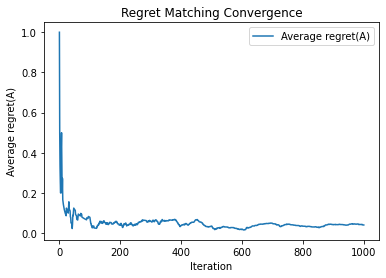


Check if empirical jointDist is CE:
[A violates CE]: i=3, i'=16, diff=0.234
Conclusion: Not CE.

Some (i,j) with prob>0.01 in jointDist:
   (i=2, j=3), prob=0.017, (A strat=(0, 2, 3), B strat=(0, 3, 2))
   (i=2, j=11), prob=0.011, (A strat=(0, 2, 3), B strat=(2, 0, 3))
   (i=2, j=14), prob=0.012, (A strat=(0, 2, 3), B strat=(2, 3, 0))
   (i=2, j=15), prob=0.011, (A strat=(0, 2, 3), B strat=(3, 0, 2))
   (i=3, j=7), prob=0.011, (A strat=(0, 3, 2), B strat=(1, 1, 3))
   (i=3, j=11), prob=0.022, (A strat=(0, 3, 2), B strat=(2, 0, 3))
   (i=3, j=14), prob=0.017, (A strat=(0, 3, 2), B strat=(2, 3, 0))
   (i=3, j=16), prob=0.015, (A strat=(0, 3, 2), B strat=(3, 1, 1))
   (i=3, j=17), prob=0.017, (A strat=(0, 3, 2), B strat=(3, 2, 0))
   (i=7, j=2), prob=0.021, (A strat=(1, 1, 3), B strat=(0, 2, 3))
   (i=7, j=3), prob=0.028, (A strat=(1, 1, 3), B strat=(0, 3, 2))
   (i=7, j=9), prob=0.017, (A strat=(1, 1, 3), B strat=(1, 3, 1))
   (i=7, j=17), prob=0.015, (A strat=(1, 1, 3), B strat=(3, 2, 

In [31]:
import random
import math

def get_all_strategies(S, N):
    """
    返回所有将 S 个士兵分配到 N 个战场的纯策略列表。
    (x1, x2, ..., xN) with sum(xi)=S, xi>=0.
    """
    results = []
    def back(now, left, slots):
        if slots==1:
            results.append(tuple(now+[left]))
            return
        for i in range(left+1):
            back(now+[i], left-i, slots-1)
    back([], S, N)
    return results

def payoff_A_vs_B_zero_sum(strategyA, strategyB):
    """
    零和规则: 
      if a>b => (A=1,B=-1)
      if a<b => (A=-1,B=1)
      if a=b => (A=0,B=0)
    累加 3 个战场 => (scoreA, scoreB).
    """
    scoreA = 0
    scoreB = 0
    for (a, b) in zip(strategyA, strategyB):
        if a > b:
            scoreA += 1
            scoreB -= 1
        elif a < b:
            scoreA -= 1
            scoreB += 1
        else:
            pass
    return scoreA, scoreB

def regret_matching_update(regretSum, strategies, chosenIndex, oppStrategy):
    """
    对行玩家(A)或列玩家(B)来说: 
    chosenIndex => 当前用的纯策略
    oppStrategy => 对手用的具体纯策略(元组)
    累加 external regret: for each i,
      regretSum[i] += (score_i - score_chosen).
    """
    chosenStrat = strategies[chosenIndex]
    scoreChosen, _ = payoff_A_vs_B_zero_sum(chosenStrat, oppStrategy)
    for i, s_i in enumerate(strategies):
        score_i, _ = payoff_A_vs_B_zero_sum(s_i, oppStrategy)
        diff = score_i - scoreChosen
        regretSum[i] += diff
    return regretSum

def get_mixed_strategy_from_regret(regretSum):
    """
    p[i] = max(0, regretSum[i])/ sum_of_positives
    若 sum_of_positives=0 => 均匀分布
    """
    positives = [max(r,0) for r in regretSum]
    totalPos = sum(positives)
    n = len(regretSum)
    if totalPos>1e-15:
        return [p/totalPos for p in positives]
    else:
        return [1.0/n]*n

def sample_from_distribution(dist):
    r = random.random()
    cum = 0.0
    for i, p in enumerate(dist):
        cum += p
        if r<cum:
            return i
    return len(dist)-1

# ===========  构造 payoff 矩阵 for CE check  ===========

def build_payoff_matrices(strategies):
    """
    A[i][j] = 当 A 用 i, B 用 j 时, A的收益
    B[i][j] = 当 A 用 i, B 用 j 时, B的收益 = -A[i][j], 因为零和
    """
    n = len(strategies)
    A = [[0]*n for _ in range(n)]
    B = [[0]*n for _ in range(n)]
    for i, sa in enumerate(strategies):
        for j, sb in enumerate(strategies):
            scoreA, scoreB = payoff_A_vs_B_zero_sum(sa, sb)
            A[i][j] = scoreA
            B[i][j] = scoreB
    return A,B

# ===========  CE 检查 ===========

def check_CE(A, B, jointDist, epsilon=1e-9):
    """
    检查给定(A,B)收益矩阵, jointDist(联合分布) 是否近似CE.
    A,B形状均 n x n, jointDist同理, sum=1.
    """
    n = len(A)
    # 1) 行玩家(A)条件收益
    for i in range(n):
        mu_i = sum(jointDist[i][j] for j in range(n))
        if mu_i<epsilon: 
            continue
        old_payoff = 0.0
        for j in range(n):
            old_payoff += jointDist[i][j]*A[i][j]
        old_payoff /= mu_i
        for i_prime in range(n):
            if i_prime==i: 
                continue
            new_payoff=0.0
            for j in range(n):
                new_payoff += jointDist[i][j]*A[i_prime][j]
            new_payoff/=mu_i
            if new_payoff>old_payoff+epsilon:
                print(f"[A violates CE]: i={i}, i'={i_prime}, diff={new_payoff-old_payoff:.3f}")
                return False
    # 2) 列玩家(B)条件收益
    for j in range(n):
        mu_j = sum(jointDist[i][j] for i in range(n))
        if mu_j<epsilon:
            continue
        old_payoff = 0.0
        for i in range(n):
            old_payoff += jointDist[i][j]*B[i][j]
        old_payoff/= mu_j
        for j_prime in range(n):
            if j_prime==j: 
                continue
            new_payoff=0.0
            for i in range(n):
                new_payoff += jointDist[i][j]*B[i][j_prime]
            new_payoff/=mu_j
            if new_payoff>old_payoff+epsilon:
                print(f"[B violates CE]: j={j}, j'={j_prime}, diff={new_payoff-old_payoff:.3f}")
                return False
    print("=> jointDist satisfies (approx) CE condition.")
    return True

# ===========  主函数: 无悔学习+收敛速度表  ===========

def main():
    random.seed()
    S=5
    N=3
    allStrats = get_all_strategies(S,N)    # 生成纯策略
    m = len(allStrats)                    # ~21
    print(f"We have {m} pure strategies for S={S},N={N}, in zero-sum version(tie=0).")

    # payoff 矩阵
    A_mat, B_mat = build_payoff_matrices(allStrats)
    # B_mat 应该= -A_mat, 在 build时自动算了 (scoreB= -scoreA or 0)
    # 这里是tie=0, a>b =>(1,-1), a<b =>(-1,1).

    # 后悔值
    regretSumA = [0.0]*m
    regretSumB = [0.0]*m
    strategyA = [1.0/m]*m
    strategyB = [1.0/m]*m

    # 记录 (iA,iB) 出现频率 => 检查CE
    jointCount = [[0]*m for _ in range(m)]

    num_iters = 100
    # 记录收敛速度: average regret(对A)
    regret_list = []

    for t in range(1, num_iters+1):
        # 1) 从当前混合策略采样
        iA = sample_from_distribution(strategyA)
        iB = sample_from_distribution(strategyB)
        # 2) 更新后悔
        stratA = allStrats[iA]
        stratB = allStrats[iB]
        regretSumA = regret_matching_update(regretSumA, allStrats, iA, stratB)
        regretSumB = regret_matching_update(regretSumB, allStrats, iB, stratA)
        # 3) 得到新的混合
        strategyA = get_mixed_strategy_from_regret(regretSumA)
        strategyB = get_mixed_strategy_from_regret(regretSumB)
        # 4) jointCount
        jointCount[iA][iB]+=1

        # === 计算 "平均外部后悔" for A ===
        # external regret for A:  max_{i'} regretSumA[i'] 的正部分
        max_regret_A = max(regretSumA)  # 可能有负值
        if max_regret_A < 0:
            max_regret_A = 0
        avg_regret_A = max_regret_A / t
        regret_list.append(avg_regret_A)

        # 可以每隔一定步数打印一次
        if t%5000==0:
            print(f"Iter={t}, avg_regret_A={avg_regret_A:.5f}")

    # 最终 jointDist
    jointDist = [[ jointCount[i][j]/num_iters for j in range(m)] for i in range(m)]

    # 打印收敛速度表(或画图)
    print("\n--- Final average regrets (last few) ---")
    for step in [num_iters-5, num_iters-4, num_iters-3, num_iters-2, num_iters-1, num_iters]:
        print(f"  t={step}, avg_regret_A={regret_list[step-1]:.6f}")

    # 如果想画图，可加 matplotlib:
    
    import matplotlib.pyplot as plt
    plt.plot(range(1,num_iters+1), regret_list, label='Average regret(A)')
    plt.xlabel('Iteration')
    plt.ylabel('Average regret(A)')
    plt.title('Regret Matching Convergence')
    plt.legend()
    plt.show()
    

    # ========== 最后做 CE 检验 ==========
    print("\nCheck if empirical jointDist is CE:")
    is_ce = check_CE(A_mat,B_mat, jointDist, epsilon=1e-1)
    if is_ce:
        print("Conclusion: It's an approximate CE.\n")
    else:
        print("Conclusion: Not CE.\n")

    # 展示几项 jointDist>0.01
    print("Some (i,j) with prob>0.01 in jointDist:")
    for i in range(m):
        for j in range(m):
            if jointDist[i][j]>0.01:
                print(f"   (i={i}, j={j}), prob={jointDist[i][j]:.3f}, (A strat={allStrats[i]}, B strat={allStrats[j]})")

if __name__=="__main__":
    main()


In [28]:
import random
import math

def get_all_strategies(S, N):
    """
    返回所有将 S 个士兵分配到 N 个战场的纯策略列表。
    (x1, x2, ..., xN), xi>=0, sum(xi)=S.
    """
    results = []
    def back(now, left, slots):
        if slots==1:
            results.append(tuple(now+[left]))
            return
        for i in range(left+1):
            back(now+[i], left-i, slots-1)
    back([], S, N)
    return results

def payoff_A_vs_B_zero_sum(strategyA, strategyB):
    """
    零和规则: 
      if a>b => (A=+1,B=-1)
      if a<b => (A=-1,B=+1)
      if a=b => (A=0,B=0)
    累加 N=3 个战场 => (scoreA, scoreB).
    """
    scoreA = 0
    scoreB = 0
    for (a, b) in zip(strategyA, strategyB):
        if a > b:
            scoreA += 1
            scoreB -= 1
        elif a < b:
            scoreA -= 1
            scoreB += 1
        else:
            # 平局 => 0,0
            pass
    return scoreA, scoreB

# ------------------ 两种 无悔学习更新 ------------------

def update_regret_neller(regretSum, strategies, chosenIndex, oppStrategy):
    """
    (Neller & Lanctot 风格) 
    每回合只根据本回合对比:
      regretSum[j] += payoff(j, opp) - payoff(chosenIndex, opp).
    """
    chosenStrat = strategies[chosenIndex]
    scoreChosen, _ = payoff_A_vs_B_zero_sum(chosenStrat, oppStrategy)
    for j, strat_j in enumerate(strategies):
        score_j, _ = payoff_A_vs_B_zero_sum(strat_j, oppStrategy)
        diff = score_j - scoreChosen
        regretSum[j] += diff
    return regretSum

def update_regret_hart(memoryMatrix, iStar, strategies, oppStrategy):
    """
    (Hart & Mas-Colell 风格)
    memoryMatrix[i][j]: 表示 "历史上所有用 i 的地方都替换成 j" 会多获得多少收益" 的累加值.

    本回合选了 iStar => 仅对 memoryMatrix[iStar][j] 更新:
      memoryMatrix[iStar][j] += payoff(j, opp) - payoff(iStar, opp).

    返回更新后的 memoryMatrix.
    """
    if iStar<0:  # 首回合无决策
        return memoryMatrix
    chosenStrat = strategies[iStar]
    payoff_iStar, _ = payoff_A_vs_B_zero_sum(chosenStrat, oppStrategy)

    for j, strat_j in enumerate(strategies):
        if j == iStar:
            continue  # 若替换成自己就没意义,也可加也可不加
        payoff_j, _ = payoff_A_vs_B_zero_sum(strat_j, oppStrategy)
        diff = payoff_j - payoff_iStar
        memoryMatrix[iStar][j] += diff

    return memoryMatrix

# --------------- 获取混合策略: Neller vs. Hart ---------------

def get_mixed_strategy_from_regret(regretSum):
    """
    (Neller风格) p[j] = max(0, regretSum[j]) / sum_of_positives
    若 sum_of_positives=0 => 均匀
    """
    positives = [max(0,r) for r in regretSum]
    s = sum(positives)
    n = len(regretSum)
    if s>1e-15:
        return [p/s for p in positives]
    else:
        return [1.0/n]*n

def get_mixed_strategy_hart(memoryMatrix, iStar):
    """
    (Hart风格) 用 memoryMatrix[iStar] 那一行构造分布:
      对 j != iStar: measure_j = max(0, memoryMatrix[iStar][j])
      sumPos = sum_{j != iStar} measure_j
      p[j] = measure_j / total  (先等比, or 先不归一化?)
      p[iStar] = 1 - sum_{j != iStar} p[j]

    若 sum_of_measures=0 => 均匀.
    """
    n = len(memoryMatrix)
    if iStar<0 or iStar>=n:
        # 如果还没选过, 就均匀
        return [1.0/n]*n

    row = memoryMatrix[iStar]
    measures = [0.0]*n
    for j in range(n):
        if j==iStar:
            continue
        measures[j] = max(0.0, row[j])
    sumPos = sum(measures)

    # 先看有没有正值
    if sumPos<=1e-15:
        # 全<=0 => 均匀
        return [1.0/n]*n

    # 先给 j != iStar => p[j] = measures[j]/sumPos
    p = [0.0]*n
    for j in range(n):
        if j!=iStar:
            p[j] = measures[j]/sumPos

    # p[iStar] = 1 - sum_{j!=iStar} p[j]
    sum_others = sum(p[j] for j in range(n) if j!=iStar)
    remain = 1.0 - sum_others
    if remain<0:
        remain=0.0
    p[iStar] = remain

    return p

# -------------------  Payoff 矩阵 (for CE) -------------------

def build_payoff_matrices(strategies):
    """
    A[i][j] = payoff_A_vs_B_zero_sum(strategies[i], strategies[j])[0]
    B[i][j] = payoff_A_vs_B_zero_sum(strategies[i], strategies[j])[1]
    """
    n = len(strategies)
    A = [[0]*n for _ in range(n)]
    B = [[0]*n for _ in range(n)]
    for i, sa in enumerate(strategies):
        for j, sb in enumerate(strategies):
            scoreA, scoreB = payoff_A_vs_B_zero_sum(sa, sb)
            A[i][j] = scoreA
            B[i][j] = scoreB
    return A,B

def check_CE(A, B, jointDist, epsilon=1e-9):
    """
    检查给定(A,B)收益矩阵, jointDist(n×n), sum=1, 是否 (approx) CE
    """
    n = len(A)
    # 行玩家(A):
    for i in range(n):
        mu_i = sum(jointDist[i][j] for j in range(n))
        if mu_i<epsilon:
            continue
        old_payoff = 0.0
        for j in range(n):
            old_payoff += jointDist[i][j]*A[i][j]
        old_payoff /= mu_i
        for i_prime in range(n):
            if i_prime==i:
                continue
            new_payoff=0.0
            for j in range(n):
                new_payoff += jointDist[i][j]*A[i_prime][j]
            new_payoff/=mu_i
            if new_payoff>old_payoff+epsilon:
                print(f"[A violates CE]: i={i}, i'={i_prime}, diff={new_payoff-old_payoff:.3f}")
                return False
    # 列玩家(B):
    for j in range(n):
        mu_j = sum(jointDist[i][j] for i in range(n))
        if mu_j<epsilon:
            continue
        old_payoff=0.0
        for i in range(n):
            old_payoff += jointDist[i][j]*B[i][j]
        old_payoff/= mu_j
        for j_prime in range(n):
            if j_prime==j:
                continue
            new_payoff=0.0
            for i in range(n):
                new_payoff += jointDist[i][j]*B[i][j_prime]
            new_payoff/=mu_j
            if new_payoff>old_payoff+epsilon:
                print(f"[B violates CE]: j={j}, j'={j_prime}, diff={new_payoff-old_payoff:.3f}")
                return False
    print("=> jointDist satisfies (approx) CE condition.")
    return True

# ------------------- 主函数示例: 两种风格学习 -------------------

def main():
    random.seed(12345)
    S=5; N=3
    allStrats = get_all_strategies(S,N)
    m = len(allStrats)
    print(f"We have {m} pure strategies for S={S},N={N} (tie=0 zero-sum).")

    A_mat,B_mat = build_payoff_matrices(allStrats)

    # =============== 1) Neller-style (对比本回合) =================
    regretSumA_neller = [0.0]*m
    strategyA_neller  = [1.0/m]*m
    jointCount_neller = [[0]*m for _ in range(m)]

    # =============== 2) Hart-style (记忆矩阵 memoryMatrix[i][j]) =================
    memoryMatrixA = [[0.0]*m for _ in range(m)]  # A的 memory
    iStarA = None                                # 记录"本回合A选的是哪一行"
    strategyA_hart = [1.0/m]*m
    jointCount_hart= [[0]*m for _ in range(m)]

    # 同理你也可给 B 做两种style, 这里先演示 A 用2种, B 固定或随便
    # 简化: B 用固定纯策略(0,5,0) => 只演示A
    # 你也可以让 B 也学,这部分逻辑相似

    oppStrategy = (0,5,0)

    num_iters = 2000
    for t in range(1, num_iters+1):
        # 1) Neller-style A
        iA_neller = sample_from_distribution(strategyA_neller)
        # 更新
        regretSumA_neller = update_regret_neller(regretSumA_neller, allStrats, iA_neller, oppStrategy)
        strategyA_neller  = get_mixed_strategy_from_regret(regretSumA_neller)
        # 统计
        jointCount_neller[iA_neller][0] += 1  # B固定=0号纯策略? 其实(oppStrategy)不是索引…这里简化

        # 2) Hart-style A
        iA_hart = sample_from_distribution(strategyA_hart)
        # 更新 memoryMatrix
        memoryMatrixA = update_regret_hart(memoryMatrixA, iStarA if iStarA is not None else -1, allStrats, oppStrategy)
        # 下次策略 => 用 memoryMatrixA[iA_hart] 那一行 => 其实要先设 iStarA = iA_hart, 再更新?
        #   先更新 => (把上一回合 iStarA 替换); 这回合 iStarA=iA_hart
        #   => 下回合再对 memoryMatrixA[iA_hart] 行 -> get_mixed_strategy_hart.
        #   这里稍作顺序调整:
        newStratHart = get_mixed_strategy_hart(memoryMatrixA, iA_hart)
        strategyA_hart = newStratHart
        # 统计
        jointCount_hart[iA_hart][0] += 1

        # 记录 iStarA => 这回合真正选择了 iA_hart
        iStarA = iA_hart

    # ========== 得到最终联合分布(仅对 B=0 纯策略, 简化) ==========
    #   若想 B=多个策略,就要对 iB 也做 sample+统计
    jointDist_neller = [[jointCount_neller[i][j]/num_iters for j in range(m)] for i in range(m)]
    jointDist_hart   = [[jointCount_hart[i][j]/num_iters for j in range(m)] for i in range(m)]

    print("\n--- Neller-style final distribution (row>0.01) ---")
    for i,p in enumerate(strategyA_neller):
        if p>0.01:
            print(f"  i={i}, strat={allStrats[i]}, prob={p:.3f}")

    print("--- Hart-style final distribution (row>0.01) ---")
    for i,p in enumerate(strategyA_hart):
        if p>0.01:
            print(f"  i={i}, strat={allStrats[i]}, prob={p:.3f}")

    # ========== CE 检验: 需要完整( iB ) => 这里只演示
    print("\nCheck if neller jointDist is CE (assuming j=0 col), might be nonsense but just to show:")
    is_ce_neller = check_CE(A_mat, B_mat, jointDist_neller)
    print("Conclusion neller CE:", is_ce_neller)

    print("\nCheck if hart jointDist is CE (assuming j=0 col):")
    is_ce_hart = check_CE(A_mat, B_mat, jointDist_hart)
    print("Conclusion hart CE:", is_ce_hart)

if __name__=="__main__":
    main()


We have 21 pure strategies for S=5,N=3 (tie=0 zero-sum).

--- Neller-style final distribution (row>0.01) ---
  i=6, strat=(1, 0, 4), prob=0.100
  i=7, strat=(1, 1, 3), prob=0.100
  i=8, strat=(1, 2, 2), prob=0.100
  i=9, strat=(1, 3, 1), prob=0.100
  i=11, strat=(2, 0, 3), prob=0.100
  i=12, strat=(2, 1, 2), prob=0.100
  i=13, strat=(2, 2, 1), prob=0.100
  i=15, strat=(3, 0, 2), prob=0.100
  i=16, strat=(3, 1, 1), prob=0.100
  i=18, strat=(4, 0, 1), prob=0.100
--- Hart-style final distribution (row>0.01) ---
  i=0, strat=(0, 0, 5), prob=0.048
  i=1, strat=(0, 1, 4), prob=0.048
  i=2, strat=(0, 2, 3), prob=0.048
  i=3, strat=(0, 3, 2), prob=0.048
  i=4, strat=(0, 4, 1), prob=0.048
  i=5, strat=(0, 5, 0), prob=0.048
  i=6, strat=(1, 0, 4), prob=0.048
  i=7, strat=(1, 1, 3), prob=0.048
  i=8, strat=(1, 2, 2), prob=0.048
  i=9, strat=(1, 3, 1), prob=0.048
  i=10, strat=(1, 4, 0), prob=0.048
  i=11, strat=(2, 0, 3), prob=0.048
  i=12, strat=(2, 1, 2), prob=0.048
  i=13, strat=(2, 2, 1), pro